# Прогнозирование температуры стали в процессе металлургической обработки

Проект направлен на создание модели машинного обучения для прогнозирования температуры стали во время ее обработки на металлургическом комбинате "Стальная птица". Цель - оптимизировать энергопотребление путем точного контроля температуры сплава.

Цель:
Разработать модель, способную предсказывать температуру стали на основе различных параметров технологического процесса, что позволит оптимизировать энергопотребление и улучшить контроль над производственным процессом.

## Загрузка необходимых библиотек и данных

In [177]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor

In [178]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)


In [179]:
import warnings
warnings.filterwarnings("ignore")

## EDA 

In [181]:
def dataset_summary(dataset):
    
    print("=== Информация о датасете ===")
    dataset.info()

    print("\n=== Первые 5 строк датасета ===")
    print(dataset.head())

    print("\n=== Количество пропущенных значений ===")
    print(dataset.isna().sum())

    print("\n=== Количество дублированных строк ===")
    print(dataset.duplicated().sum())

### data_arc

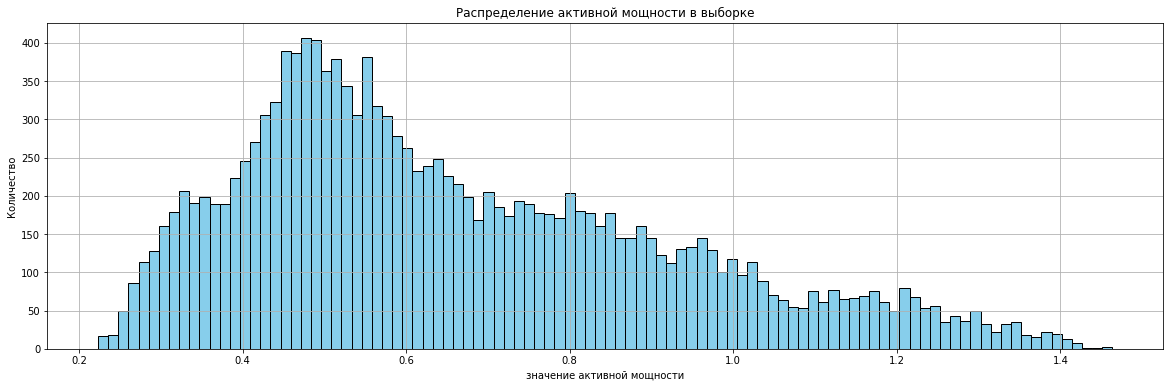

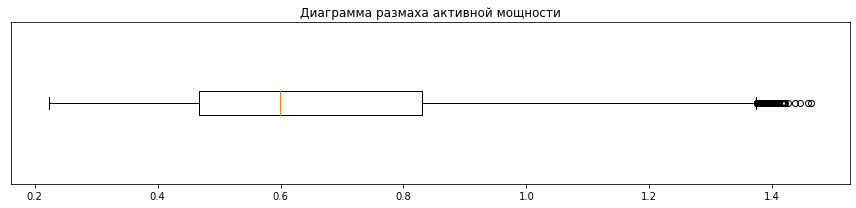

In [184]:
# Построение гистограммы возраста
plt.figure(figsize=(20, 6))
plt.hist(data_arc_new['Активная мощность'], bins=100, color='skyblue', edgecolor='black')
plt.title('Распределение активной мощности в выборке')
plt.xlabel('значение активной мощности')
plt.ylabel('Количество')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 3))
plt.boxplot(data_arc_new['Активная мощность'], vert=False)
plt.title('Диаграмма размаха активной мощности')
plt.yticks([])
plt.gca().invert_yaxis()  # Чтобы ось Y была сверху вниз

plt.tight_layout()
plt.show()

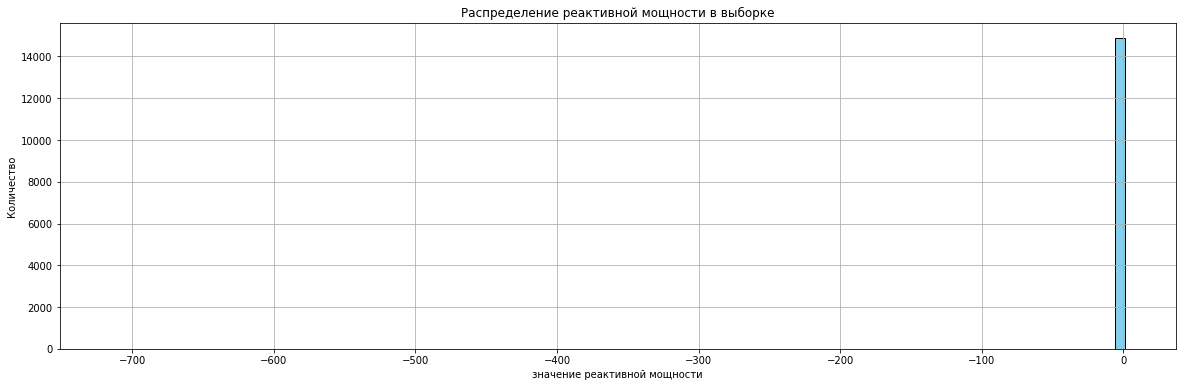

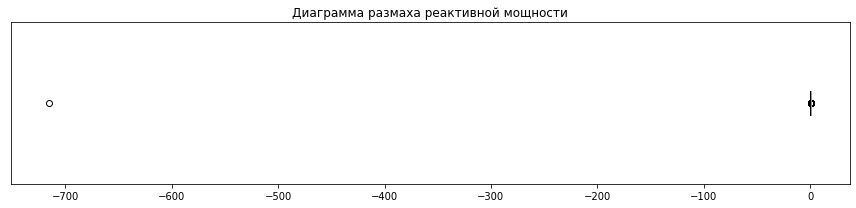

In [185]:
# Построение гистограммы возраста
plt.figure(figsize=(20, 6))
plt.hist(data_arc_new['Реактивная мощность'], bins=100, color='skyblue', edgecolor='black')
plt.title('Распределение реактивной мощности в выборке')
plt.xlabel('значение реактивной мощности')
plt.ylabel('Количество')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 3))
plt.boxplot(data_arc_new['Реактивная мощность'], vert=False)
plt.title('Диаграмма размаха реактивной мощности')
plt.yticks([])
plt.gca().invert_yaxis()  # Чтобы ось Y была сверху вниз

plt.tight_layout()
plt.show()

В датасете data_arc_new.csv по требованию заказчика был удален номер партии, в котором обнаружилась отрицательная реактивная мощность. Проспусков и явных дубликатов нет. Имеются выбросы.

### data_bulk

In [188]:
def check_anomalies(series):
    # Проверка на NaN
    nan_count = series.isna().sum()
    
    # Проверка на очень большие значения
    max_value = series.max()
    min_value = series.min()
    q75, q25 = np.percentile(series, [75, 25])
    iqr = q75 - q25
    
    lower_bound = q25 - (1.5 * iqr)
    upper_bound = q75 + (1.5 * iqr)
    
    outliers = series[(series < lower_bound) | (series > upper_bound)].count()
    
    return {
        'NaN_count': nan_count,
        'Min': min_value,
        'Max': max_value,
        'Q1': q25,
        'Median': series.median(),
        'Q3': q75,
        'IQR': iqr,
        'Lower_bound': lower_bound,
        'Upper_bound': upper_bound,
        'Outliers': outliers
    }


In [189]:
columns_to_fill = ['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 
                   'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9',
                   'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14',
                   'Bulk 15']
anomaly_results = {}
for column in columns_to_fill:
    results = check_anomalies(data_bulk_new[column])
    anomaly_results[column] = results
    print(f"\nАномалии в столбце {column}:")
    print(results)


Аномалии в столбце Bulk 1:
{'NaN_count': 2877, 'Min': 10.0, 'Max': 185.0, 'Q1': nan, 'Median': 31.0, 'Q3': nan, 'IQR': nan, 'Lower_bound': nan, 'Upper_bound': nan, 'Outliers': 0}

Аномалии в столбце Bulk 2:
{'NaN_count': 3107, 'Min': 228.0, 'Max': 325.0, 'Q1': nan, 'Median': 251.5, 'Q3': nan, 'IQR': nan, 'Lower_bound': nan, 'Upper_bound': nan, 'Outliers': 0}

Аномалии в столбце Bulk 3:
{'NaN_count': 1831, 'Min': 6.0, 'Max': 454.0, 'Q1': nan, 'Median': 97.5, 'Q3': nan, 'IQR': nan, 'Lower_bound': nan, 'Upper_bound': nan, 'Outliers': 0}

Аномалии в столбце Bulk 4:
{'NaN_count': 2115, 'Min': 12.0, 'Max': 281.0, 'Q1': nan, 'Median': 102.0, 'Q3': nan, 'IQR': nan, 'Lower_bound': nan, 'Upper_bound': nan, 'Outliers': 0}

Аномалии в столбце Bulk 5:
{'NaN_count': 3052, 'Min': 11.0, 'Max': 603.0, 'Q1': nan, 'Median': 86.0, 'Q3': nan, 'IQR': nan, 'Lower_bound': nan, 'Upper_bound': nan, 'Outliers': 0}

Аномалии в столбце Bulk 6:
{'NaN_count': 2553, 'Min': 17.0, 'Max': 503.0, 'Q1': nan, 'Median': 10

Некоторые столбцы имеют небольшое количество выбросов (например, Bulk 1, Bulk 2, Bulk 3, Bulk 4, Bulk 5, Bulk 6, Bulk 7, Bulk 9, Bulk 10, Bulk 11, Bulk 13, Bulk 14, Bulk 15).
Столбец Bulk 12: Этот столбец имеет более широкое распределение значений (от 105 до 1849), что может указывать на более сложную природу данных или наличия дополнительных факторов, влияющих на эти данные.

### data_gas 

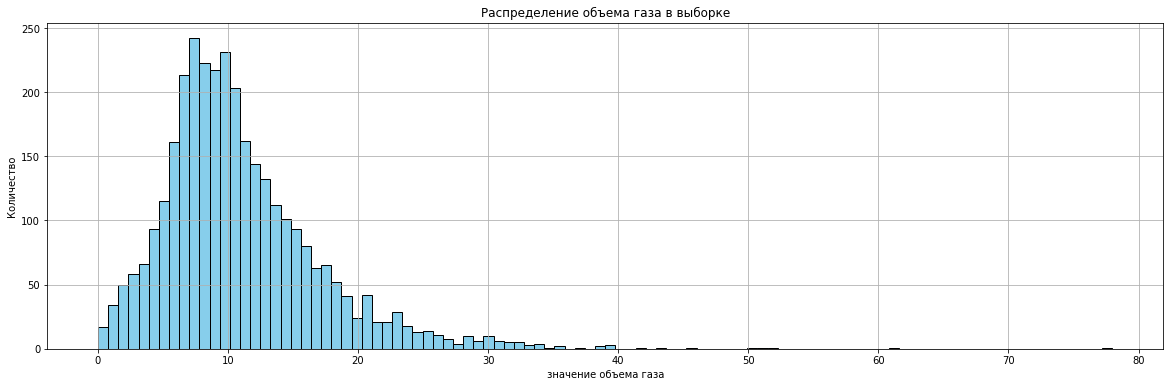

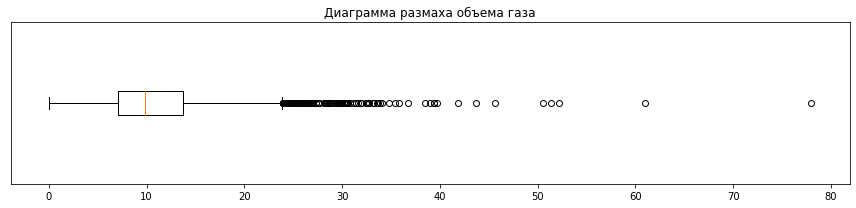

In [193]:
# Построение гистограммы возраста
plt.figure(figsize=(20, 6))
plt.hist(data_gas_new['Газ 1'], bins=100, color='skyblue', edgecolor='black')
plt.title('Распределение объема газа в выборке')
plt.xlabel('значение объема газа')
plt.ylabel('Количество')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 3))
plt.boxplot(data_gas_new['Газ 1'], vert=False)
plt.title('Диаграмма размаха объема газа')
plt.yticks([])
plt.gca().invert_yaxis()  # Чтобы ось Y была сверху вниз

plt.tight_layout()
plt.show()

наблюдается большое количество выбросов

### data_temp

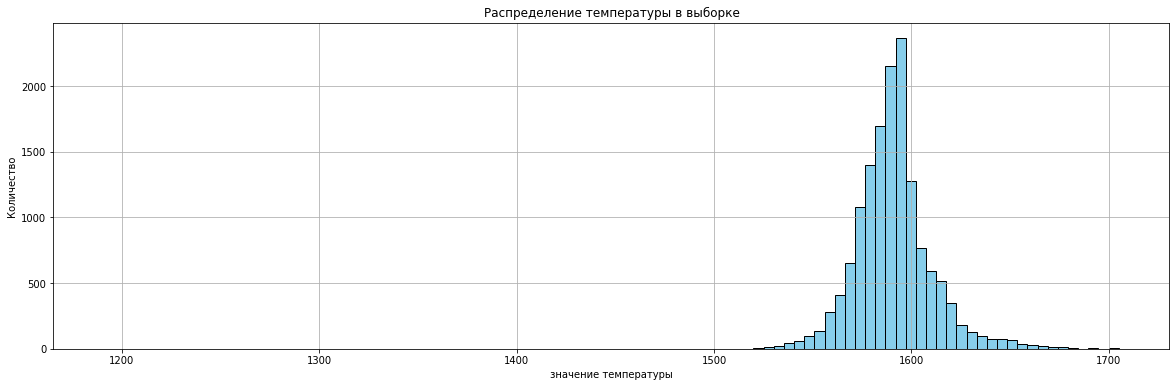

In [196]:
# Построение гистограммы 
plt.figure(figsize=(20, 6))
plt.hist(data_temp_new['Температура'], bins=100, color='skyblue', edgecolor='black')
plt.title('Распределение температуры в выборке')
plt.xlabel('значение температуры')
plt.ylabel('Количество')
plt.grid(True)
plt.show()

Наблюдается большое количество выбросов у температуры, а также распределение

### data_wire

In [199]:
columns_to_fill_2 = ['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 
                   'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']
anomaly_results = {}
for column in columns_to_fill_2:
    results = check_anomalies(data_wire_new[column])
    anomaly_results[column] = results
    print(f"\nАномалии в столбце {column}:")
    print(results)


Аномалии в столбце Wire 1:
{'NaN_count': 26, 'Min': 1.9188, 'Max': 330.31442400000003, 'Q1': nan, 'Median': 100.158234, 'Q3': nan, 'IQR': nan, 'Lower_bound': nan, 'Upper_bound': nan, 'Outliers': 0}

Аномалии в столбце Wire 2:
{'NaN_count': 2002, 'Min': 0.03016, 'Max': 282.78015200000004, 'Q1': nan, 'Median': 40.142956, 'Q3': nan, 'IQR': nan, 'Lower_bound': nan, 'Upper_bound': nan, 'Outliers': 0}

Аномалии в столбце Wire 3:
{'NaN_count': 3018, 'Min': 0.144144, 'Max': 385.008668, 'Q1': nan, 'Median': 235.194977, 'Q3': nan, 'IQR': nan, 'Lower_bound': nan, 'Upper_bound': nan, 'Outliers': 0}

Аномалии в столбце Wire 4:
{'NaN_count': 3067, 'Min': 24.148801, 'Max': 113.231044, 'Q1': nan, 'Median': 45.2342825, 'Q3': nan, 'IQR': nan, 'Lower_bound': nan, 'Upper_bound': nan, 'Outliers': 0}

Аномалии в столбце Wire 5:
{'NaN_count': 3080, 'Min': 15.132, 'Max': 15.132, 'Q1': nan, 'Median': 15.132, 'Q3': nan, 'IQR': nan, 'Lower_bound': nan, 'Upper_bound': nan, 'Outliers': 0}

Аномалии в столбце Wire

Заменили пропущенные значения на ноль. В результате большинство столбцов в основном состоят из нулей, также у некоторых столбцов есть выбросы

### Вывод

в результате первоначального ознакомления со входными данными были найдены пропуски и выбросы в различных датасетах. В дальнейшем их следует обработать

## Предобработка данных

### data_arc

In [201]:
print("Значения ключа (номера партии), где реактивная мощность отрицательна:")
print(data_arc_new[data_arc_new['Реактивная мощность'] < 0]['key'].tolist())
print(f"\nКоличество записей с отрицательной реактивной мощностью: {len(data_arc_new[data_arc_new['Реактивная мощность'] < 0]['key'].tolist())}")
data_arc_new[data_arc_new['Реактивная мощность'] < 0]

Значения ключа (номера партии), где реактивная мощность отрицательна:
[2116]

Количество записей с отрицательной реактивной мощностью: 1


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [202]:
data_arc_new = data_arc_new[data_arc_new['key'] != 2116]
data_arc_new.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [203]:
data_arc_new['Начало нагрева дугой'] = pd.to_datetime(data_arc_new['Начало нагрева дугой'])
data_arc_new['Конец нагрева дугой'] = pd.to_datetime(data_arc_new['Конец нагрева дугой'])
data_arc_new['Разница времени'] = (data_arc_new['Конец нагрева дугой'] - data_arc_new['Начало нагрева дугой']).dt.total_seconds()


In [204]:
data_arc_new = data_arc_new.groupby('key').agg({
    'Начало нагрева дугой': 'min',
    'Конец нагрева дугой': 'max',
    'Разница времени': 'mean',
    'Активная мощность': 'mean',
    'Реактивная мощность': 'mean'
}).reset_index()
data_arc_new.columns = ['key','Начало нагрева дугой', 'Конец нагрева дугой','Разница времени', 'Суммарная активная мощность', 'Суммарная реактивная мощность']

In [205]:
data_arc_new.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Разница времени,Суммарная активная мощность,Суммарная реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:28:37,219.60,0.607346,0.428564
1,2,2019-05-03 11:34:14,2019-05-03 11:53:18,202.75,0.534852,0.363339
2,3,2019-05-03 12:06:54,2019-05-03 12:32:19,131.00,0.812728,0.587491
3,4,2019-05-03 12:39:37,2019-05-03 12:57:50,185.25,0.676622,0.514248
4,5,2019-05-03 13:11:13,2019-05-03 13:33:55,217.25,0.563238,0.421998


In [206]:
columns_to_round = ['Суммарная активная мощность', 'Суммарная реактивная мощность']
for col in columns_to_round:
    data_arc_new[col] = data_arc_new[col].round(2)


In [207]:
data_arc_new.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Разница времени,Суммарная активная мощность,Суммарная реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:28:37,219.60,0.61,0.43
1,2,2019-05-03 11:34:14,2019-05-03 11:53:18,202.75,0.53,0.36
2,3,2019-05-03 12:06:54,2019-05-03 12:32:19,131.00,0.81,0.59
3,4,2019-05-03 12:39:37,2019-05-03 12:57:50,185.25,0.68,0.51
4,5,2019-05-03 13:11:13,2019-05-03 13:33:55,217.25,0.56,0.42


### data_bulk

In [208]:
columns_to_remove = ['Bulk 1', 'Bulk 2', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 13']
columns_to_mean = ['Bulk 3', 'Bulk 4', 'Bulk 12', 'Bulk 14', 'Bulk 15']

In [209]:
for col in columns_to_fill:
    data_bulk_new[col] = data_bulk_new[col].fillna(0).astype(int)
data_bulk_new = data_bulk_new.drop(columns_to_remove,axis=1)
data_bulk_new['Bulk_total'] = data_bulk_new[columns_to_mean].sum(axis=1)

data_bulk_new.head()                                                          

,key,Bulk 3,Bulk 4,Bulk 12,Bulk 14,Bulk 15,Bulk_total
0,1,0,43,206,150,154,553
1,2,0,73,206,149,154,582
2,3,0,34,205,152,153,544
3,4,0,81,207,153,154,595
4,5,0,78,203,151,152,584


### data_bulk_time

In [210]:
data_bulk_time_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


### data_gas

In [211]:
dataset_summary(data_gas_new)

=== Информация о датасете ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB

=== Первые 5 строк датасета ===
   key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

=== Количество пропущенных значений ===
key      0
Газ 1    0
dtype: int64

=== Количество дублированных строк ===
0


In [212]:
columns_to_round = ['Газ 1']
for col in columns_to_round:
    data_gas_new[col] = data_gas_new[col].round(2)


### data_temp

In [213]:
data_temp_new.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [214]:
print("Значения ключа (номера партии), где температура меньше 1500:")
print(data_temp_new[data_temp_new['Температура'] < 1500]['key'].tolist())
data_temp_new[data_temp_new['Температура'] < 1500]

Значения ключа (номера партии), где температура меньше 1500:
[867, 1214, 1619, 2052, 2561]


,key,Время замера,Температура
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0
14283,2561,2019-08-12 18:49:29,1204.0


In [215]:
data_temp_new = data_temp_new[data_temp_new['Температура'] >= 1500]
data_temp_new.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [216]:
parties_with_one_measurement = data_temp_new['key'].value_counts()[data_temp_new['key'].value_counts() == 1].index.tolist()
data_temp_new = data_temp_new[~data_temp_new['key'].isin(parties_with_one_measurement)]
data_temp_new.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [217]:
data_temp_new[data_temp_new['key']==2880]

,key,Время замера,Температура


In [218]:
data_temp_new['Время замера'] = pd.to_datetime(data_temp_new['Время замера'])
data_temp_new = data_temp_new.sort_values(['key', 'Время замера'])
data_temp_new = data_temp_new.groupby('key').agg({
    'Время замера': ['first', 'last'],
    'Температура': ['first', 'last']
})
data_temp_new.columns = ['first_Время замера', 'last_Время замера', 'first_Температура', 'last_Температура']
data_temp_new = data_temp_new.reset_index()

In [219]:
data_temp_new.head()

,key,first_Время замера,last_Время замера,first_Температура,last_Температура
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0


In [220]:
data_temp_new['Время между замерами'] = data_temp_new['last_Время замера'] - data_temp_new['first_Время замера']
data_temp_new['Время между замерами (сек)'] = data_temp_new['Время между замерами'].dt.total_seconds()
columns_to_drop = ['first_Время замера', 'last_Время замера', 'Время между замерами']
data_temp_new = data_temp_new.drop(columns=columns_to_drop)

In [221]:
data_temp_new.head()

,key,first_Температура,last_Температура,Время между замерами (сек)
0,1,1571.0,1613.0,1714.0
1,2,1581.0,1602.0,1265.0
2,3,1596.0,1599.0,1753.0
3,4,1601.0,1625.0,1220.0
4,5,1576.0,1602.0,1536.0


In [222]:
data_temp_new.isna().sum()

key                           0
first_Температура             0
last_Температура              0
Время между замерами (сек)    0
dtype: int64

удалили все партии с температурой меньше 1500, а также с один ее замером

### data_wire

In [223]:
columns_to_remove = ['Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']
columns_to_mean = ['Wire 1', 'Wire 2']

In [224]:
for col in columns_to_fill_2:
    data_wire_new[col] = data_wire_new[col].fillna(0).astype(int)
data_wire_new = data_wire_new.drop(columns_to_remove,axis=1)
data_wire_new['Wire_total'] = data_wire_new[columns_to_mean].sum(axis=1)
data_wire_new.head()                                                  

,key,Wire 1,Wire 2,Wire_total
0,1,60,0,60
1,2,96,0,96
2,3,91,0,91
3,4,89,0,89
4,5,89,9,98


### data_wire_time

In [225]:
data_wire_time_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В результате предобработки данных были выполнены требования заказчика и удалены все малые мощности, а также отрицательные значения реактивной мощности и все остальные требования. Также были сгенерированы новые признаки: Работа, средняя масса подачи материалов, средняя масса подачи проволоки, выделены первая и конечная температуры, время между замерами (сек).

### Объединение датасетов 

In [226]:
result_df = data_temp_new.merge(data_arc_new, on='key', how='inner') \
            .merge(data_gas_new, on='key', how='inner') \
            .merge(data_bulk_new, on='key', how='inner') \
            .merge(data_wire_new, on='key', how='inner')

In [227]:
result_df.tail()

,key,first_Температура,last_Температура,Время между замерами (сек),Начало нагрева дугой,Конец нагрева дугой,Разница времени,Суммарная активная мощность,Суммарная реактивная мощность,Газ 1,Bulk 3,Bulk 4,Bulk 12,Bulk 14,Bulk 15,Bulk_total,Wire 1,Wire 2,Wire_total
2323,2495,1570.0,1591.0,1380.0,2019-08-10 11:27:57,2019-08-10 11:48:05,180.750000,0.79,0.55,7.13,21,0,256,129,223,629,89,0,89
2324,2496,1554.0,1591.0,1705.0,2019-08-10 11:56:58,2019-08-10 12:23:07,156.666667,0.70,0.48,9.41,0,63,256,129,226,674,114,0,114
2325,2497,1571.0,1589.0,962.0,2019-08-10 12:37:36,2019-08-10 12:51:20,189.666667,1.20,0.82,6.27,0,85,230,124,226,665,94,9,103
2326,2498,1591.0,1594.0,1520.0,2019-08-10 12:58:21,2019-08-10 13:20:59,150.000000,0.64,0.45,14.95,90,0,206,129,207,632,118,0,118
2327,2499,1569.0,1603.0,1537.0,2019-08-10 13:33:31,2019-08-10 13:56:17,220.750000,0.43,0.32,11.34,47,0,233,126,227,633,110,50,160


In [228]:
result_df['Полная мощность'] = np.sqrt((result_df['Суммарная активная мощность'])**2 + (result_df['Суммарная реактивная мощность'])**2)
# Создание нового признака - работа
result_df['Работа'] = result_df['Полная мощность'] * data_arc_new['Разница времени']
result_df['Время нагрева дугой (сек)'] = (result_df['Конец нагрева дугой'] - result_df['Начало нагрева дугой']).dt.total_seconds()

In [229]:
result_df = result_df.drop('key',axis=1)
dataset_summary(result_df)

=== Информация о датасете ===
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2328 entries, 0 to 2327
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   first_Температура              2328 non-null   float64       
 1   last_Температура               2328 non-null   float64       
 2   Время между замерами (сек)     2328 non-null   float64       
 3   Начало нагрева дугой           2328 non-null   datetime64[ns]
 4   Конец нагрева дугой            2328 non-null   datetime64[ns]
 5   Разница времени                2328 non-null   float64       
 6   Суммарная активная мощность    2328 non-null   float64       
 7   Суммарная реактивная мощность  2328 non-null   float64       
 8   Газ 1                          2328 non-null   float64       
 9   Bulk 3                         2328 non-null   int64         
 10  Bulk 4                         2328 non-null   int64  

#### EDA

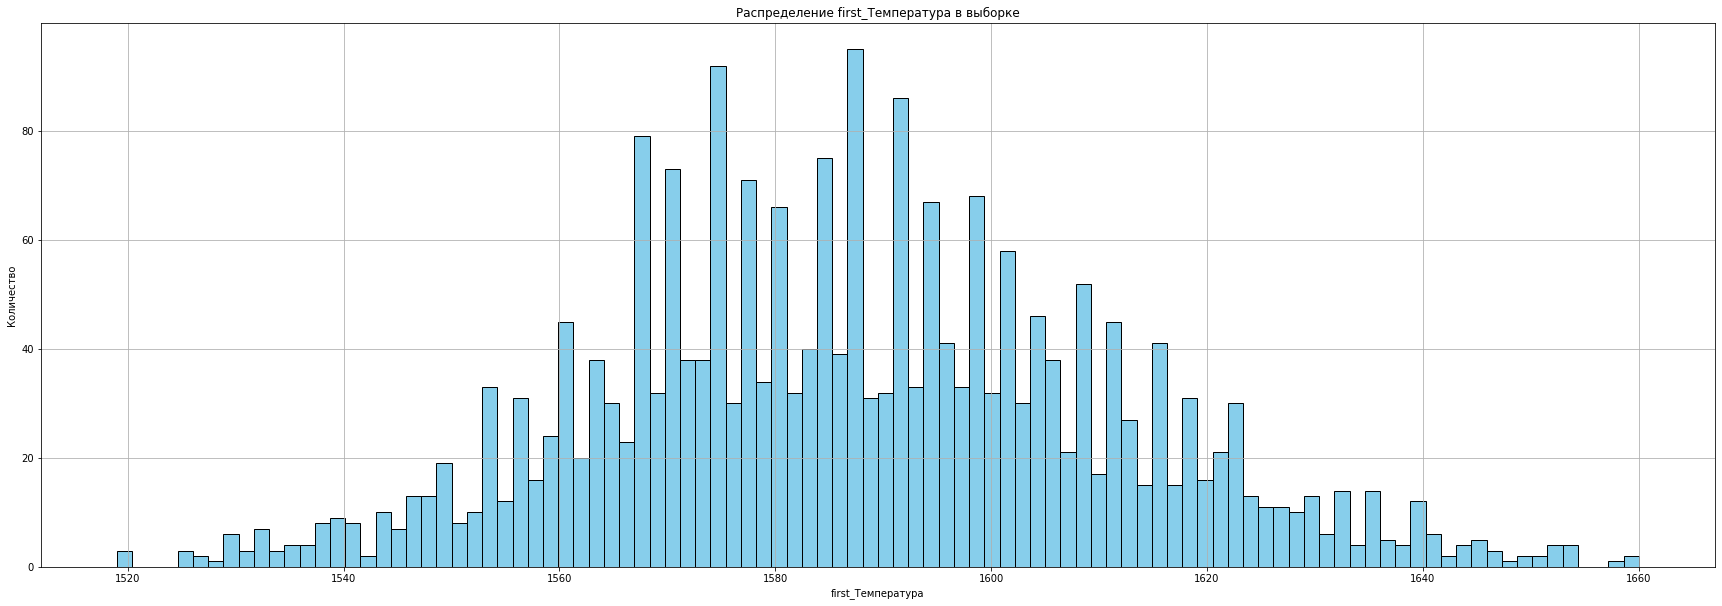

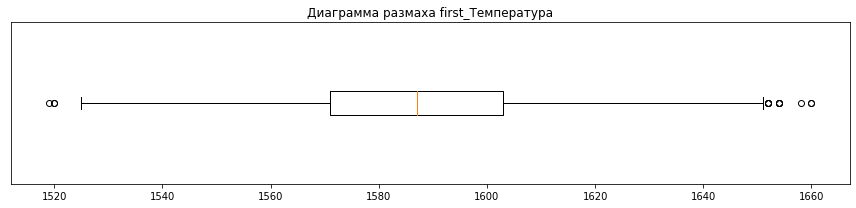

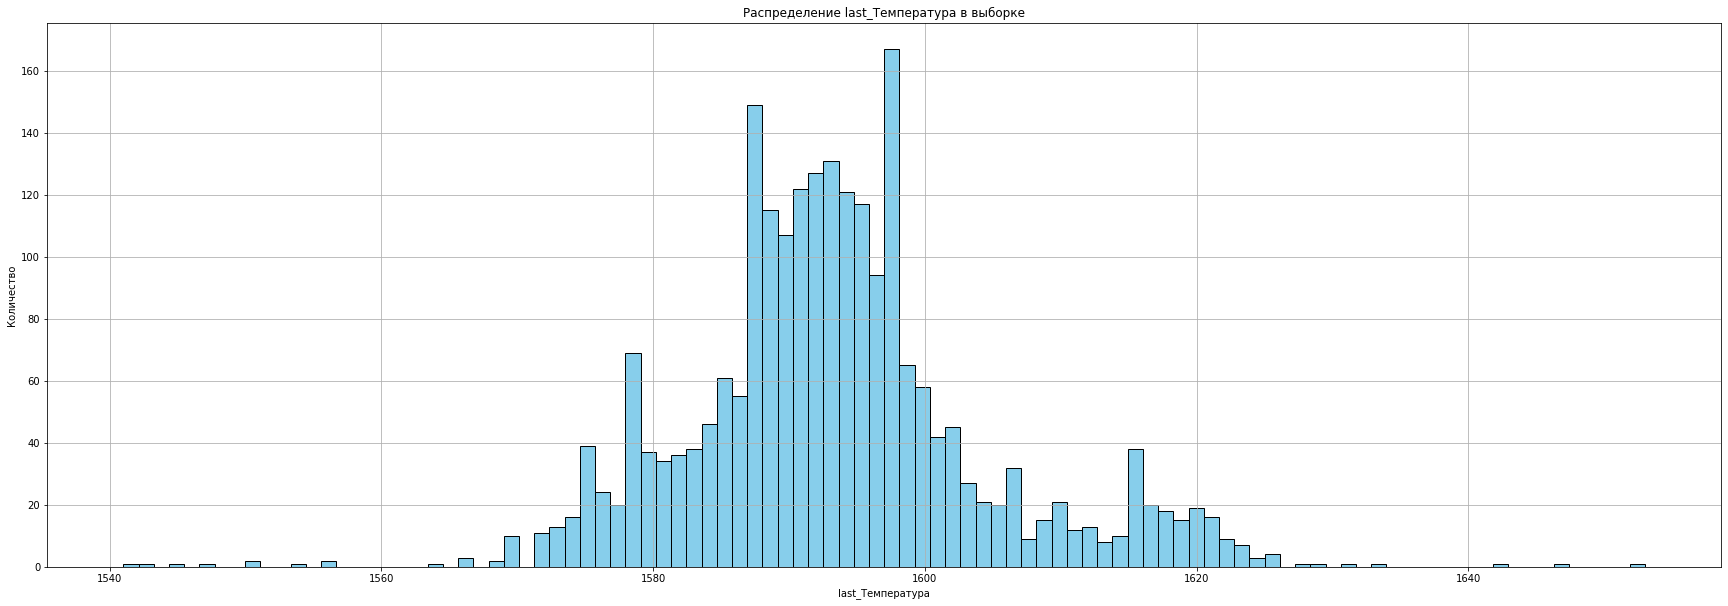

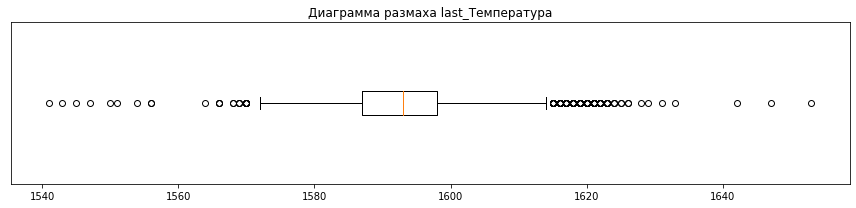

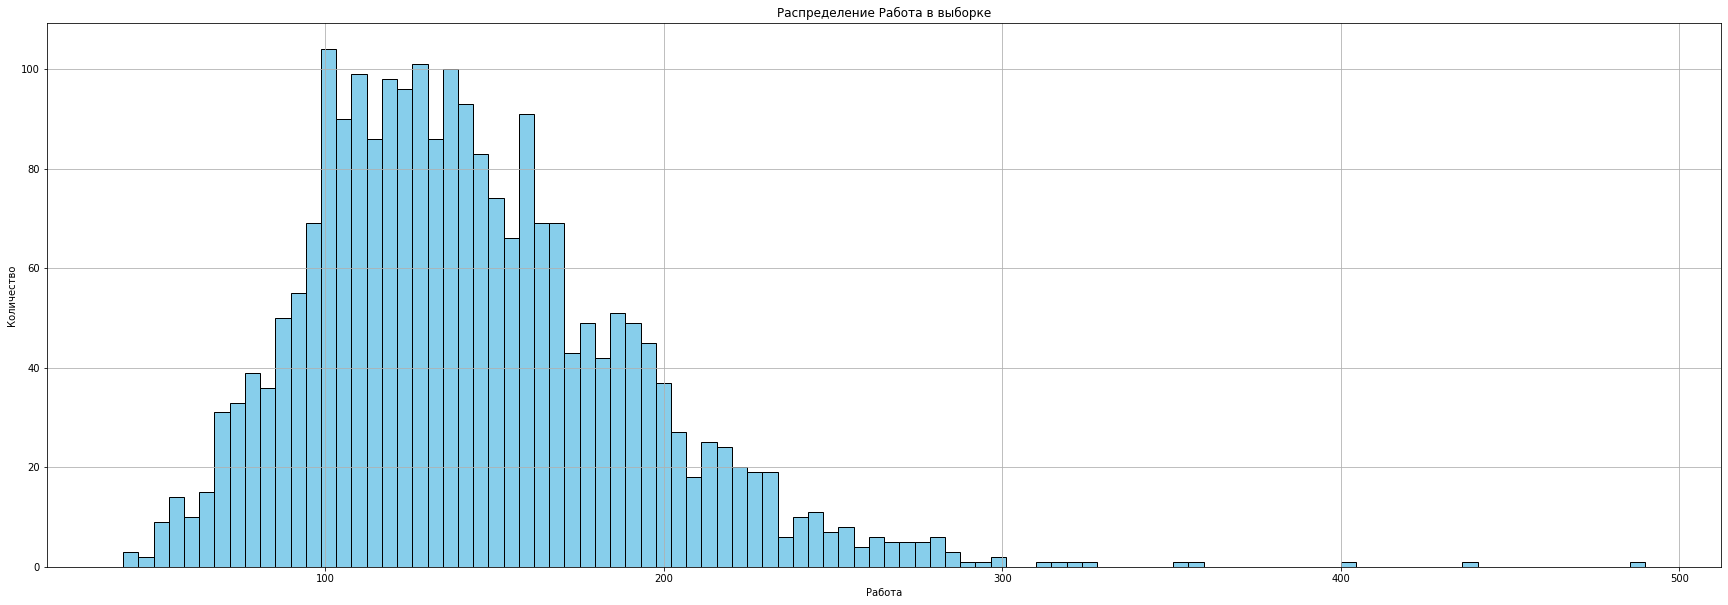

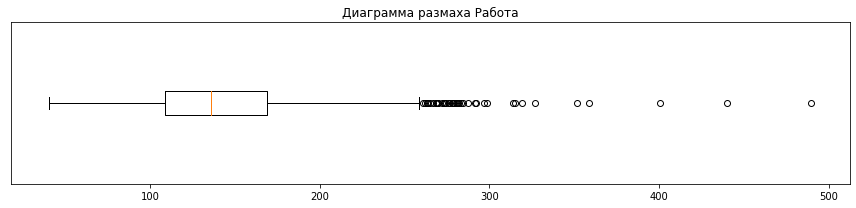

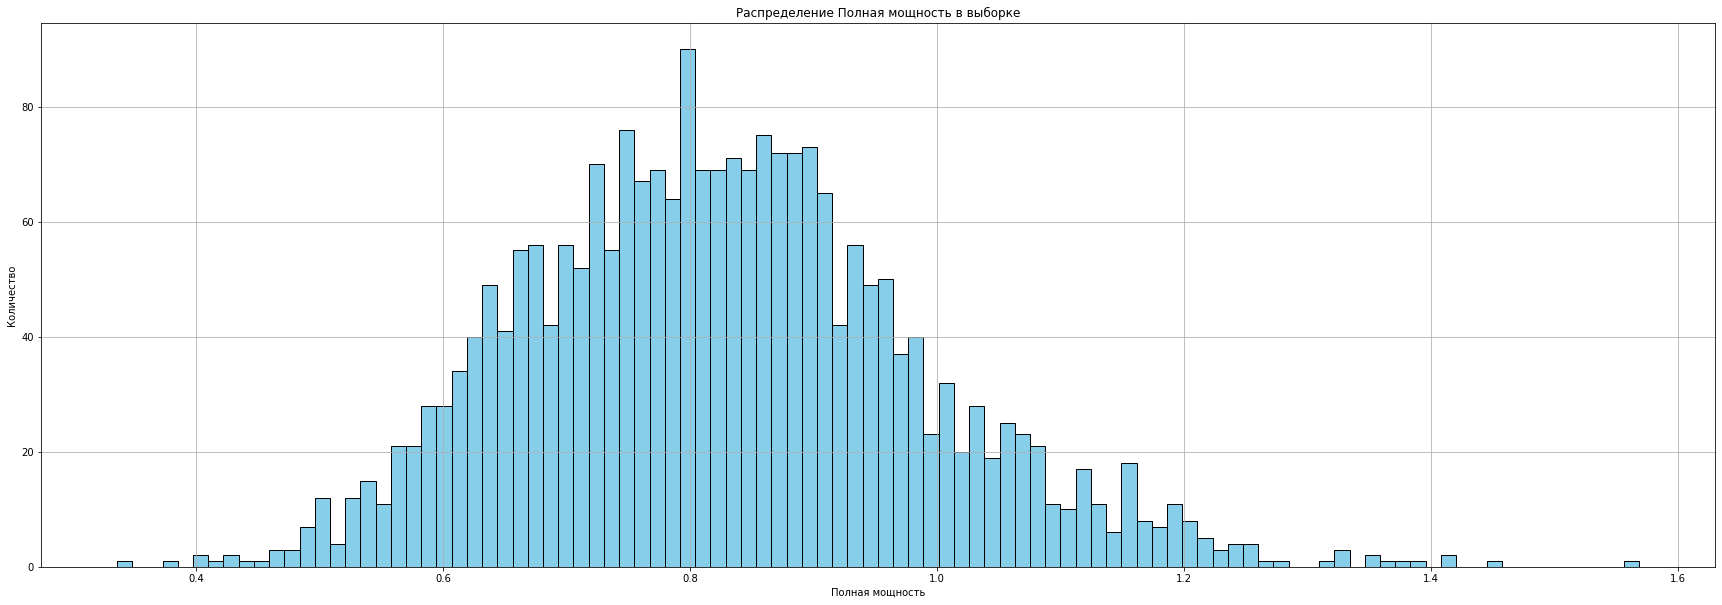

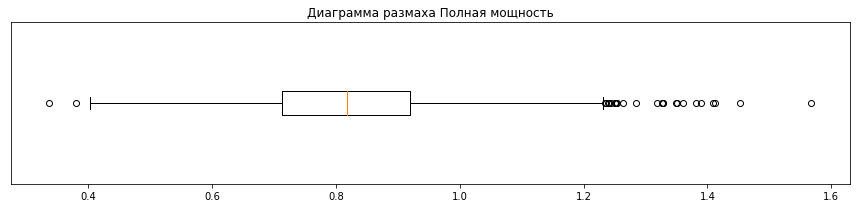

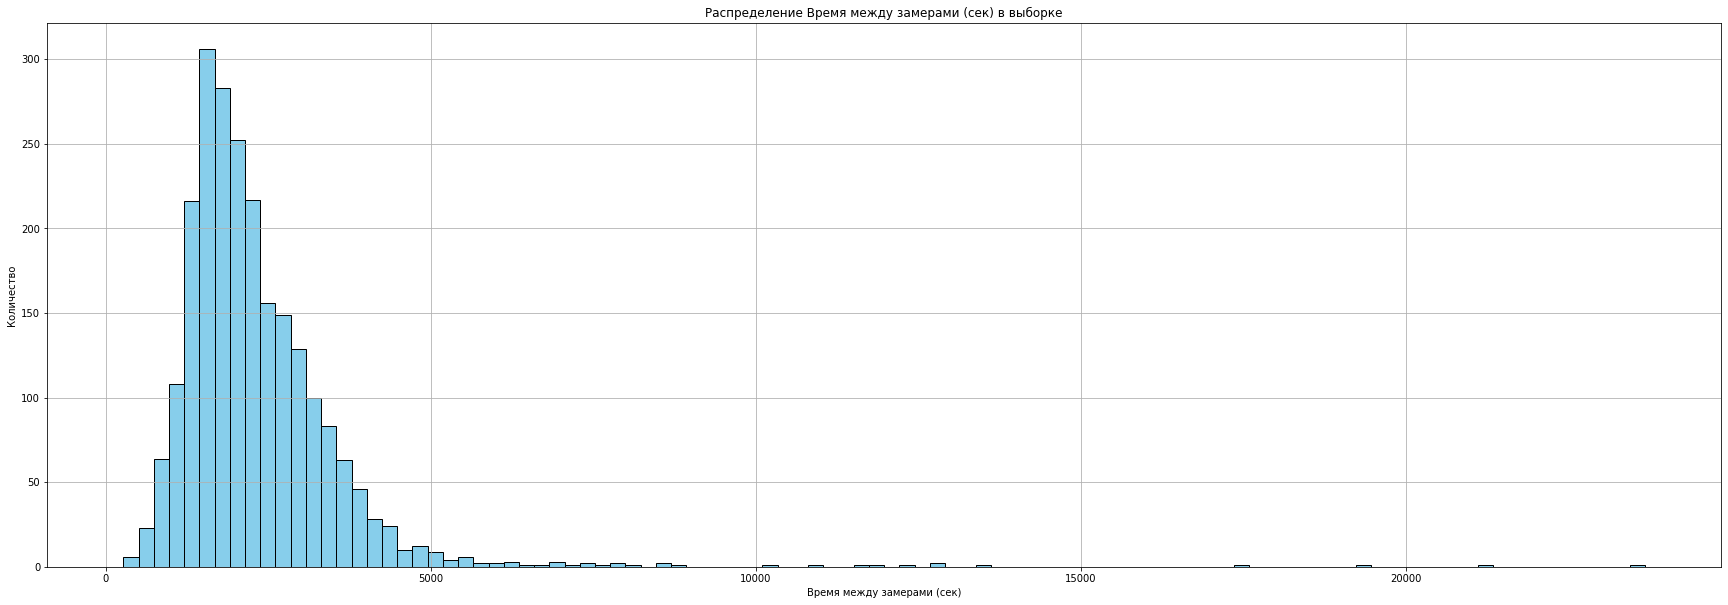

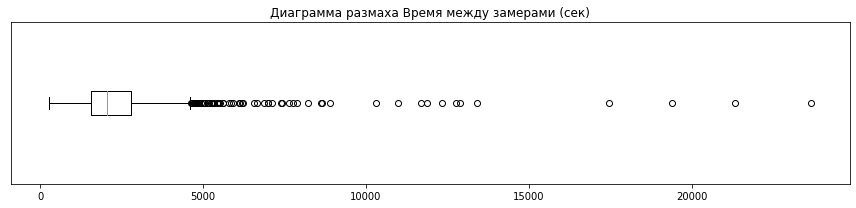

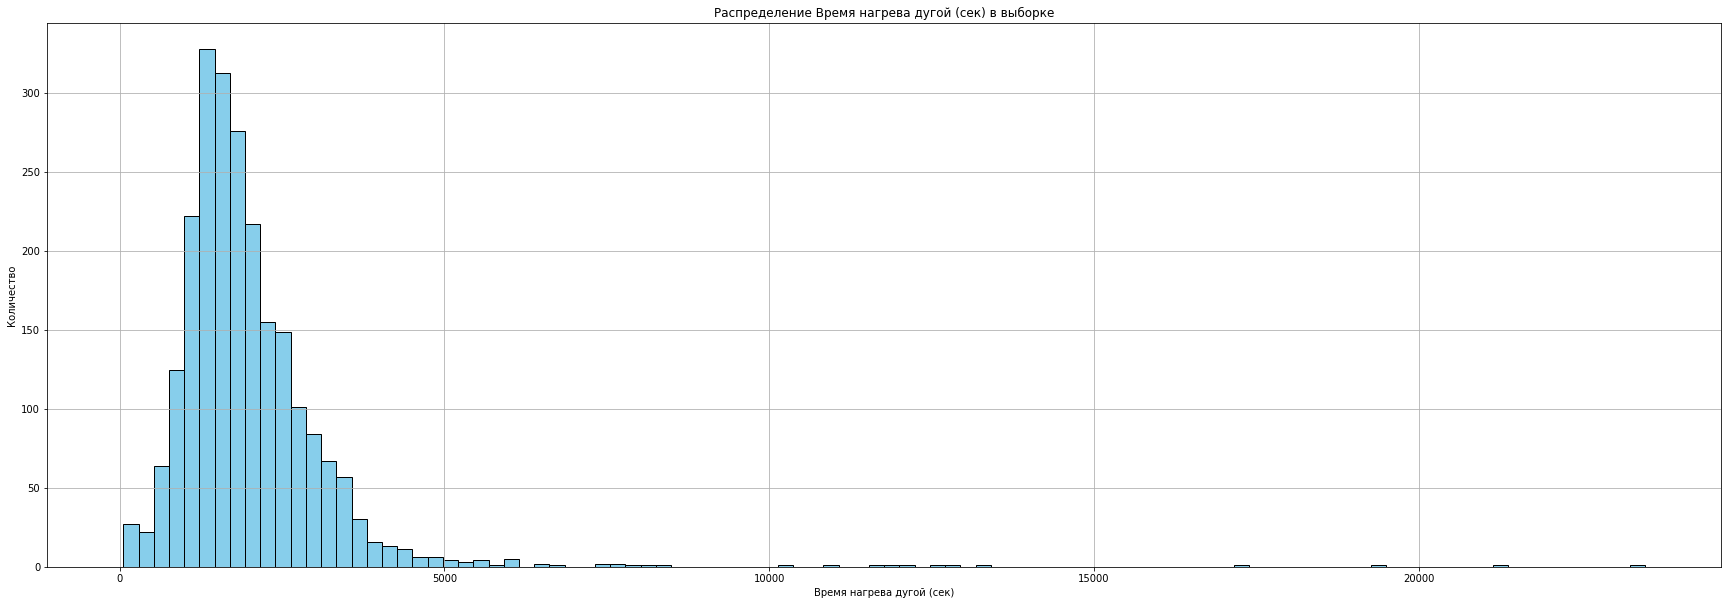

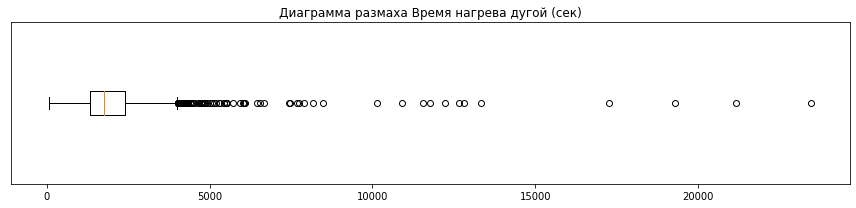

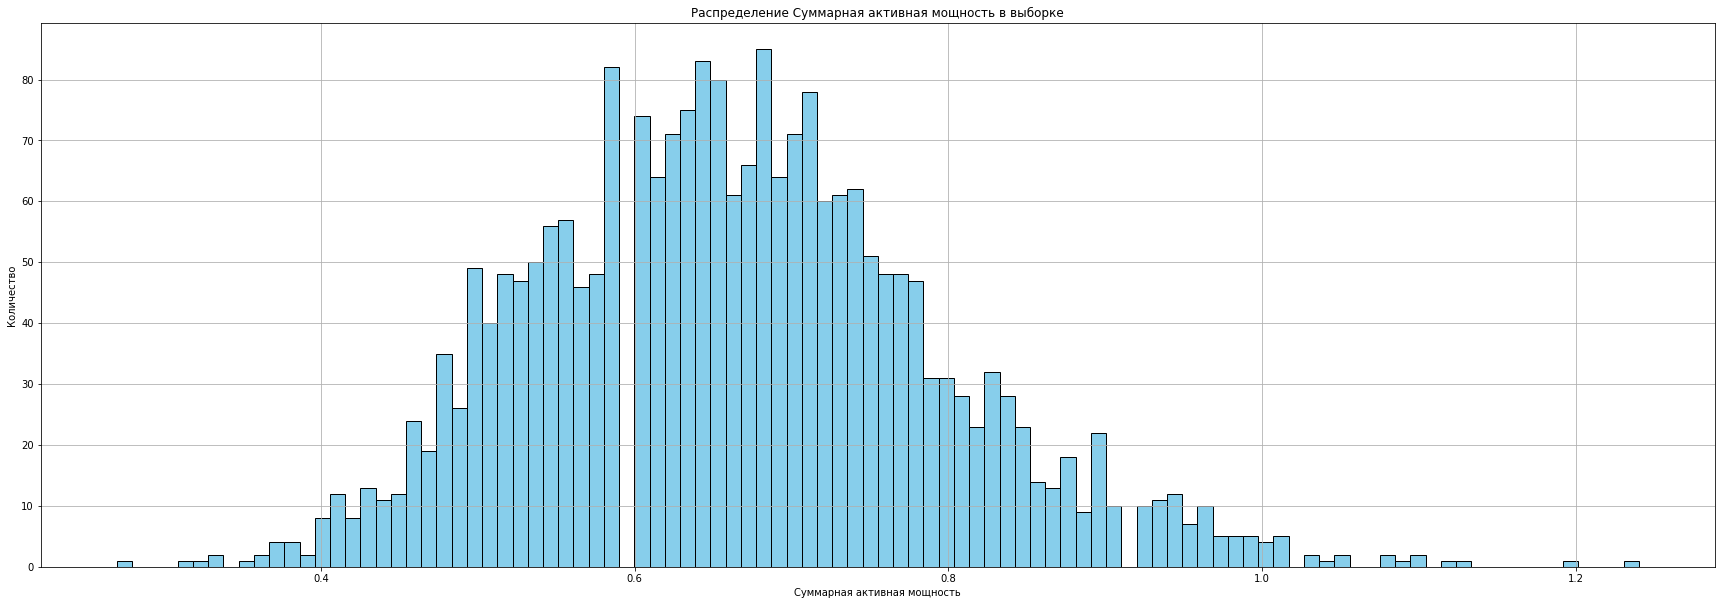

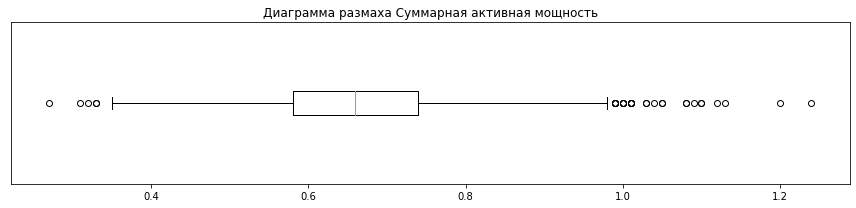

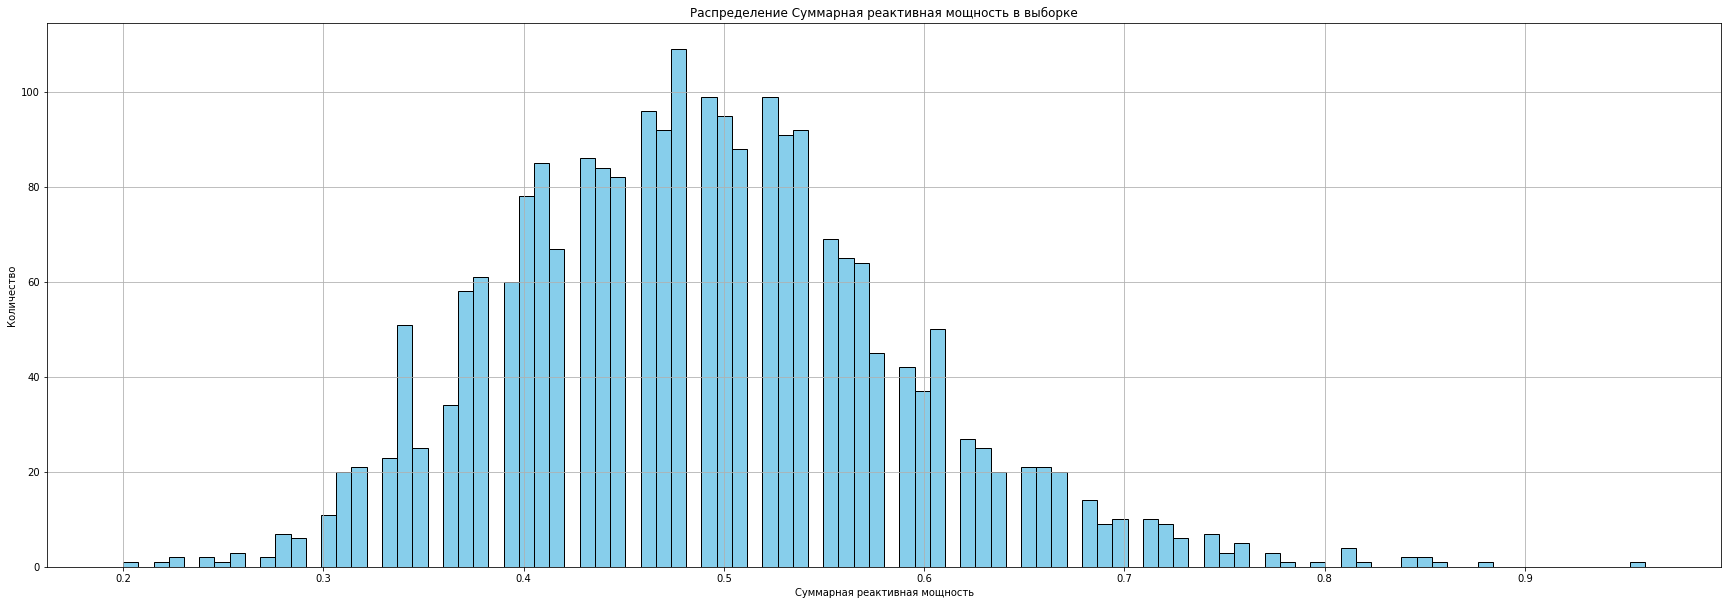

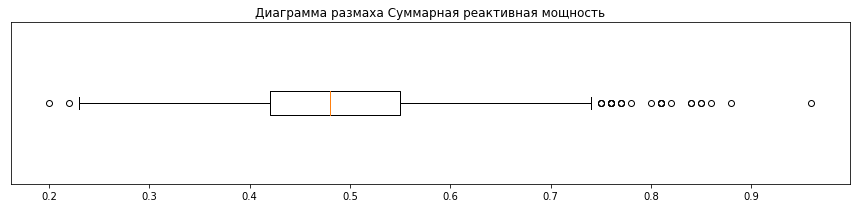

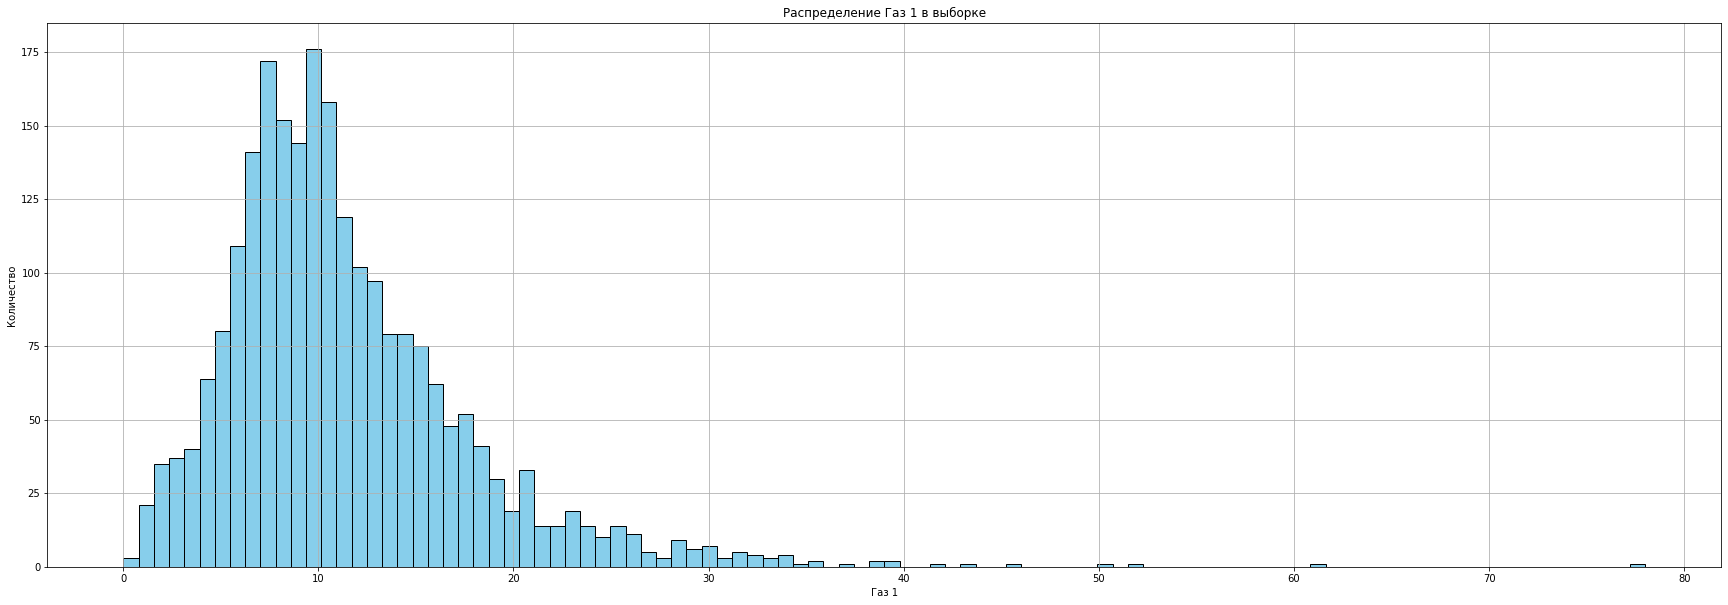

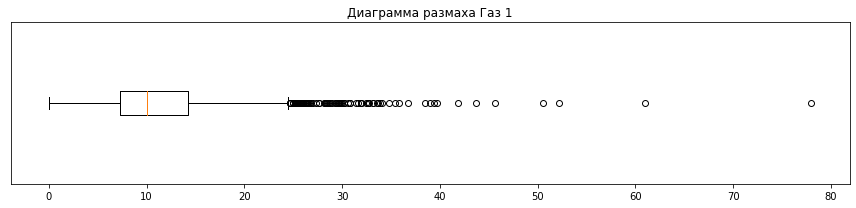

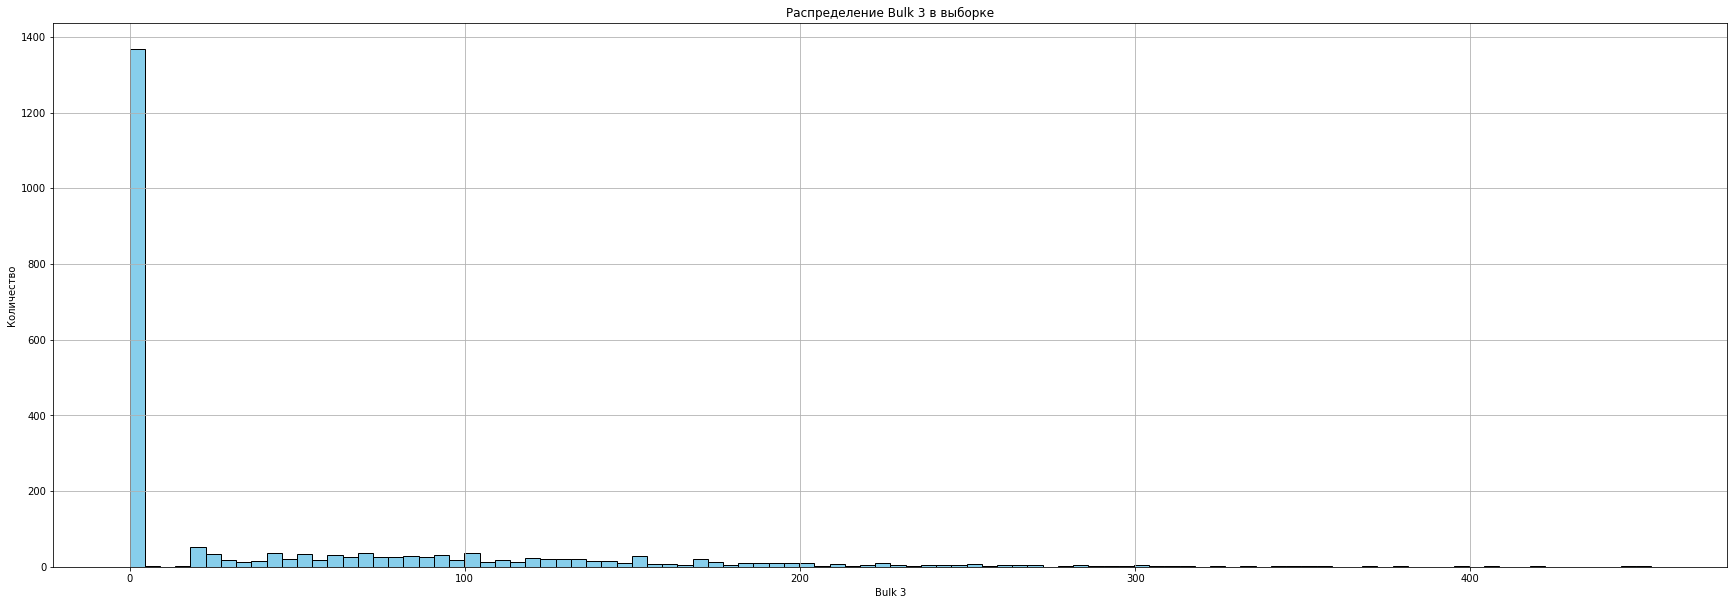

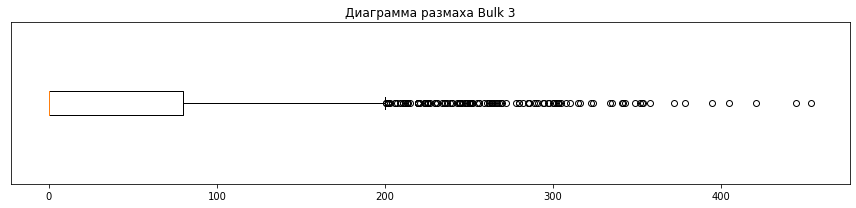

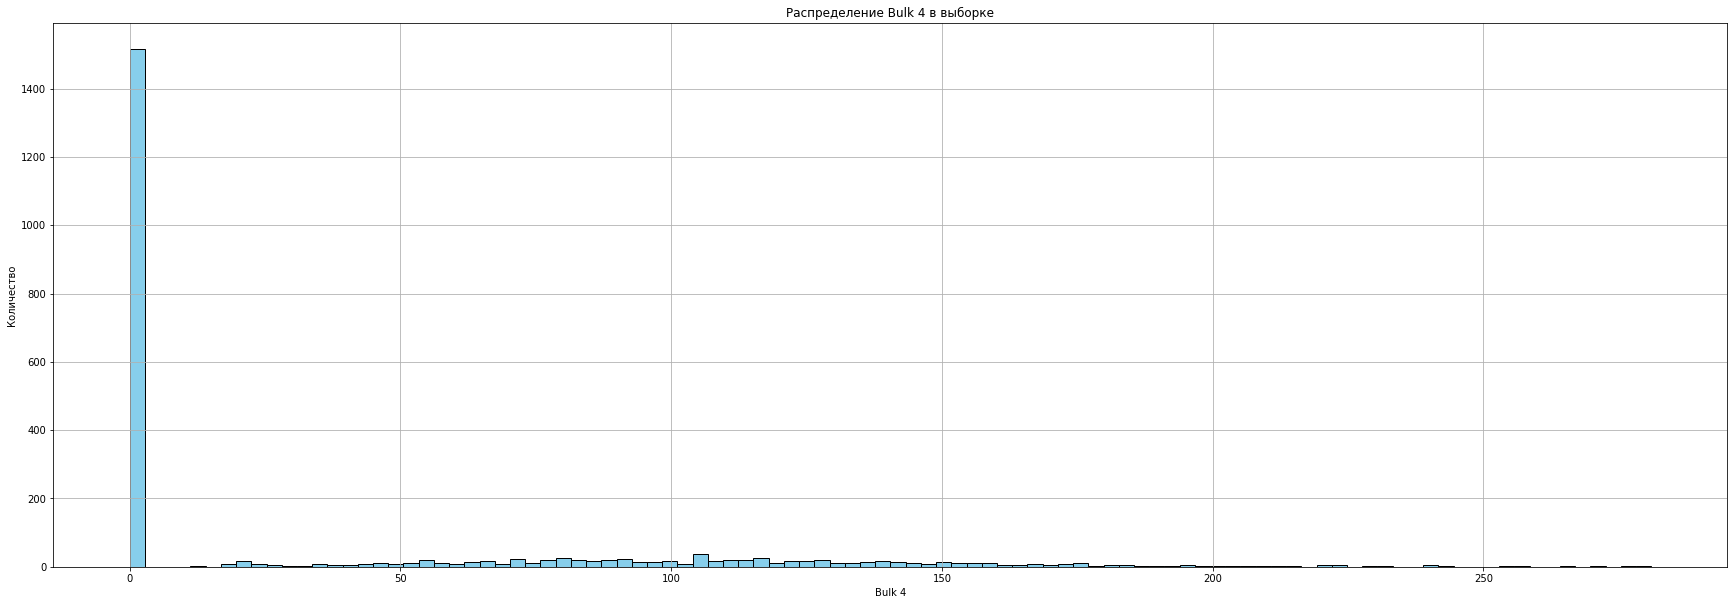

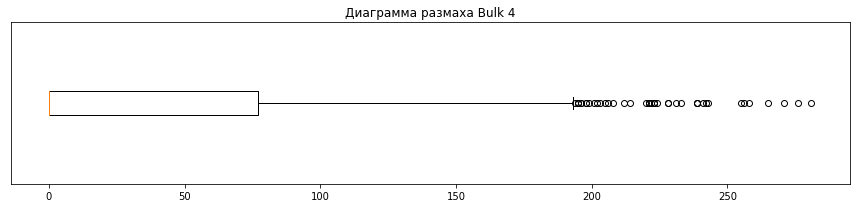

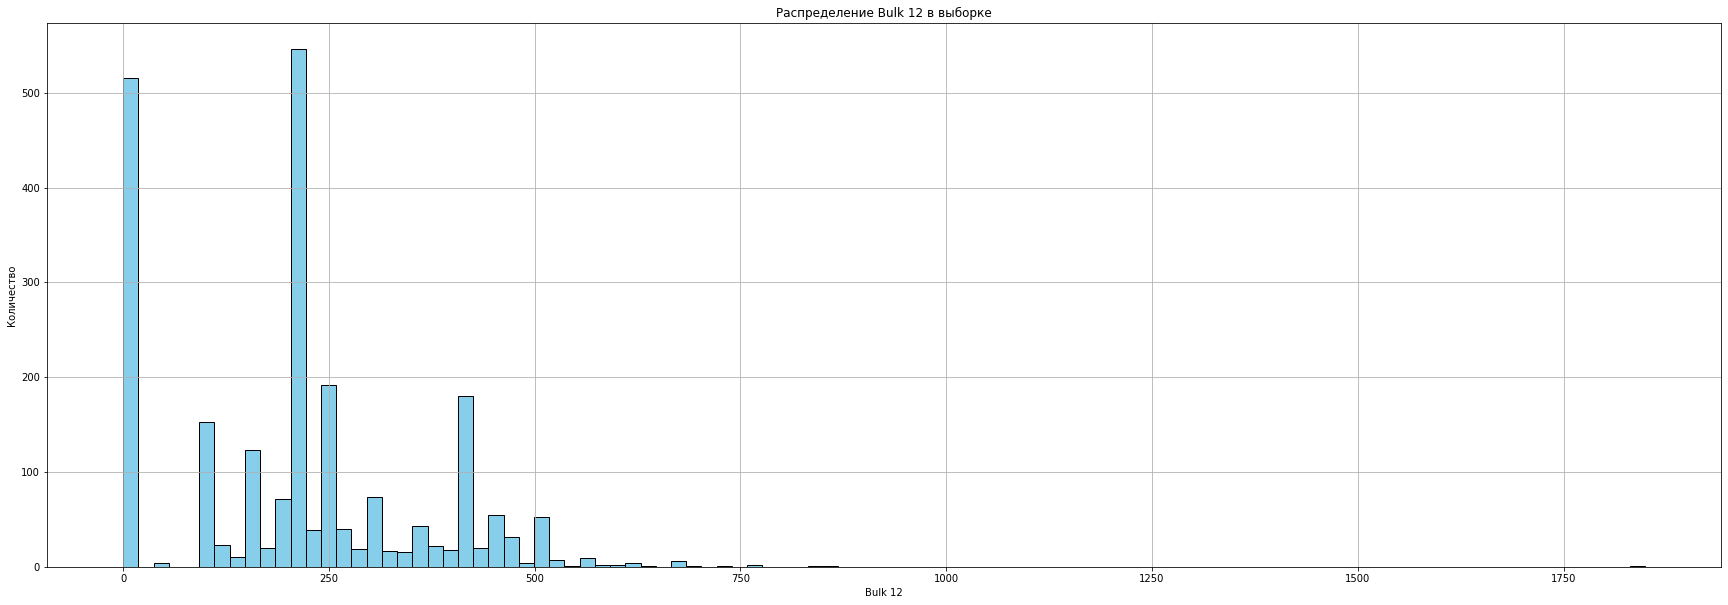

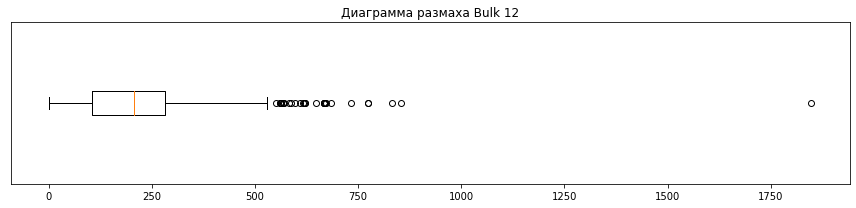

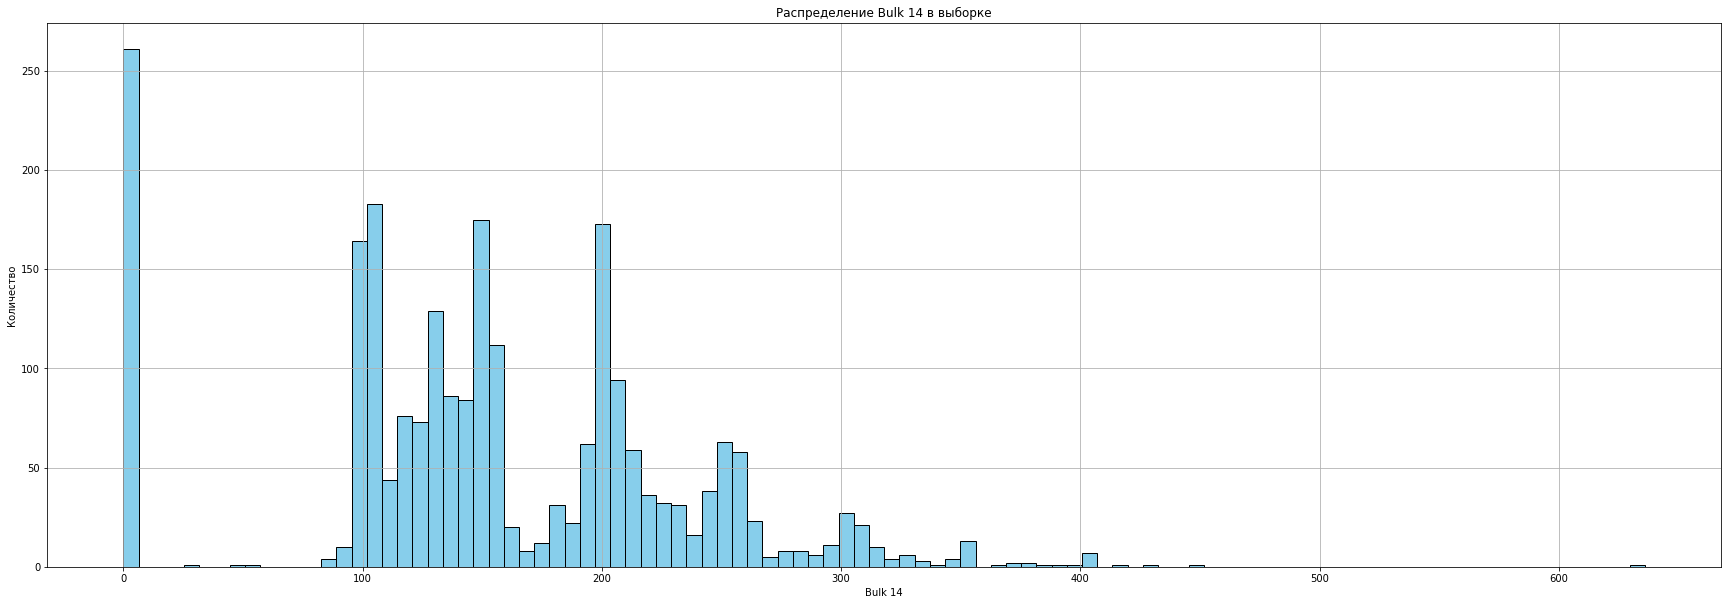

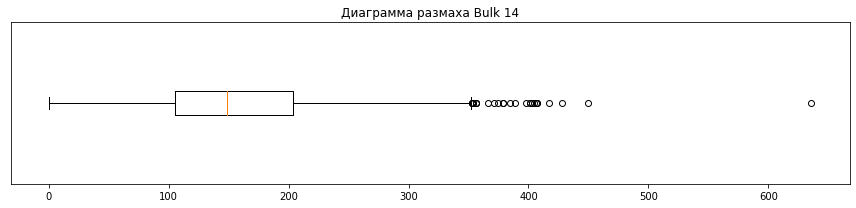

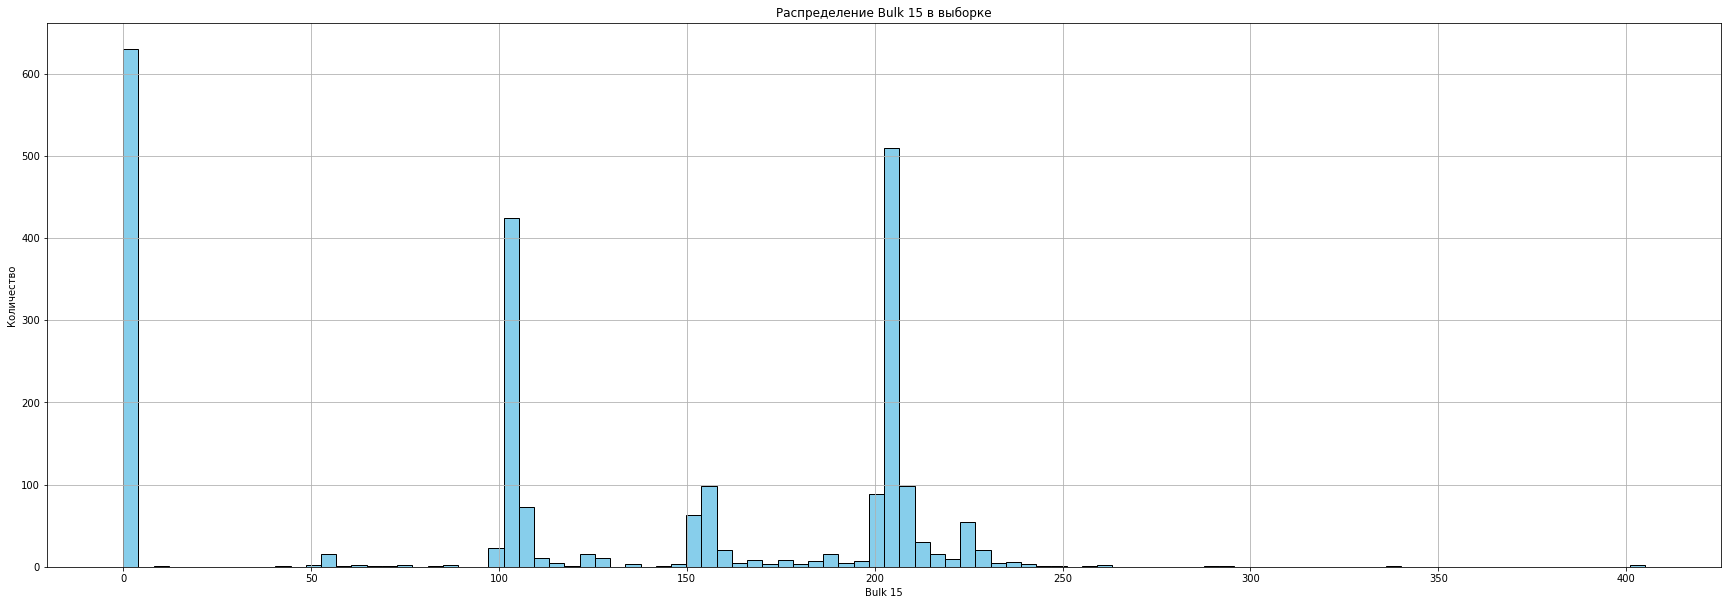

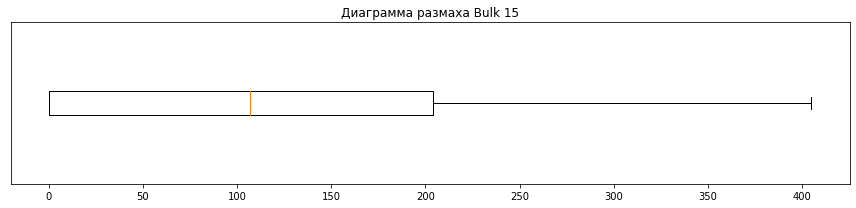

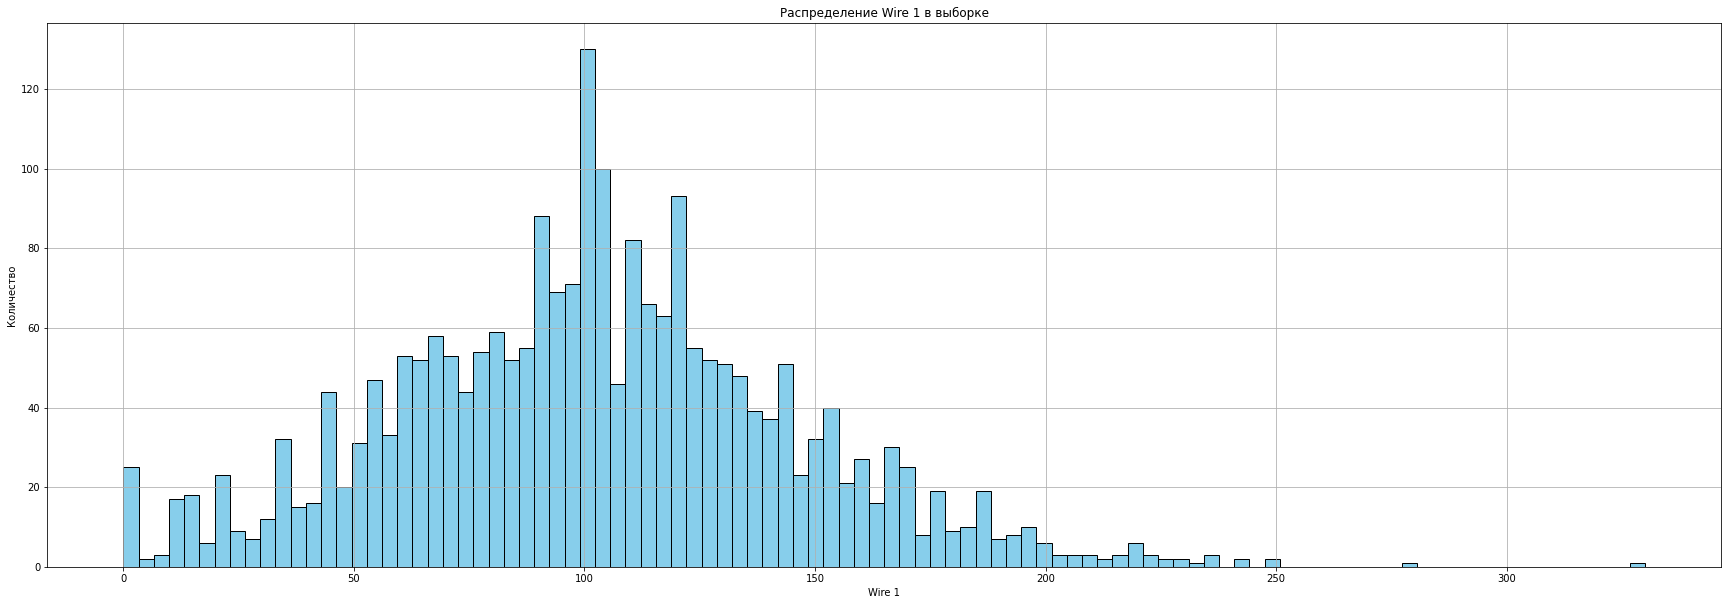

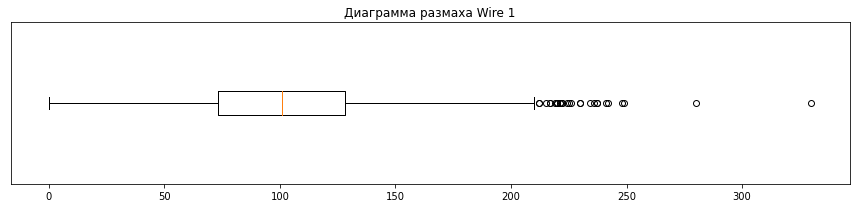

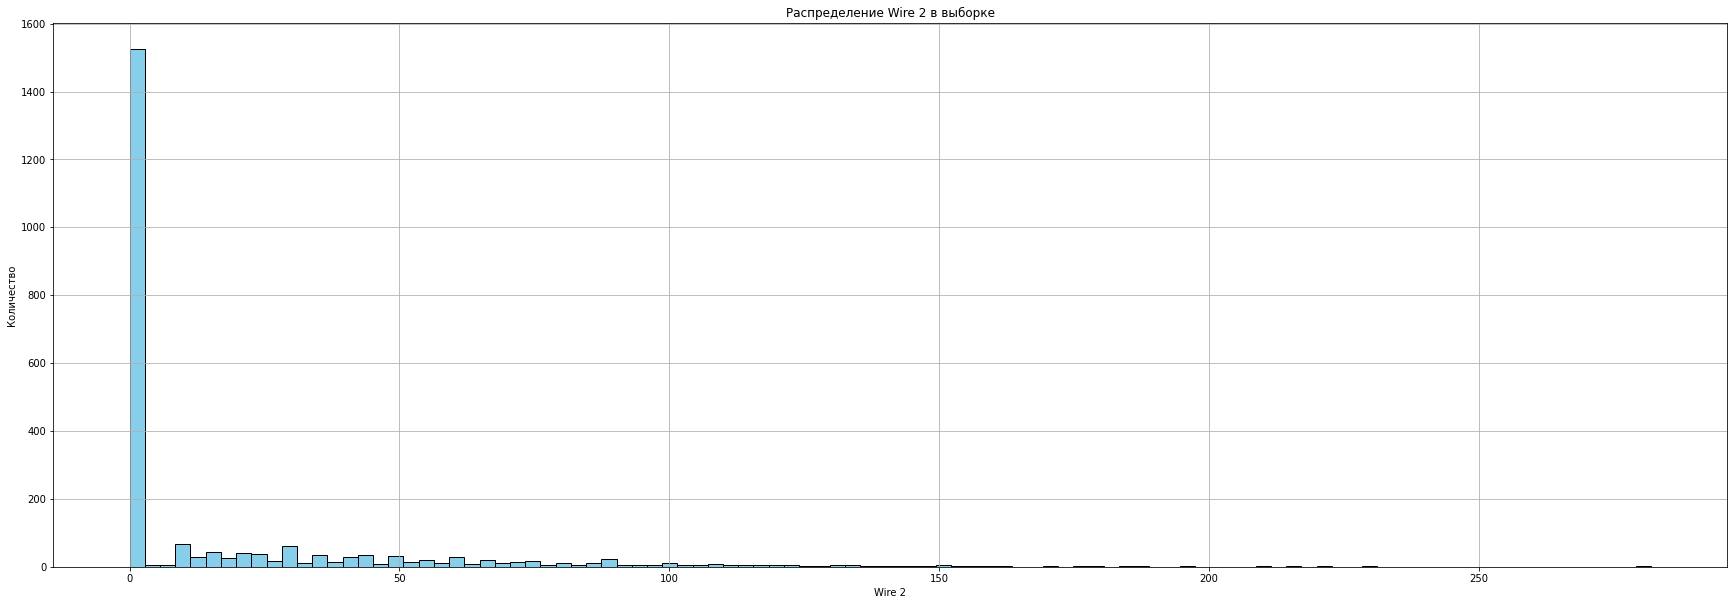

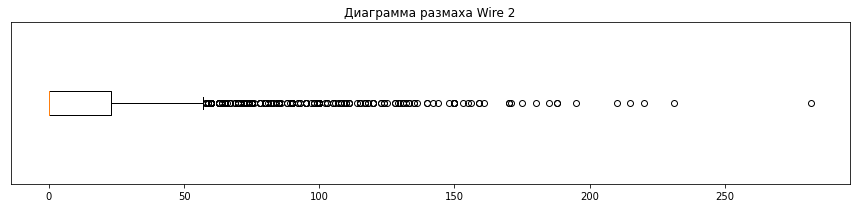

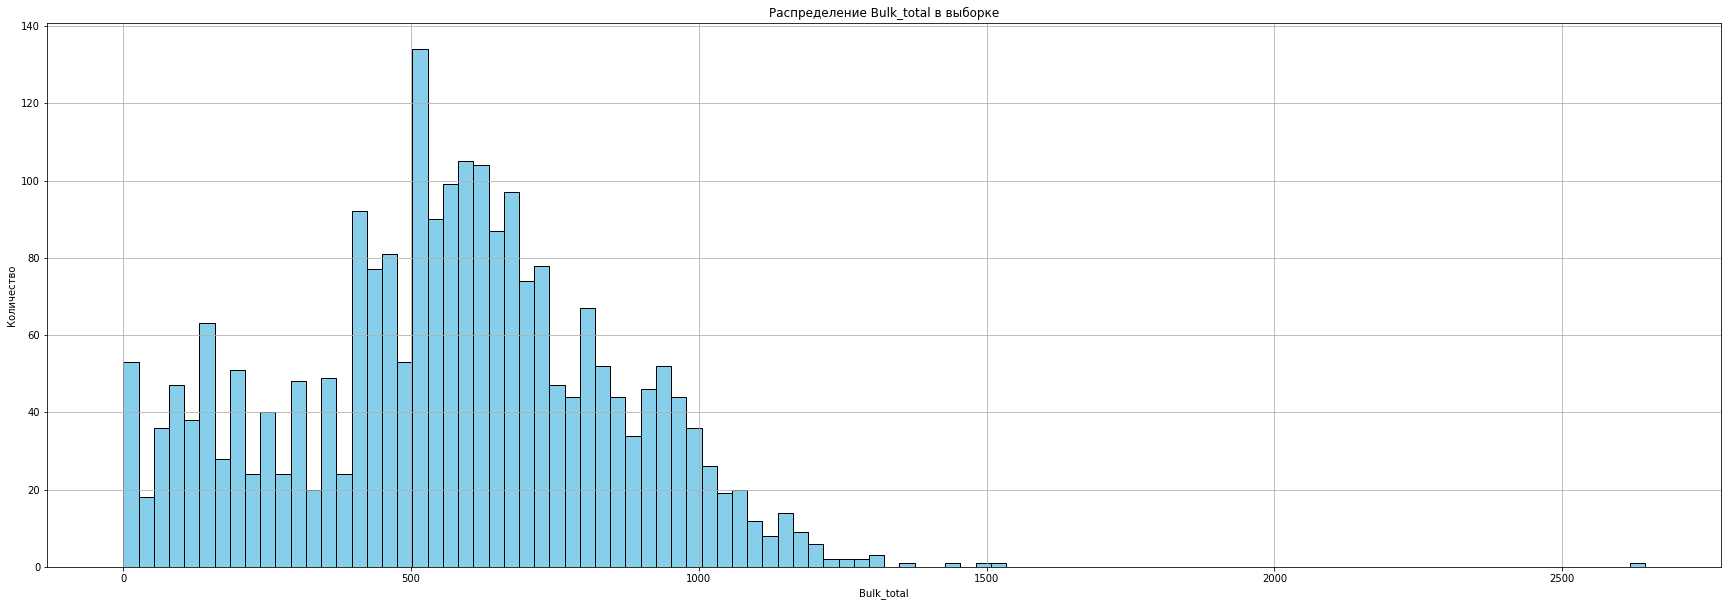

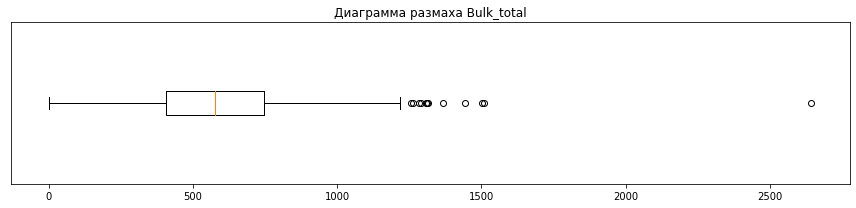

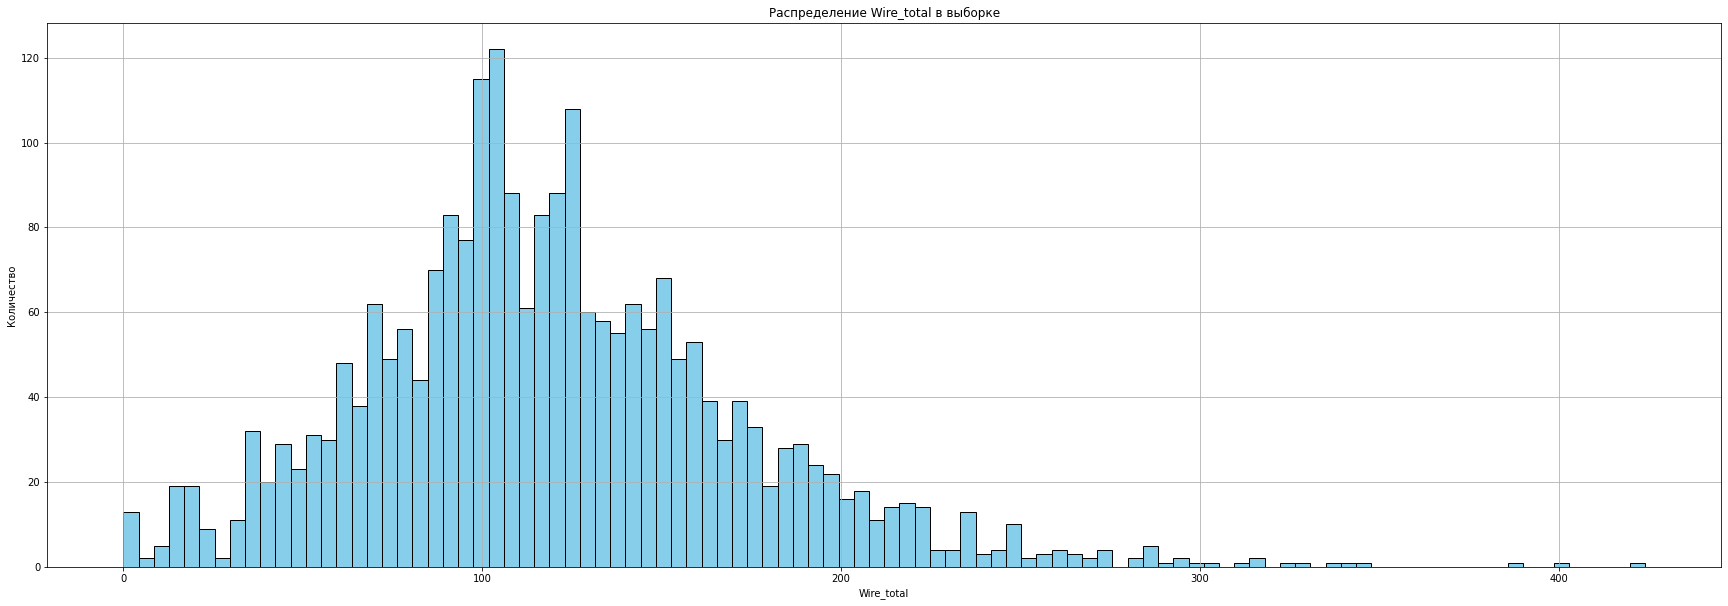

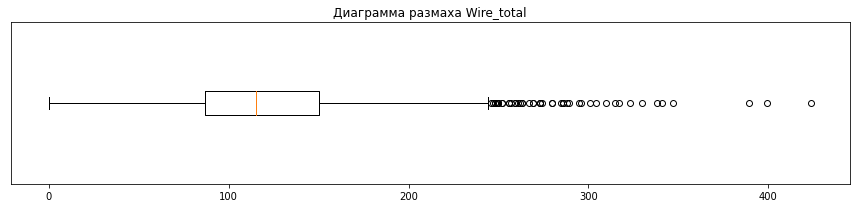

In [230]:
columns_to_plot = [
    'first_Температура', 'last_Температура', 'Работа', 
    'Полная мощность',
    'Время между замерами (сек)',
    'Время нагрева дугой (сек)',
    'Суммарная активная мощность',
    'Суммарная реактивная мощность',
    'Газ 1', 'Bulk 3','Bulk 4','Bulk 12','Bulk 14','Bulk 15', 'Wire 1', 'Wire 2','Bulk_total','Wire_total' ]


for column in columns_to_plot:
    plt.figure(figsize=(30, 10))
    plt.hist(result_df[column], bins=100, color='skyblue', edgecolor='black')
    plt.title(f'Распределение {column} в выборке')
    plt.xlabel(column)
    plt.ylabel('Количество')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 3))
    plt.boxplot(result_df[column], vert=False)
    plt.title(f'Диаграмма размаха {column}')
    plt.yticks([])
    plt.gca().invert_yaxis()  # Чтобы ось Y была сверху вниз

    plt.tight_layout()
    plt.show()

#### Корреляционный анализ

In [231]:
result_df.describe()

,first_Температура,last_Температура,Время между замерами (сек),Разница времени,Суммарная активная мощность,Суммарная реактивная мощность,Газ 1,Bulk 3,Bulk 4,Bulk 12,Bulk 14,Bulk 15,Bulk_total,Wire 1,Wire 2,Wire_total,Полная мощность,Работа,Время нагрева дугой (сек)
count,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000,2328.000000
mean,1587.389605,1593.371993,2322.071306,172.057939,0.664124,0.489003,11.375606,47.368557,37.319588,208.505155,153.834622,120.004296,567.032216,102.236684,17.544244,119.780928,0.824985,142.619894,1992.565292
std,23.624276,11.198791,1385.431810,43.731120,0.128362,0.098077,6.393494,75.320213,58.650737,157.036569,81.416698,84.622085,282.379502,43.508401,33.534142,53.078824,0.160248,47.323159,1350.525526
min,1519.000000,1541.000000,270.000000,57.000000,0.270000,0.200000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.336006,40.341702,57.000000
25%,1571.000000,1587.000000,1579.000000,141.000000,0.580000,0.420000,7.280000,0.000000,0.000000,105.000000,105.000000,0.000000,406.000000,73.000000,0.000000,87.000000,0.712811,108.934234,1323.750000
50%,1587.000000,1593.000000,2045.500000,169.500000,0.660000,0.480000,10.100000,0.000000,0.000000,206.000000,149.000000,107.000000,576.000000,101.000000,0.000000,115.000000,0.818413,136.217196,1744.500000
75%,1603.000000,1598.000000,2791.500000,198.750000,0.740000,0.550000,14.220000,80.000000,77.250000,282.250000,204.000000,204.000000,745.250000,128.000000,23.000000,150.000000,0.920054,168.956583,2397.000000
max,1660.000000,1653.000000,23674.000000,378.000000,1.240000,0.960000,78.000000,454.000000,281.000000,1849.000000,636.000000,405.000000,2644.000000,330.000000,282.000000,424.000000,1.568184,489.857385,23485.000000


In [232]:
result_df.corr()

,first_Температура,last_Температура,Время между замерами (сек),Разница времени,Суммарная активная мощность,Суммарная реактивная мощность,Газ 1,Bulk 3,Bulk 4,Bulk 12,Bulk 14,Bulk 15,Bulk_total,Wire 1,Wire 2,Wire_total,Полная мощность,Работа,Время нагрева дугой (сек)
first_Температура,1.000000,0.301241,0.209410,-0.438207,-0.008642,-0.002703,0.036052,-0.114034,0.164858,-0.080350,-0.181010,-0.063286,-0.112014,0.262639,-0.100777,0.151615,-0.006411,-0.019461,0.124415
last_Температура,0.301241,1.000000,0.096231,0.193440,0.039383,0.033790,0.059214,-0.036365,0.187687,0.266851,0.114991,0.265801,0.290492,0.317358,-0.206983,0.129369,0.037581,0.039187,0.114239
Время между замерами (сек),0.209410,0.096231,1.000000,0.056344,0.026224,0.025272,0.439322,0.022711,0.002589,0.210206,0.175068,0.099990,0.203935,0.153095,0.059970,0.163379,0.025851,-0.005513,0.966129
Разница времени,-0.438207,0.193440,0.056344,1.000000,0.034596,0.022658,0.102061,0.017792,-0.038965,0.370725,0.337946,0.280678,0.384370,-0.105883,-0.018683,-0.098595,0.030468,0.036430,0.102710
Суммарная активная мощность,-0.008642,0.039383,0.026224,0.034596,1.000000,0.964707,0.040860,0.027504,0.022464,0.038644,0.021231,0.039592,0.051479,0.035801,-0.014147,0.020408,0.995377,0.583446,0.029438
Суммарная реактивная мощность,-0.002703,0.033790,0.025272,0.022658,0.964707,1.000000,0.041549,0.023085,0.024370,0.042688,0.016465,0.038359,0.051201,0.043139,-0.014733,0.026053,0.985529,0.577507,0.027933
Газ 1,0.036052,0.059214,0.439322,0.102061,0.040860,0.041549,1.000000,0.059648,0.017595,0.217451,0.268907,0.043675,0.231114,0.117270,0.104342,0.162047,0.041236,0.010724,0.450406
Bulk 3,-0.114034,-0.036365,0.022711,0.017792,0.027504,0.023085,0.059648,1.000000,-0.295654,0.018021,0.010920,-0.013250,0.214526,0.039458,0.095697,0.092803,0.026102,0.028027,0.038120
Bulk 4,0.164858,0.187687,0.002589,-0.038965,0.022464,0.024370,0.017595,-0.295654,1.000000,0.105477,-0.090467,0.101180,0.191736,0.297563,-0.268267,0.074425,0.023285,-0.001676,-0.002782
Bulk 12,-0.080350,0.266851,0.210206,0.370725,0.038644,0.042688,0.217451,0.018021,0.105477,1.000000,0.482063,0.614169,0.905875,0.170006,-0.098466,0.077144,0.040215,0.034836,0.252364


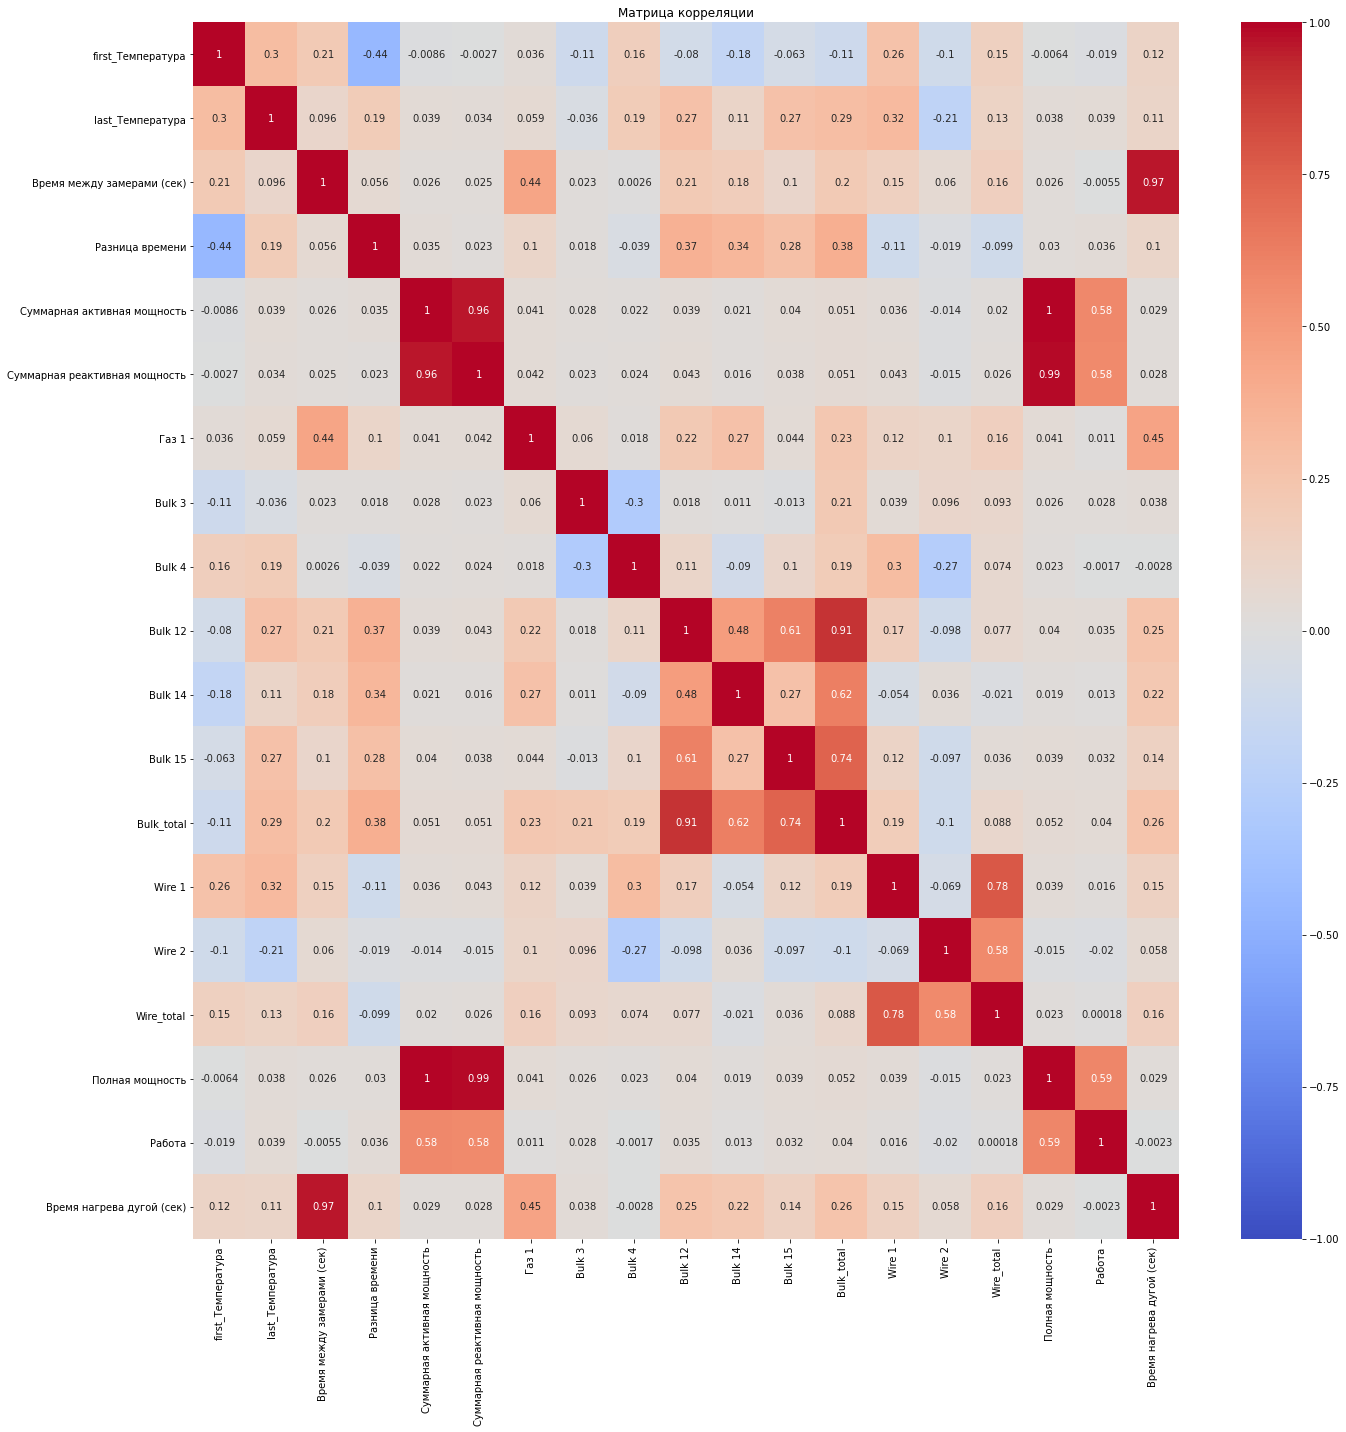

In [233]:
plt.figure(figsize=(20, 20))
sns.heatmap(result_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Матрица корреляции')
plt.tight_layout()
plt.show()


In [234]:
result_df.head()

,first_Температура,last_Температура,Время между замерами (сек),Начало нагрева дугой,Конец нагрева дугой,Разница времени,Суммарная активная мощность,Суммарная реактивная мощность,Газ 1,Bulk 3,...,Bulk 12,Bulk 14,Bulk 15,Bulk_total,Wire 1,Wire 2,Wire_total,Полная мощность,Работа,Время нагрева дугой (сек)
0,1571.0,1613.0,1714.0,2019-05-03 11:02:14,2019-05-03 11:28:37,219.60,0.61,0.43,29.75,0,...,206,150,154,553,60,0,60,0.746324,163.892822,1583.0
1,1581.0,1602.0,1265.0,2019-05-03 11:34:14,2019-05-03 11:53:18,202.75,0.53,0.36,12.56,0,...,206,149,154,582,96,0,96,0.640703,129.902480,1144.0
2,1596.0,1599.0,1753.0,2019-05-03 12:06:54,2019-05-03 12:32:19,131.00,0.81,0.59,28.55,0,...,205,152,153,544,91,0,91,1.002098,131.274812,1525.0
3,1601.0,1625.0,1220.0,2019-05-03 12:39:37,2019-05-03 12:57:50,185.25,0.68,0.51,18.84,0,...,207,153,154,595,89,0,89,0.850000,157.462500,1093.0
4,1576.0,1602.0,1536.0,2019-05-03 13:11:13,2019-05-03 13:33:55,217.25,0.56,0.42,5.41,0,...,203,151,152,584,89,9,98,0.700000,152.075000,1362.0


#### Разделение на выборки

In [235]:


# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    result_df.drop(['last_Температура'], axis=1),
    result_df['last_Температура'],
    test_size=0.25,
    random_state=91224
)


In [236]:
X_train.shape

(1746, 20)

In [237]:
train_df = pd.concat([X_train, y_train], axis=1)

In [238]:
train_df.head()

,first_Температура,Время между замерами (сек),Начало нагрева дугой,Конец нагрева дугой,Разница времени,Суммарная активная мощность,Суммарная реактивная мощность,Газ 1,Bulk 3,Bulk 4,...,Bulk 14,Bulk 15,Bulk_total,Wire 1,Wire 2,Wire_total,Полная мощность,Работа,Время нагрева дугой (сек),last_Температура
137,1600.0,2843.0,2019-05-09 15:16:40,2019-05-09 15:55:08,183.250000,0.61,0.45,6.57,0,0,...,159,0,159,20,0,20,0.758024,75.802375,2308.0,1602.0
1804,1596.0,2886.0,2019-07-19 17:18:45,2019-07-19 18:00:10,184.400000,0.67,0.51,19.12,304,0,...,99,104,713,15,35,50,0.842021,105.926289,2485.0,1588.0
1056,1566.0,1359.0,2019-06-16 04:10:22,2019-06-16 04:31:03,229.500000,0.81,0.54,5.82,221,0,...,102,102,629,114,0,114,0.973499,151.541320,1241.0,1604.0
1222,1579.0,1750.0,2019-06-21 23:13:12,2019-06-21 23:39:45,143.166667,0.64,0.45,8.29,50,0,...,0,0,50,71,11,82,0.782368,124.865965,1593.0,1606.0
1285,1571.0,1321.0,2019-06-24 14:47:40,2019-06-24 15:07:43,154.000000,0.49,0.37,4.12,0,0,...,179,145,603,35,0,35,0.614003,99.714129,1203.0,1590.0


In [239]:
train_df.shape

(1746, 21)

In [240]:
train_df.describe()

,first_Температура,Время между замерами (сек),Разница времени,Суммарная активная мощность,Суммарная реактивная мощность,Газ 1,Bulk 3,Bulk 4,Bulk 12,Bulk 14,Bulk 15,Bulk_total,Wire 1,Wire 2,Wire_total,Полная мощность,Работа,Время нагрева дугой (сек),last_Температура
count,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000,1746.000000
mean,1587.647194,2328.107102,171.763024,0.664954,0.489908,11.470384,47.181558,38.498855,206.027491,154.063001,119.041810,564.812715,102.252005,17.415235,119.667239,0.826192,143.266341,2001.402635,1593.459336
std,23.532684,1411.382124,43.891539,0.130284,0.099546,6.536436,75.440200,58.992674,158.424736,81.798477,84.614792,285.893760,44.422877,33.648392,53.342864,0.162680,47.763503,1376.925895,11.236188
min,1520.000000,270.000000,57.000000,0.270000,0.200000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.336006,40.341702,57.000000,1541.000000
25%,1571.000000,1576.250000,141.000000,0.572500,0.420000,7.300000,0.000000,0.000000,105.000000,106.000000,0.000000,391.500000,71.000000,0.000000,86.000000,0.710756,109.058339,1321.000000,1587.000000
50%,1587.000000,2053.000000,169.000000,0.660000,0.490000,10.150000,0.000000,0.000000,206.000000,149.000000,106.000000,573.000000,100.000000,0.000000,114.000000,0.819237,136.502798,1756.500000,1593.000000
75%,1603.000000,2770.500000,197.833333,0.740000,0.550000,14.277500,79.000000,81.000000,280.000000,205.000000,204.000000,749.750000,128.000000,22.000000,150.000000,0.924175,170.023406,2391.250000,1598.000000
max,1660.000000,23674.000000,378.000000,1.240000,0.960000,78.000000,454.000000,271.000000,1849.000000,636.000000,405.000000,2644.000000,330.000000,282.000000,424.000000,1.568184,489.857385,23485.000000,1653.000000


### Очистка тренировачного датасета

In [241]:
print(f"Количество строк после очистки: {len(train_df)}")

Количество строк после очистки: 1746


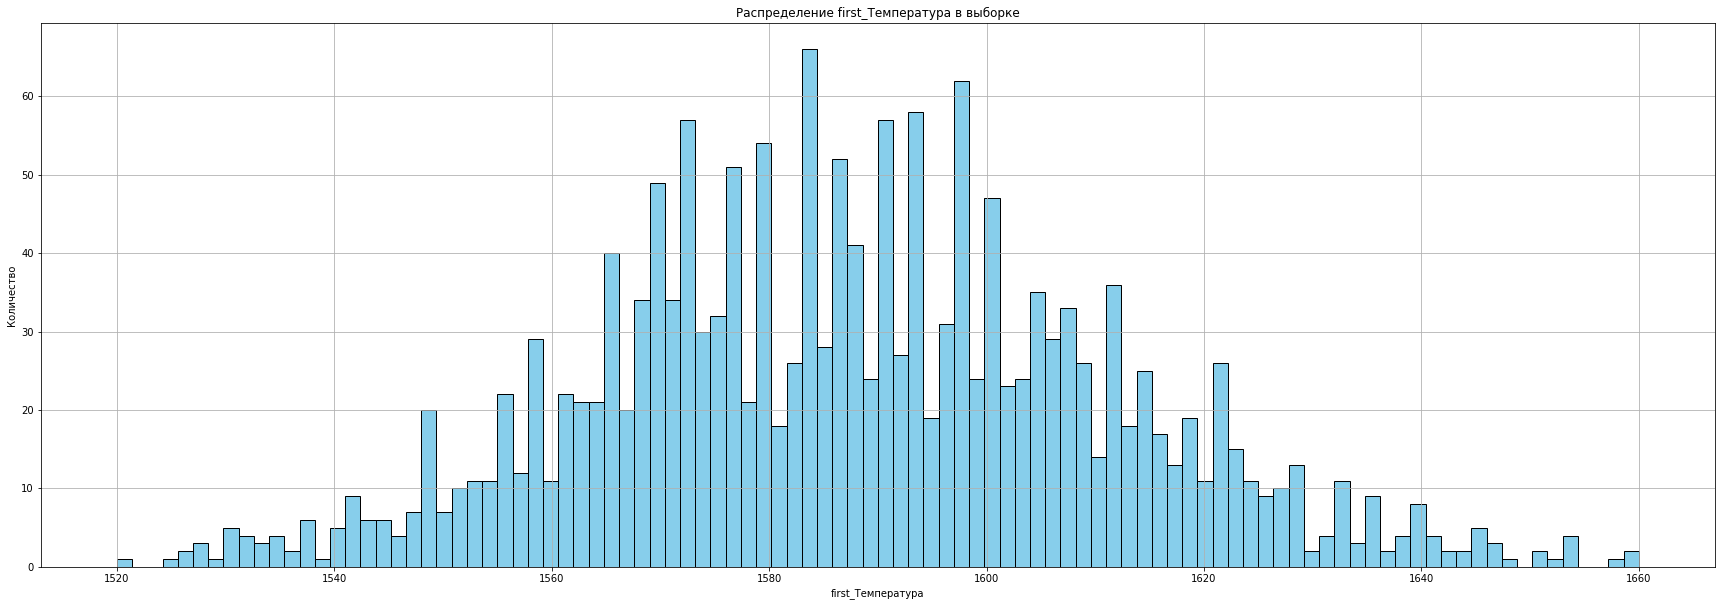

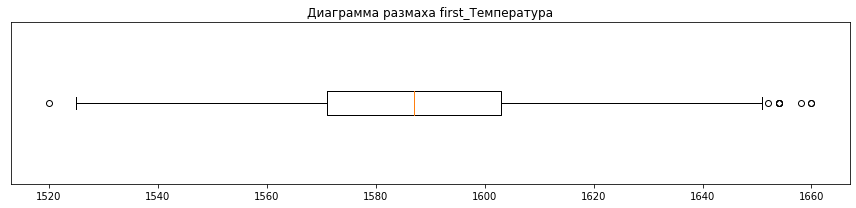

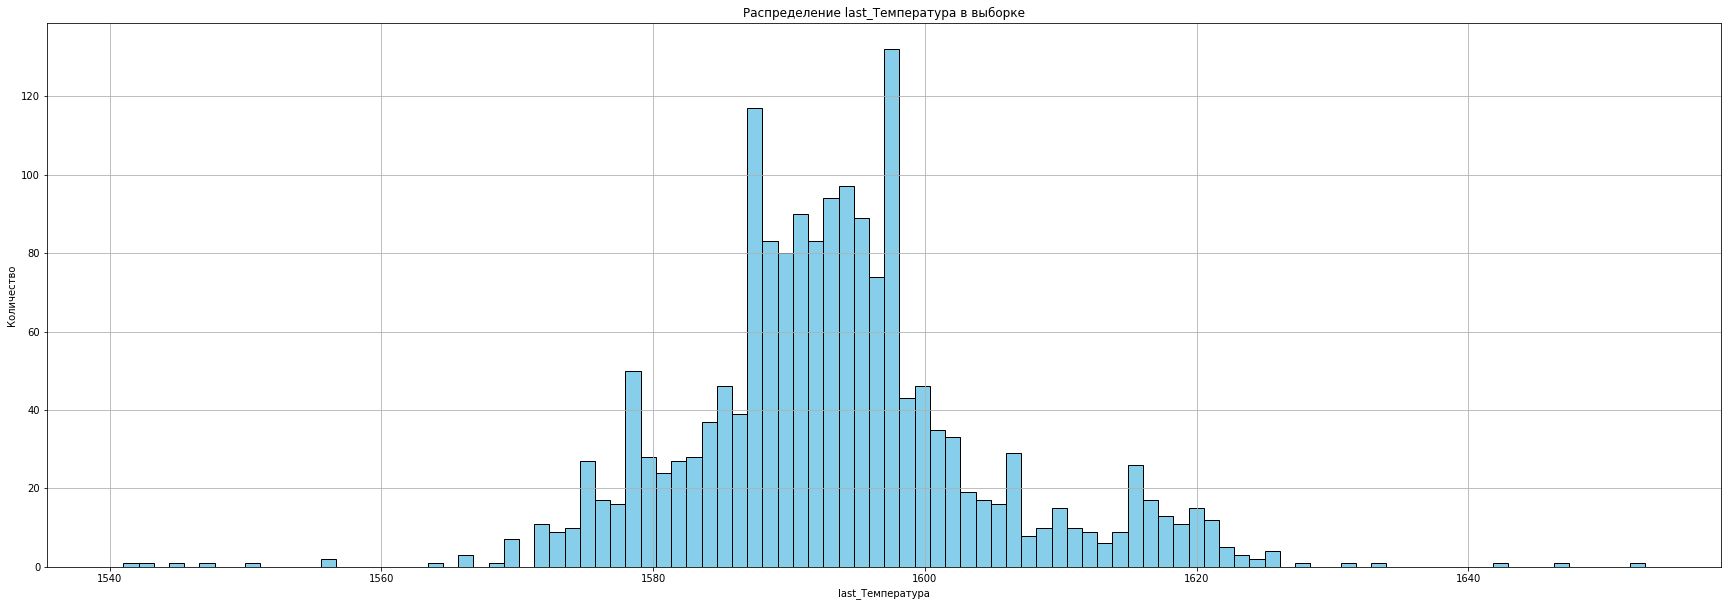

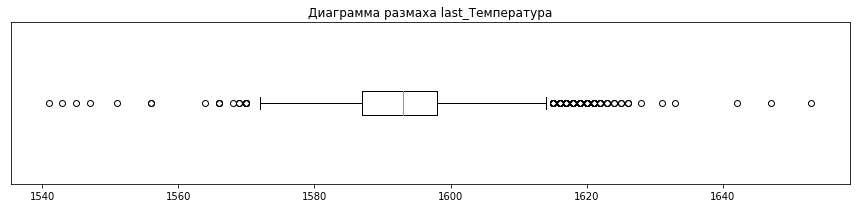

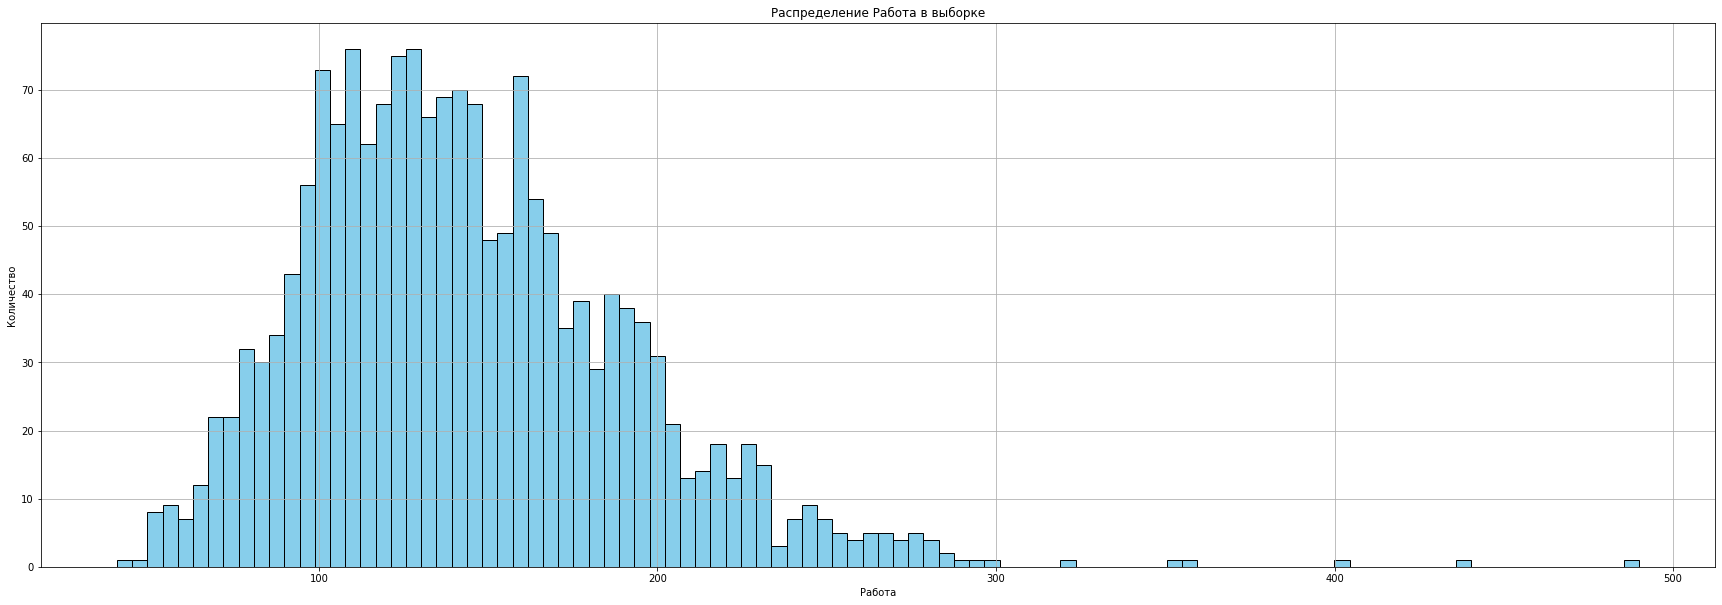

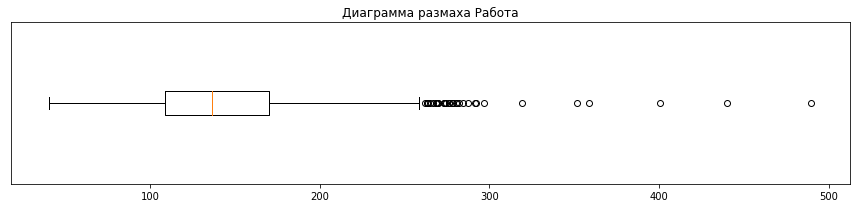

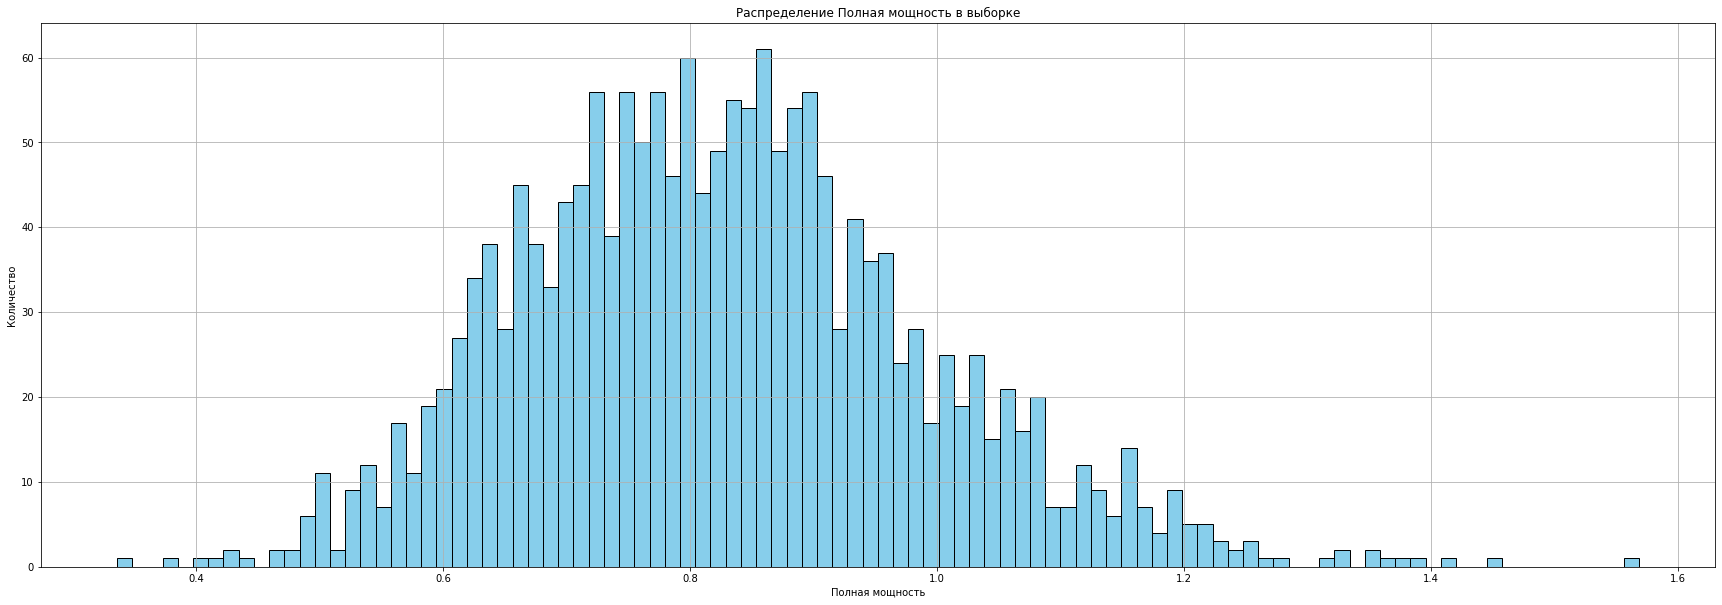

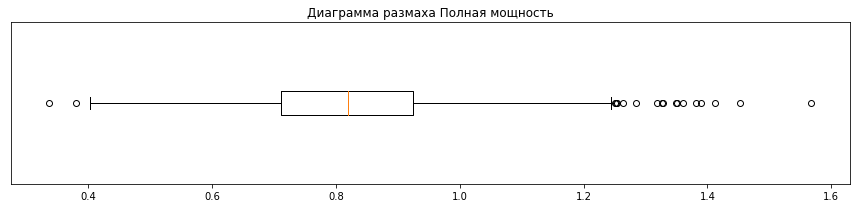

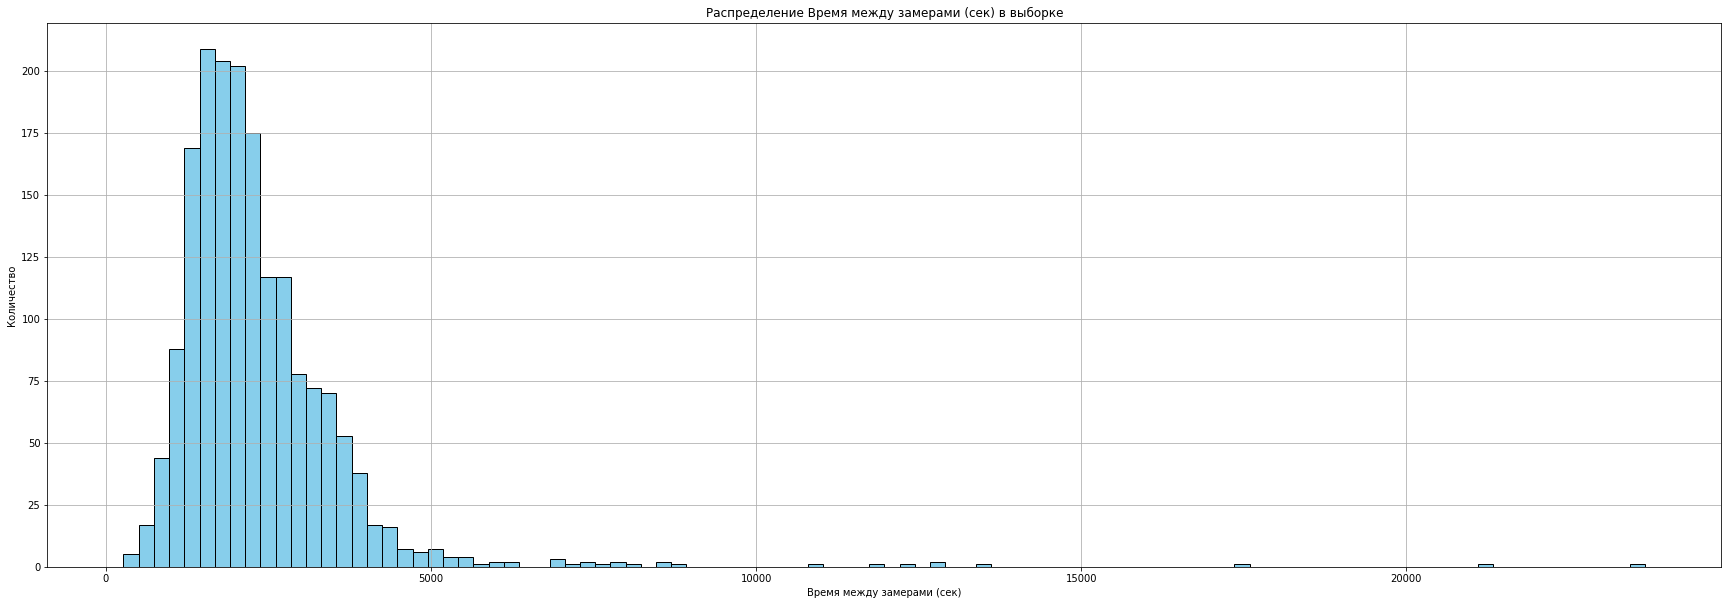

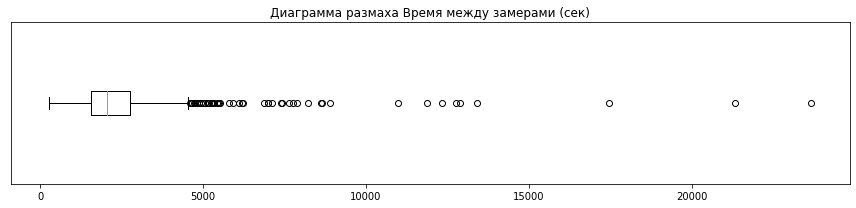

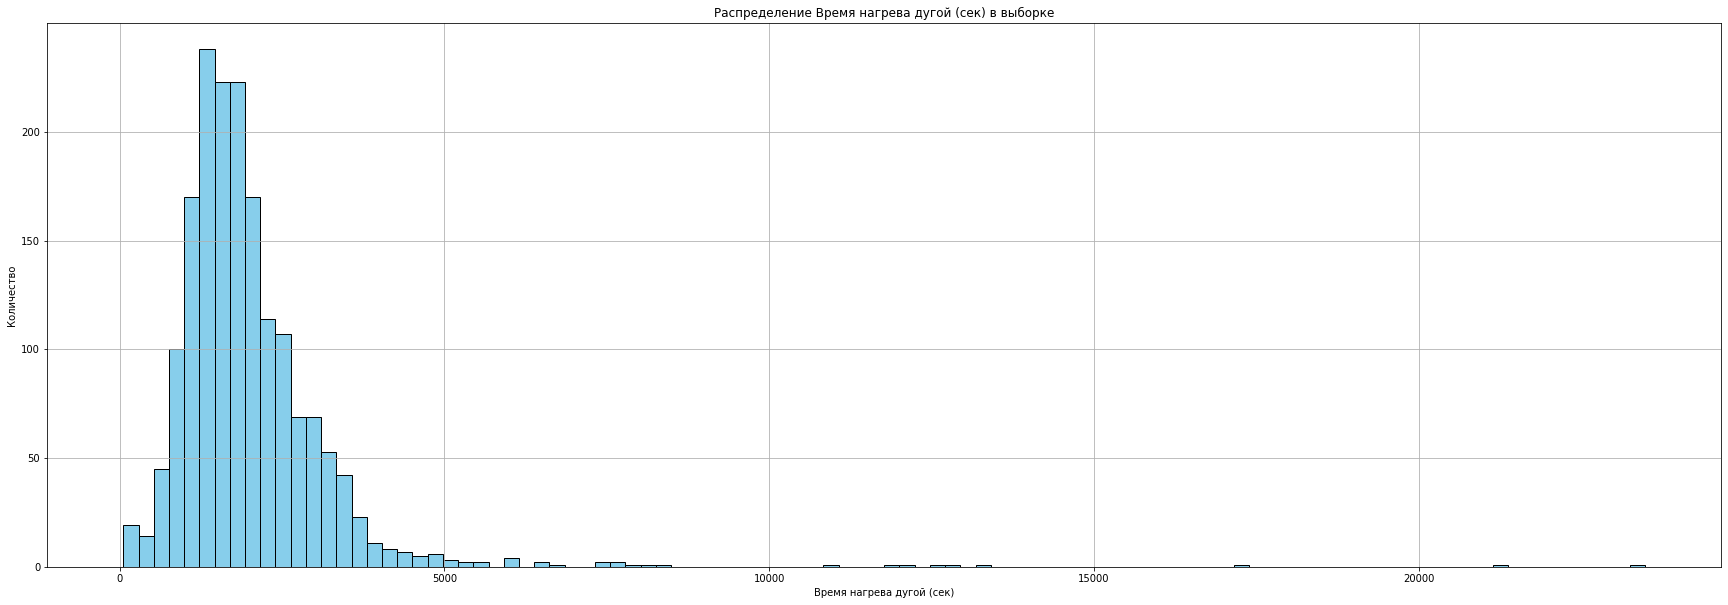

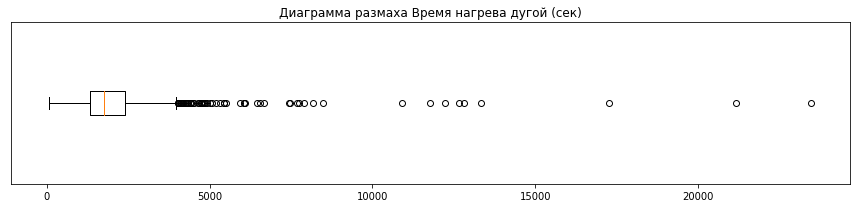

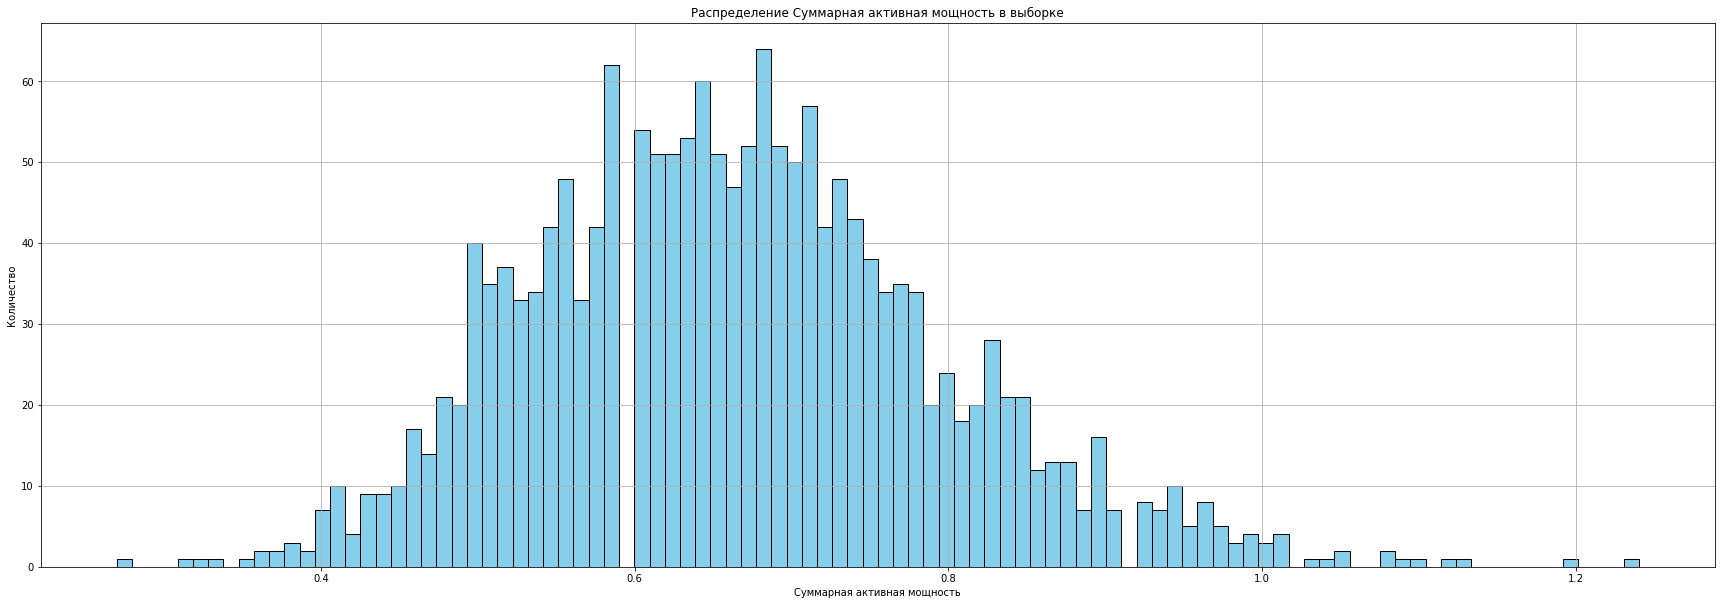

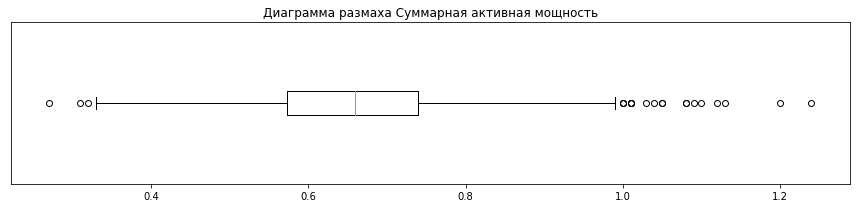

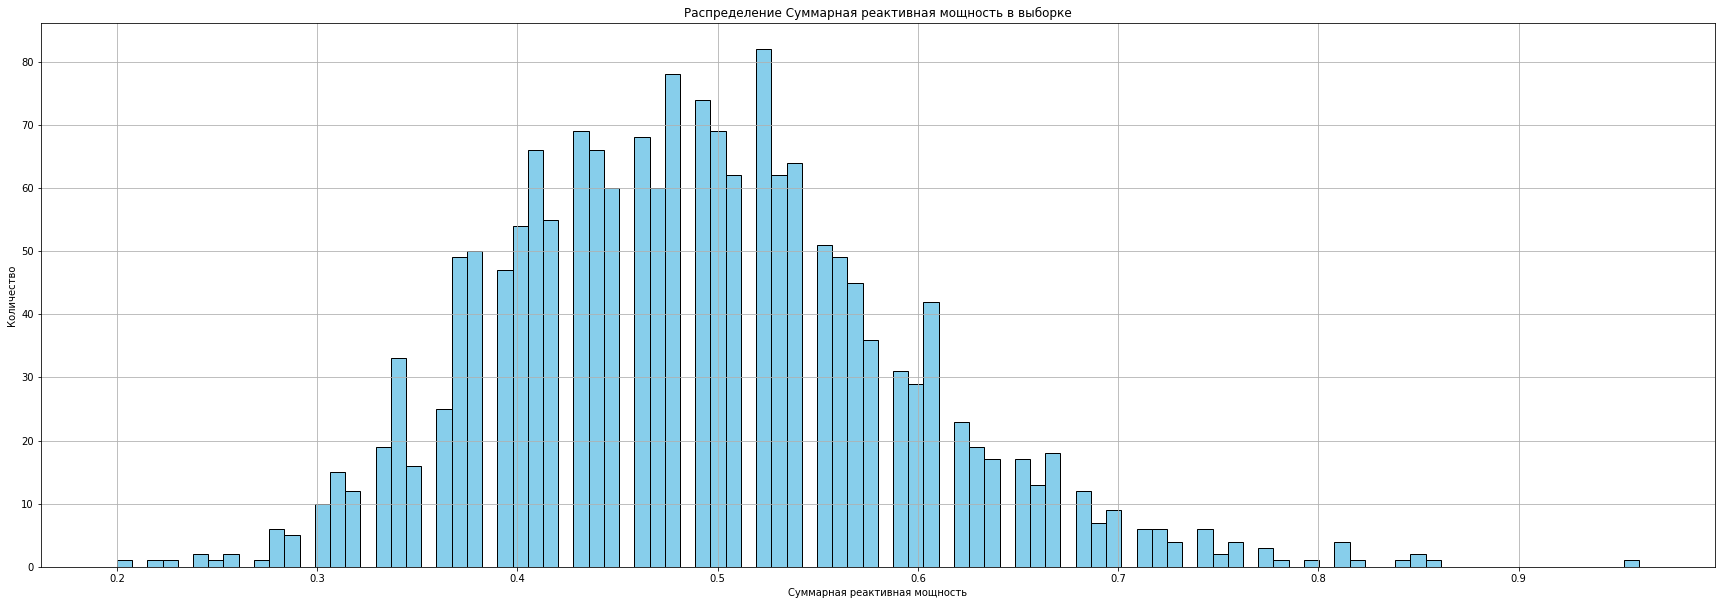

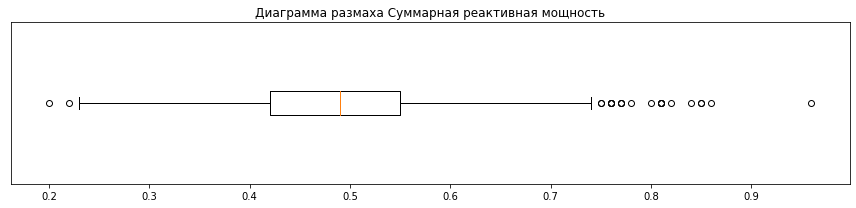

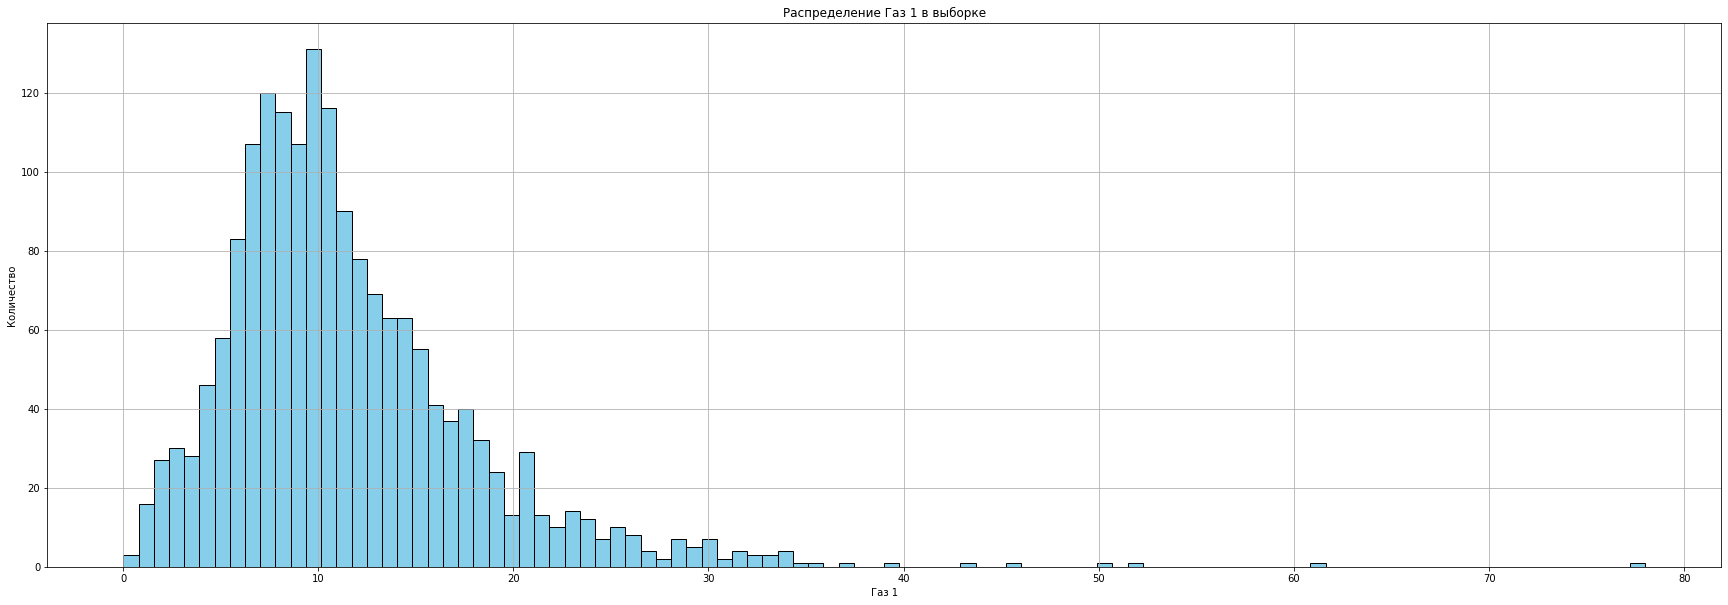

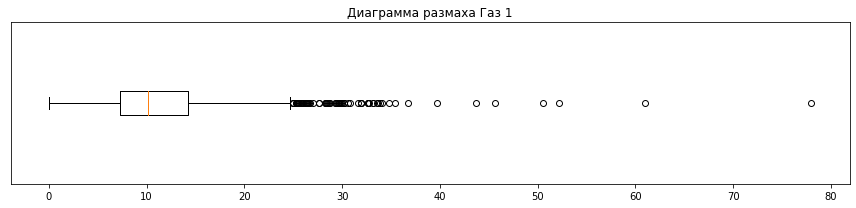

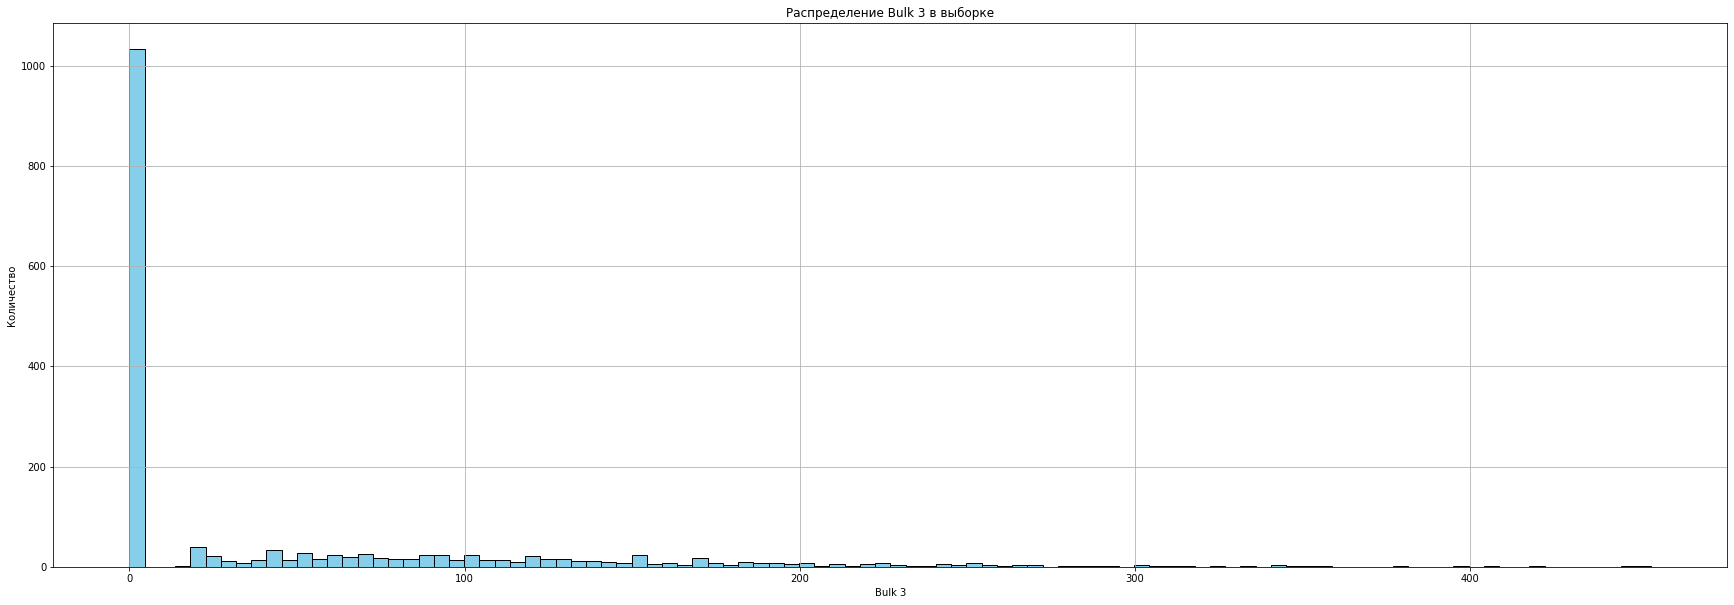

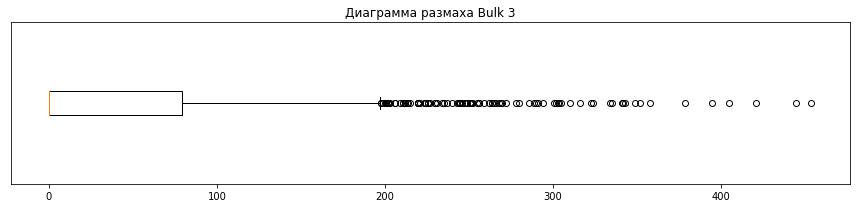

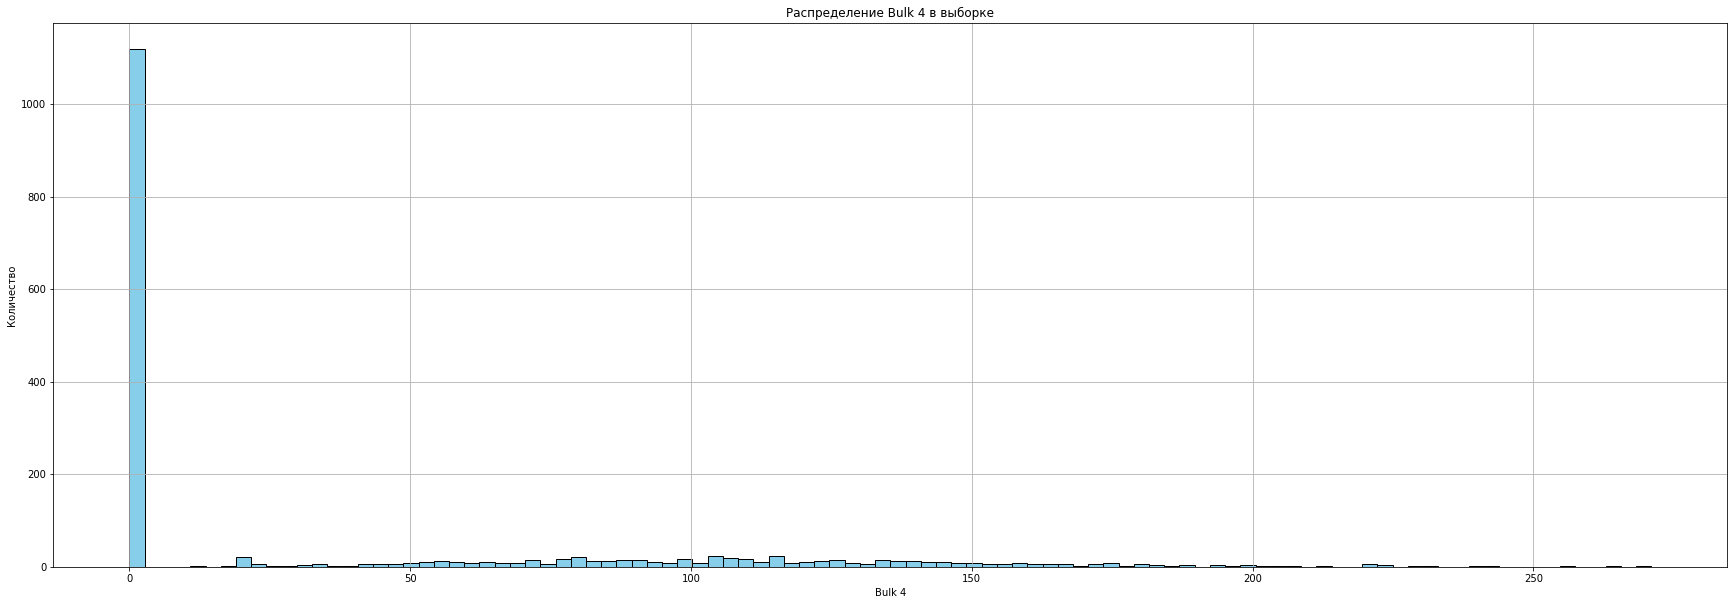

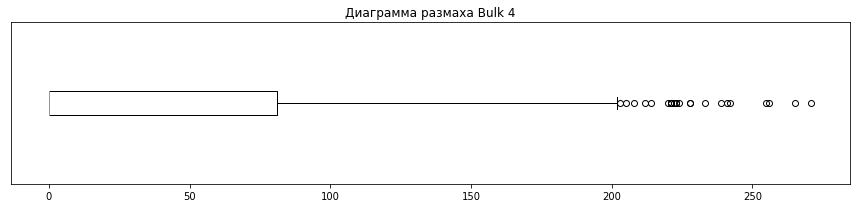

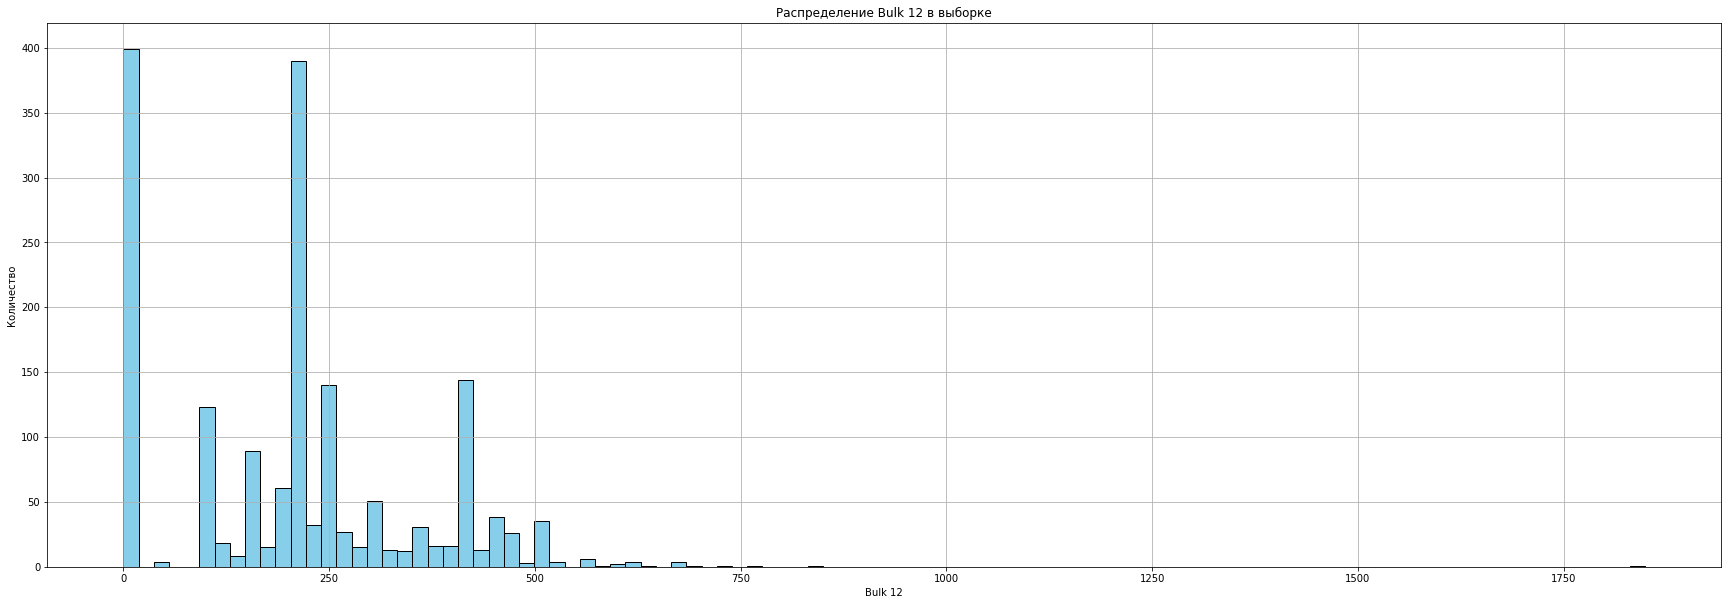

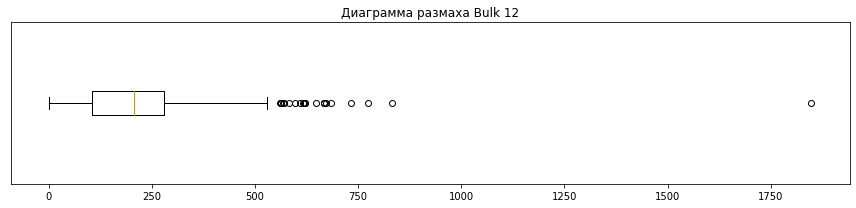

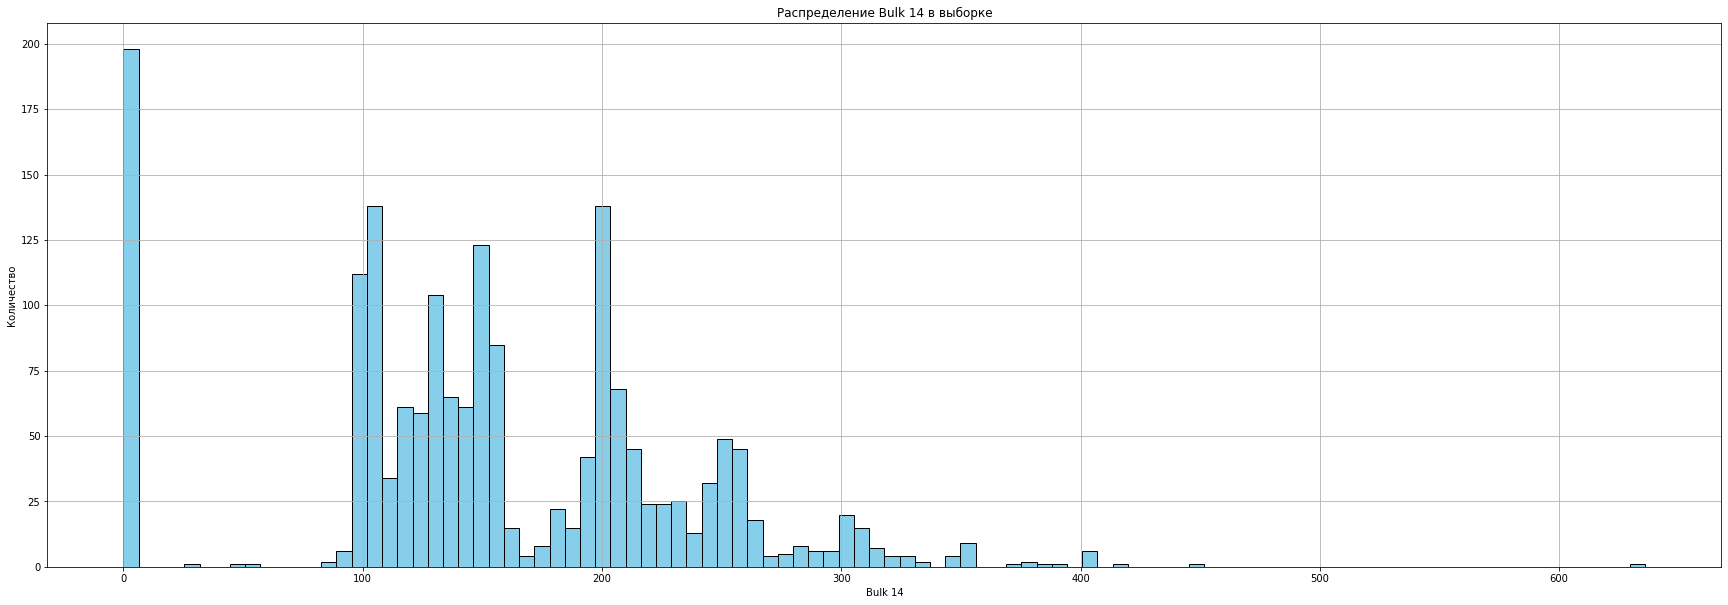

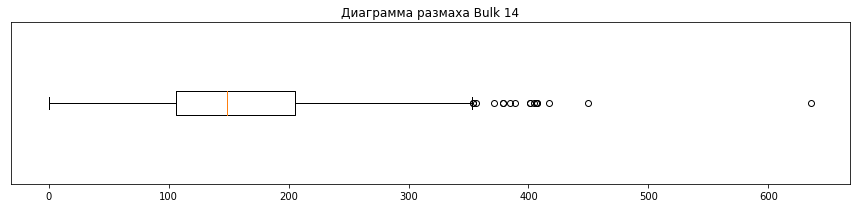

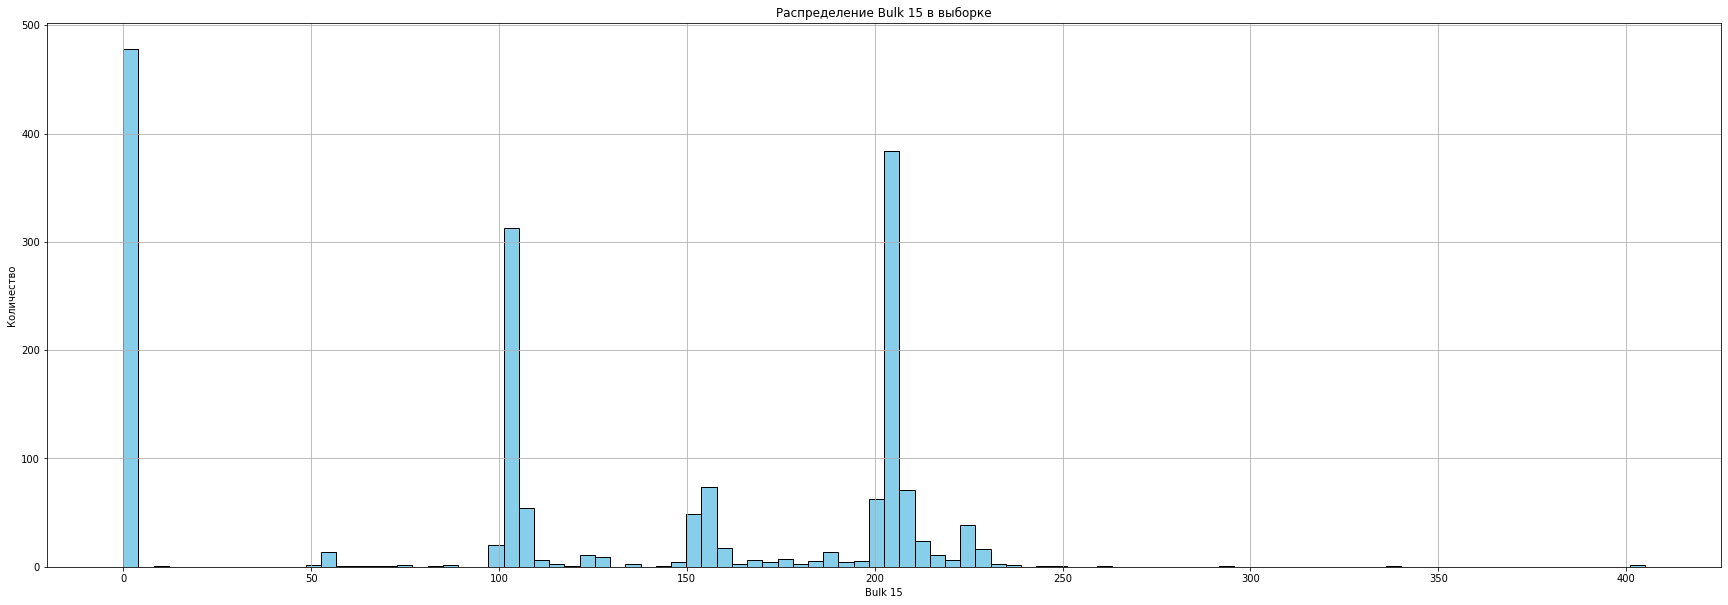

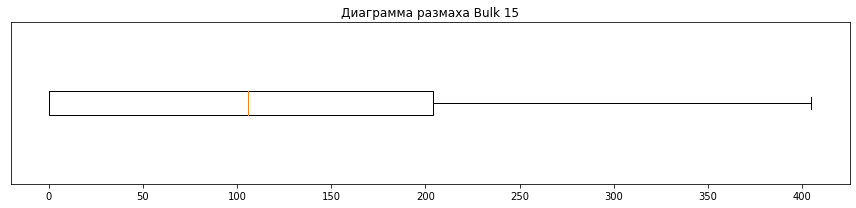

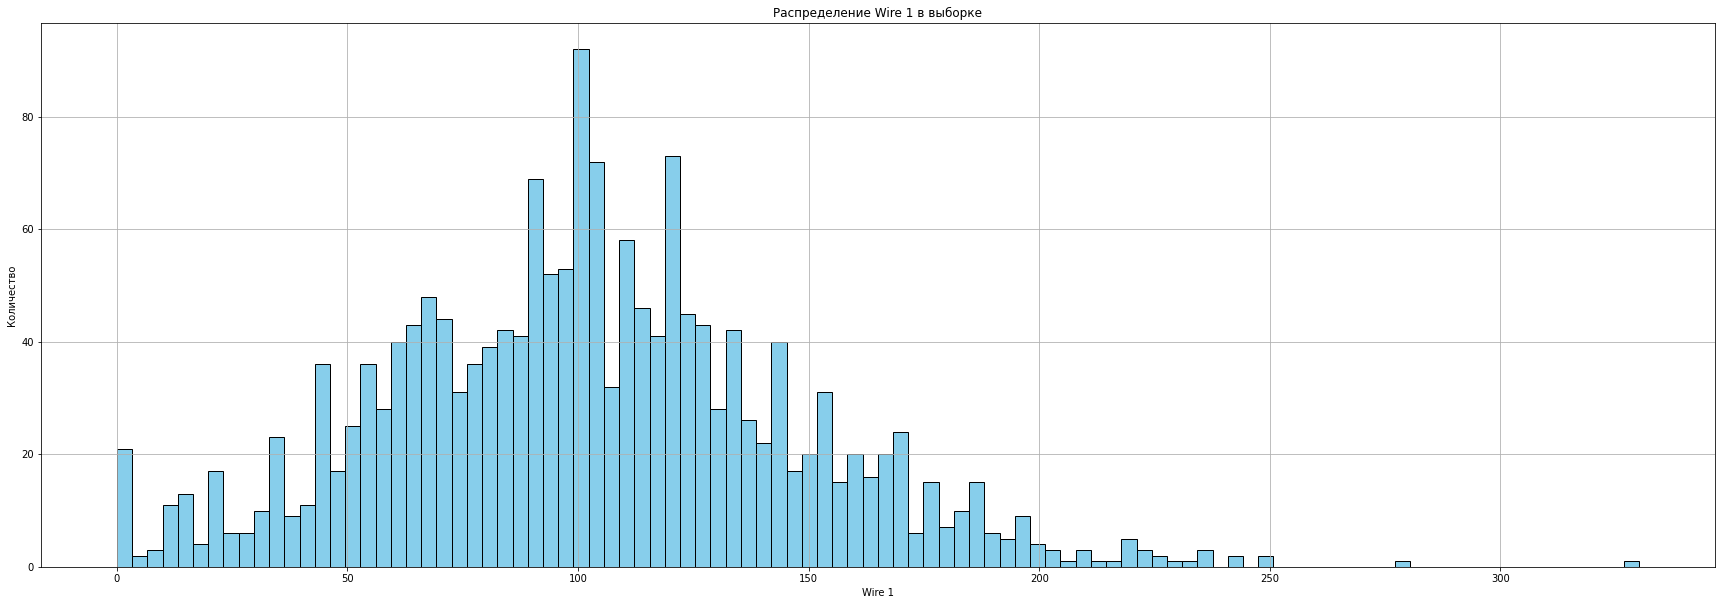

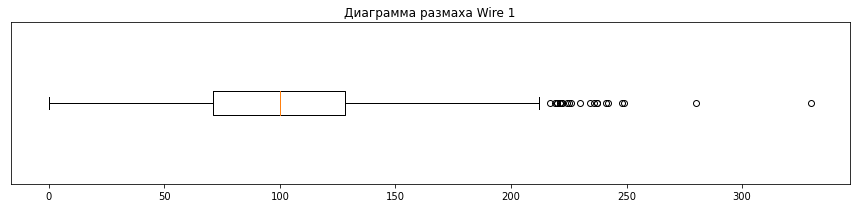

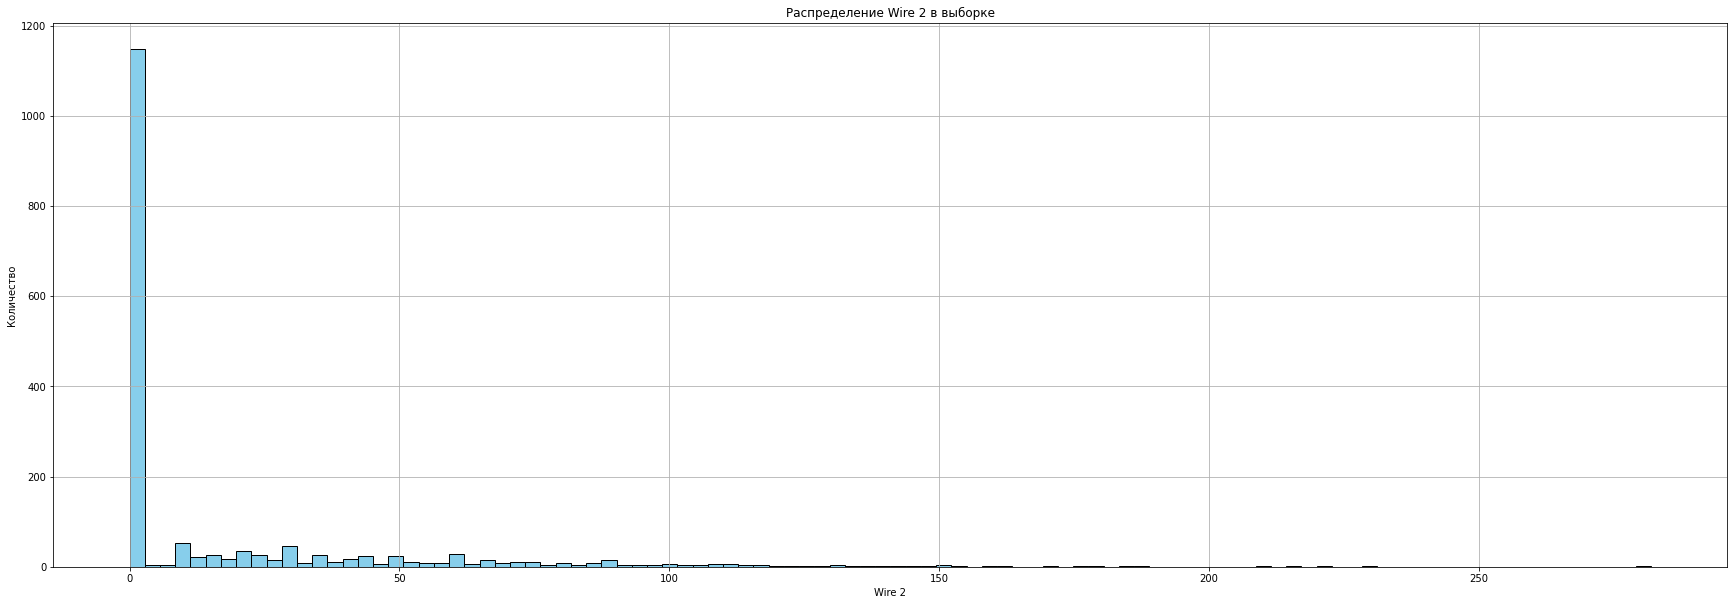

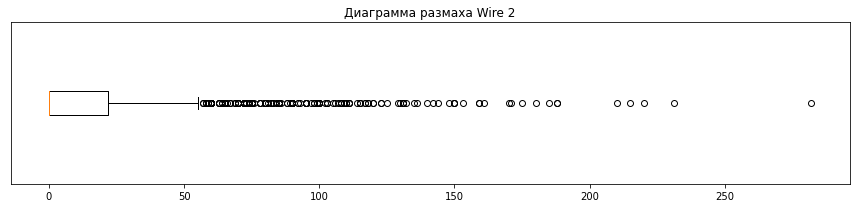

In [242]:
columns_to_plot = [
    'first_Температура', 'last_Температура', 'Работа', 
    'Полная мощность',
    'Время между замерами (сек)',
    'Время нагрева дугой (сек)',
    'Суммарная активная мощность',
    'Суммарная реактивная мощность',
    'Газ 1', 'Bulk 3','Bulk 4','Bulk 12','Bulk 14','Bulk 15', 'Wire 1', 'Wire 2' ]


for column in columns_to_plot:
    plt.figure(figsize=(30, 10))
    plt.hist(train_df[column], bins=100, color='skyblue', edgecolor='black')
    plt.title(f'Распределение {column} в выборке')
    plt.xlabel(column)
    plt.ylabel('Количество')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 3))
    plt.boxplot(train_df[column], vert=False)
    plt.title(f'Диаграмма размаха {column}')
    plt.yticks([])
    plt.gca().invert_yaxis()  # Чтобы ось Y была сверху вниз

    plt.tight_layout()
    plt.show()

In [243]:
#train_df = train_df[train_df['Работа']<25000]

In [244]:
train_df.shape

(1746, 21)

In [245]:
train_df = train_df[train_df['first_Температура']<1650]

In [246]:
train_df.shape

(1736, 21)

In [247]:
train_df = train_df[train_df['first_Температура']>1530]

In [248]:
train_df.shape

(1724, 21)

In [249]:
train_df = train_df[train_df['Полная мощность']<10]

In [250]:
train_df.shape

(1724, 21)

In [251]:
train_df = train_df[train_df['Время между замерами (сек)']<20000]

In [252]:
train_df.shape

(1722, 21)

In [253]:
train_df = train_df[train_df['Время нагрева дугой (сек)']<20000]

In [254]:
train_df.shape

(1722, 21)

In [255]:
train_df = train_df[train_df['Суммарная активная мощность']<10]

In [256]:
train_df.shape

(1722, 21)

In [257]:
train_df = train_df[train_df['Суммарная реактивная мощность']<8]

In [258]:
train_df.shape

(1722, 21)

In [259]:
train_df = train_df[train_df['Газ 1']<40]

In [260]:
train_df.shape

(1717, 21)

In [261]:
X_train = X_train[X_train['Bulk 3']<=400]

In [262]:
train_df.shape

(1717, 21)

In [263]:
train_df.shape

(1717, 21)

In [264]:
#train_df = train_df[train_df['Wire 2']<200]

In [265]:
train_df.shape

(1717, 21)

In [266]:
#train_df = train_df[train_df['Wire 1']<250]

In [267]:
train_df.shape

(1717, 21)

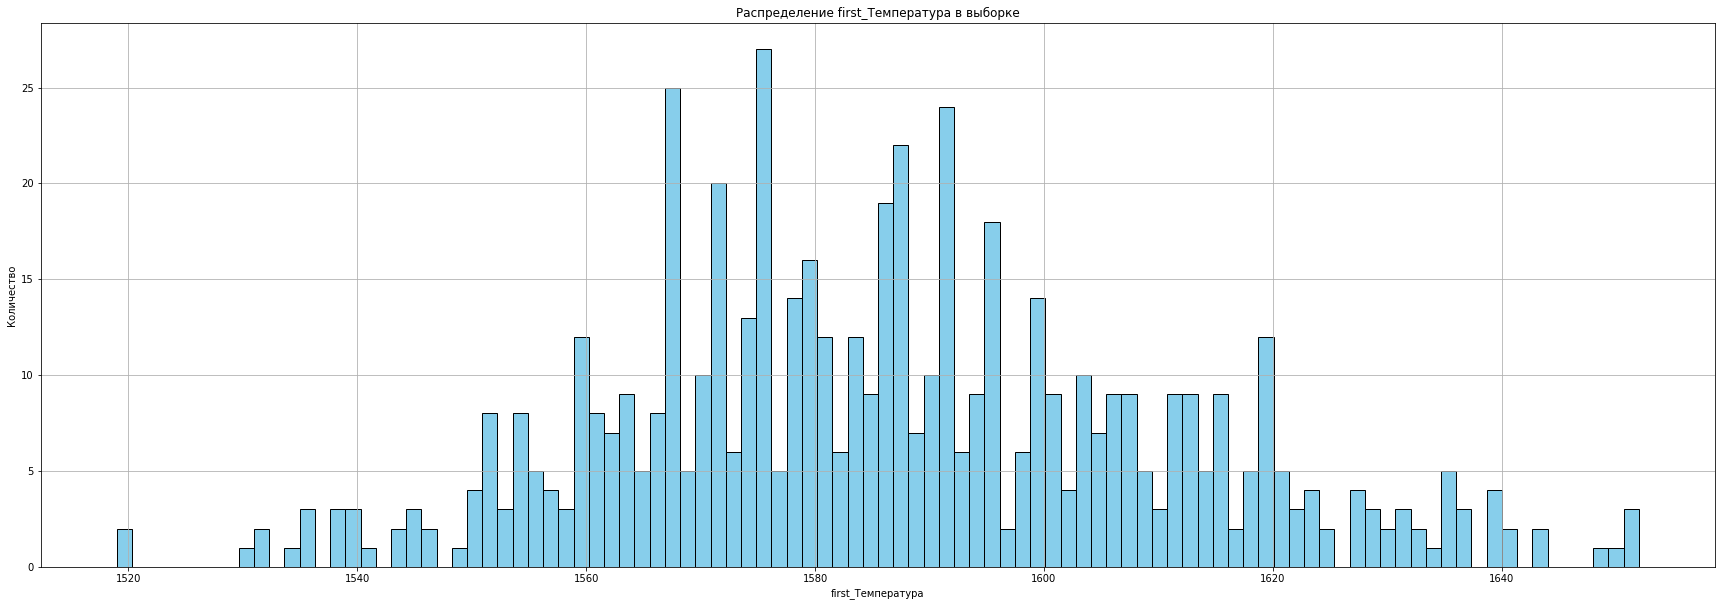

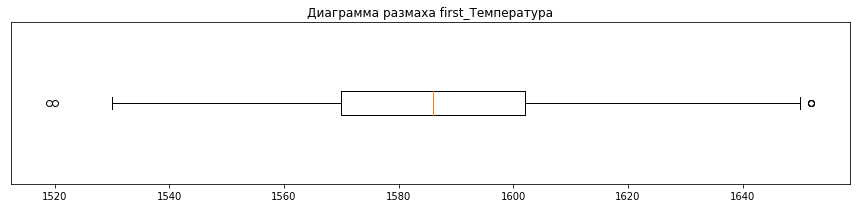

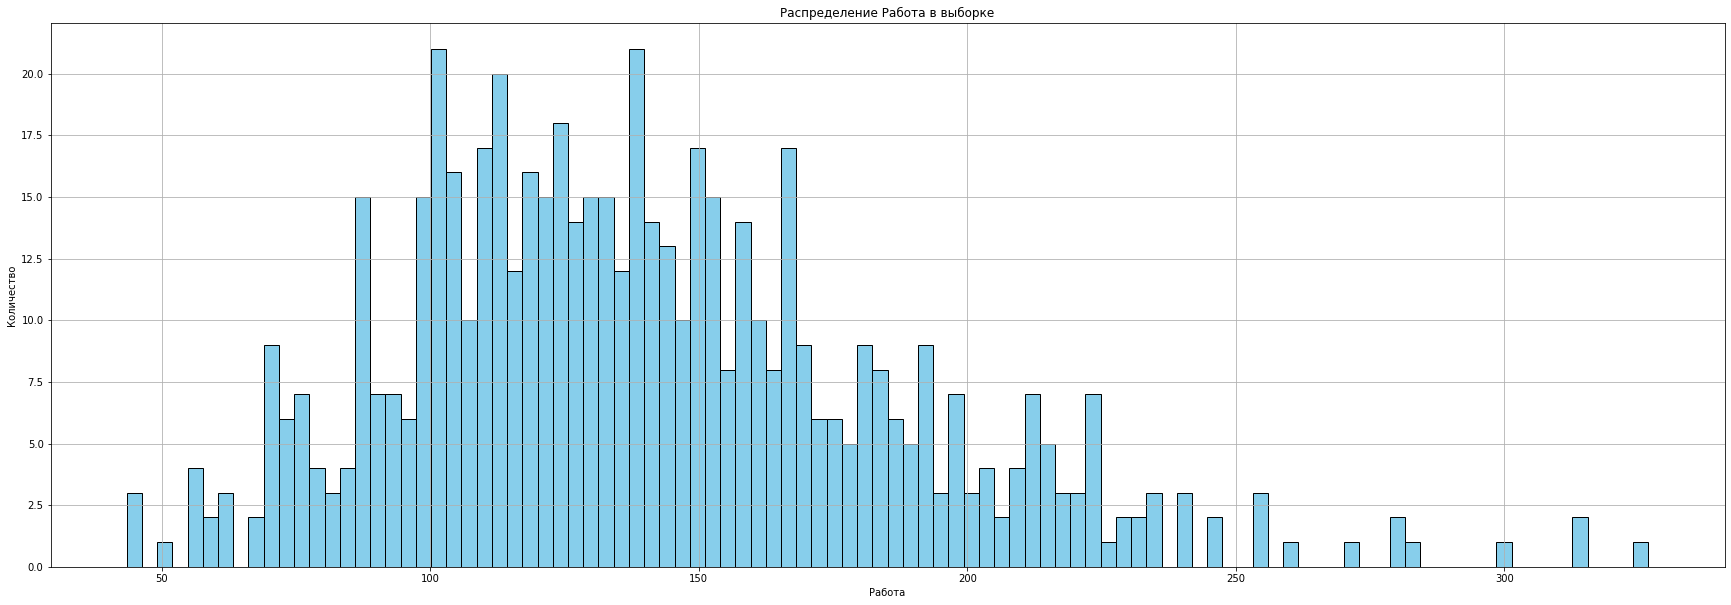

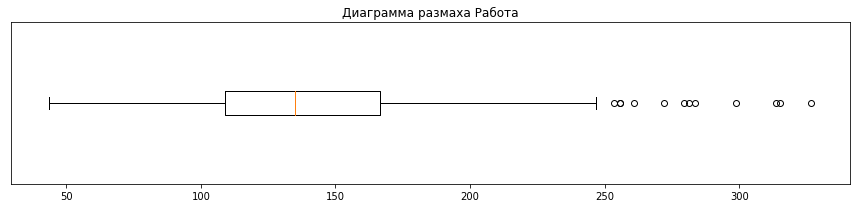

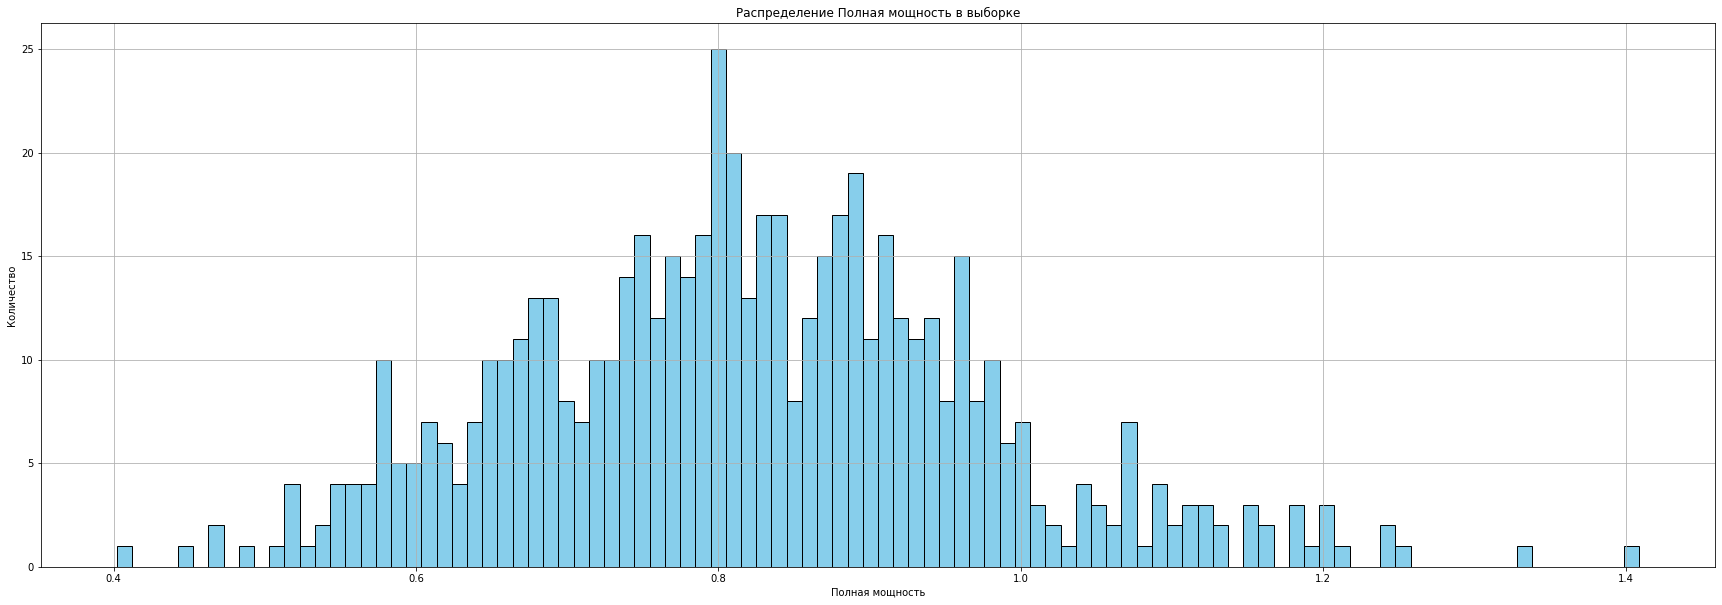

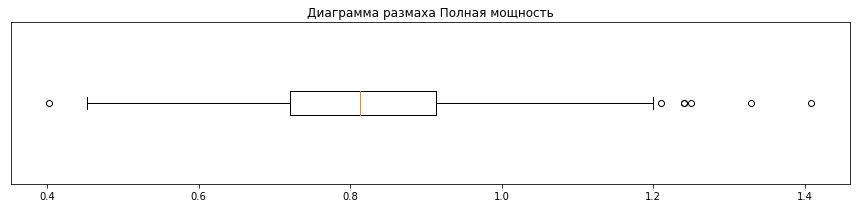

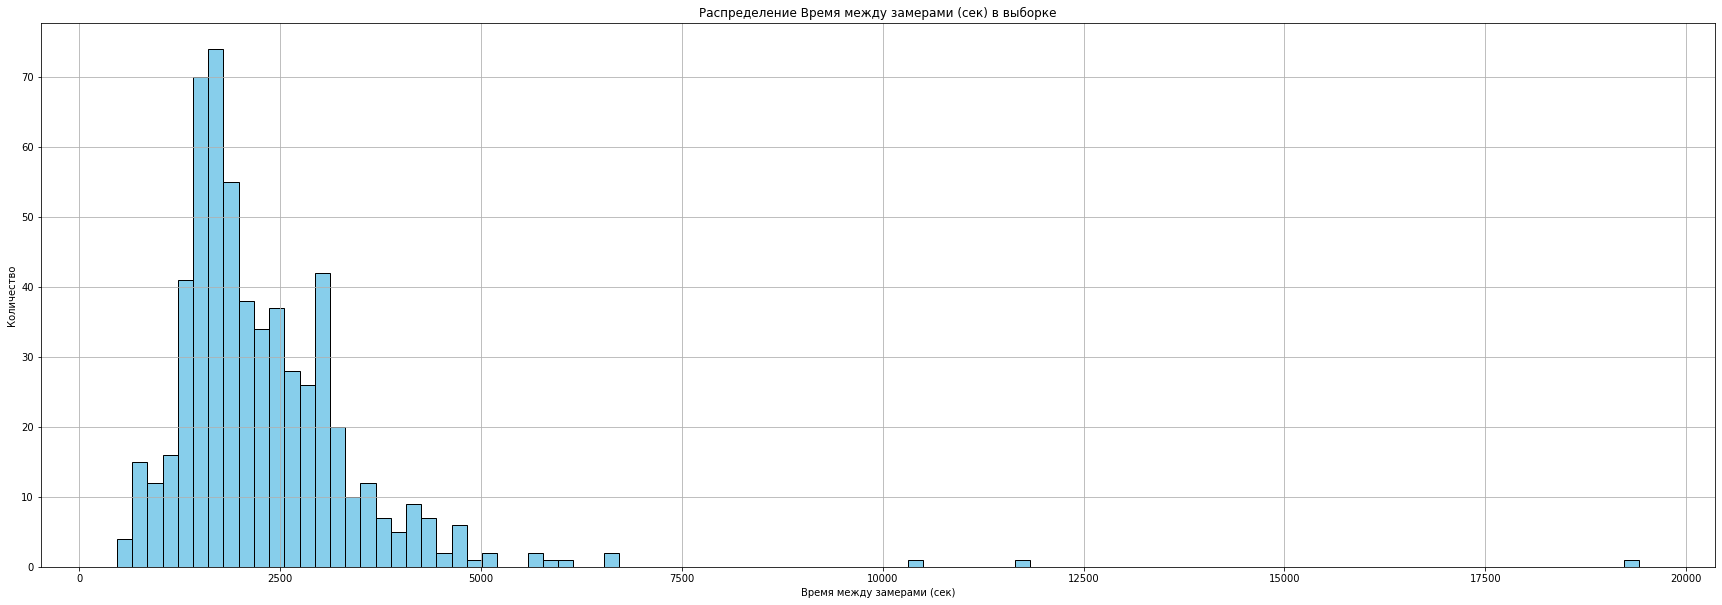

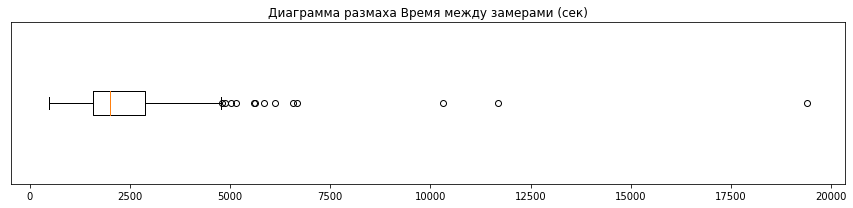

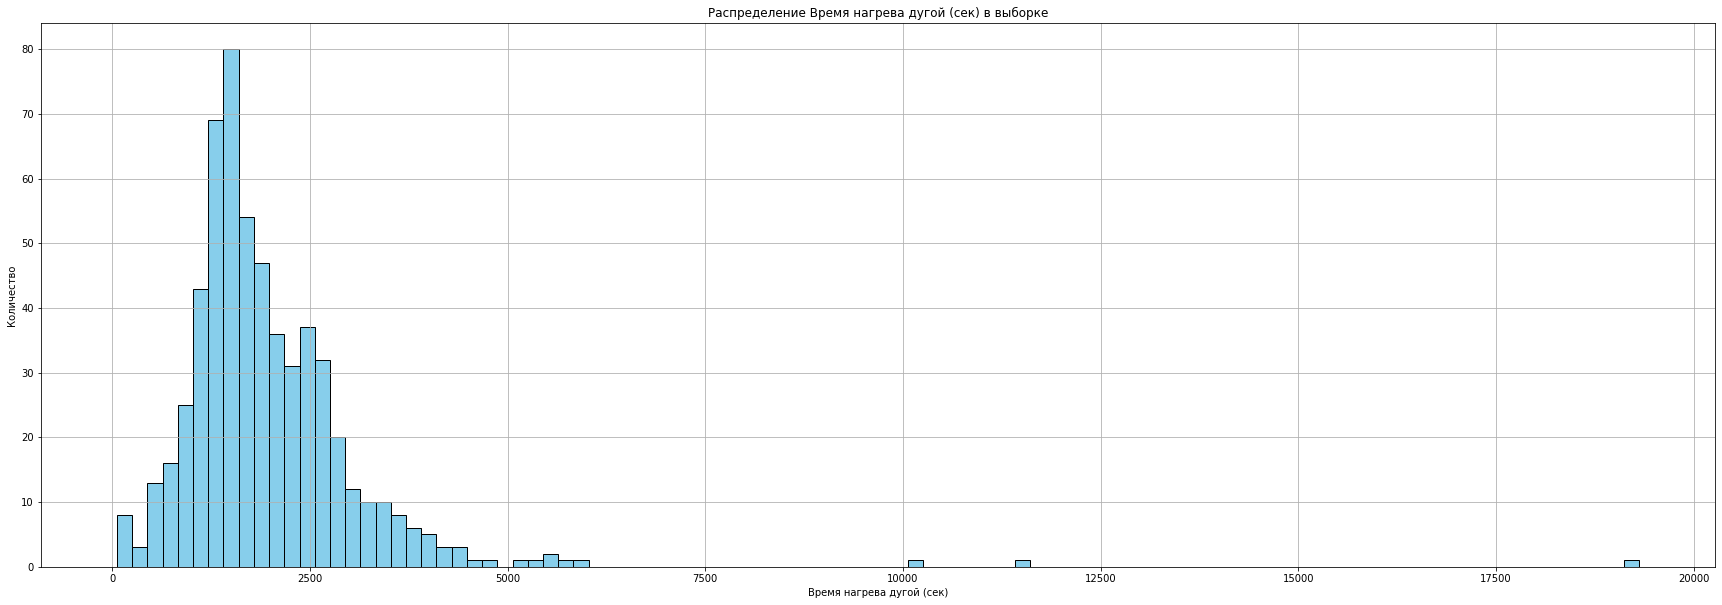

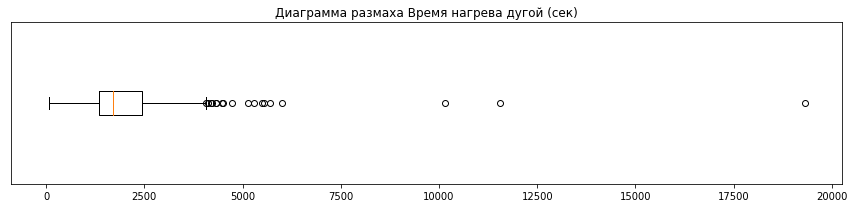

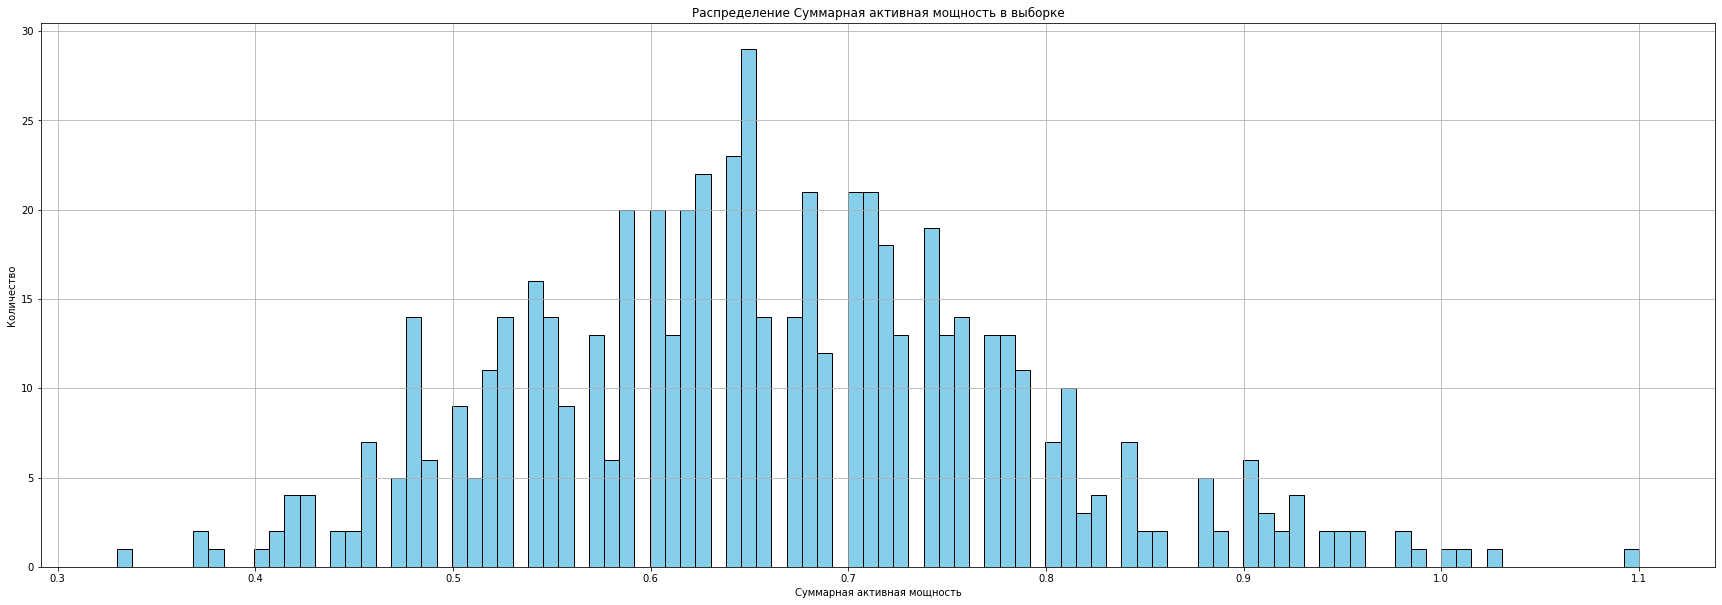

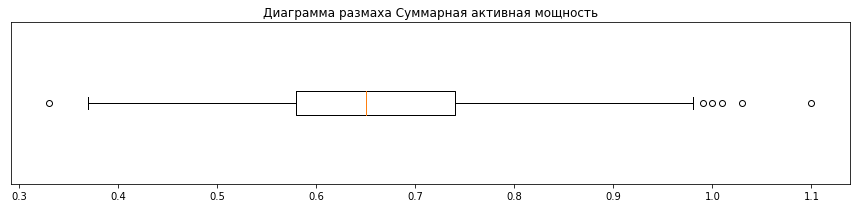

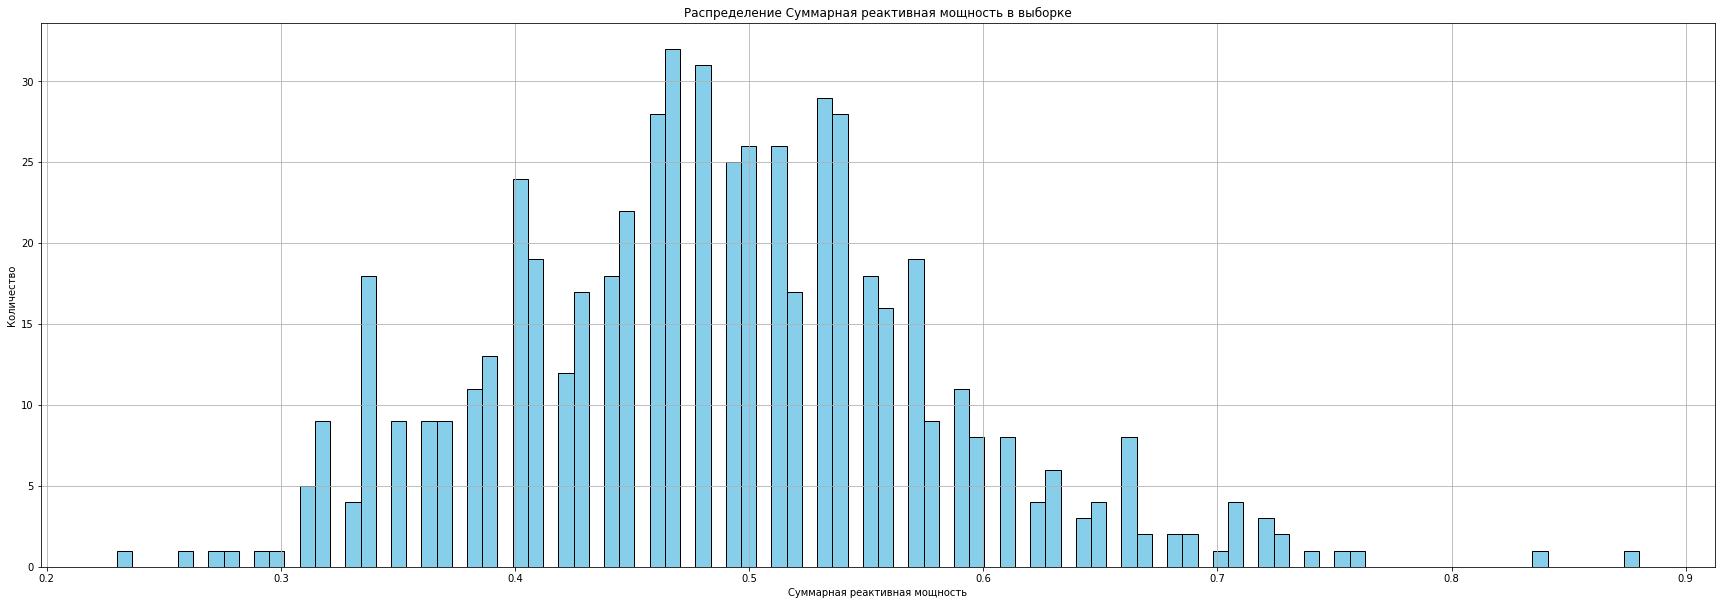

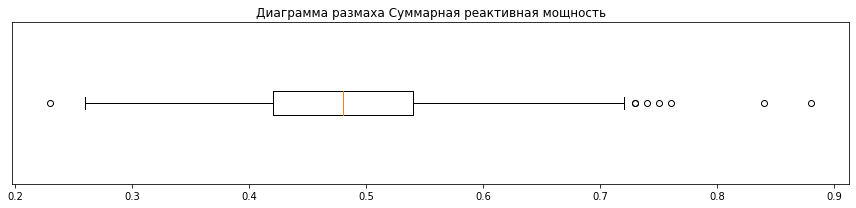

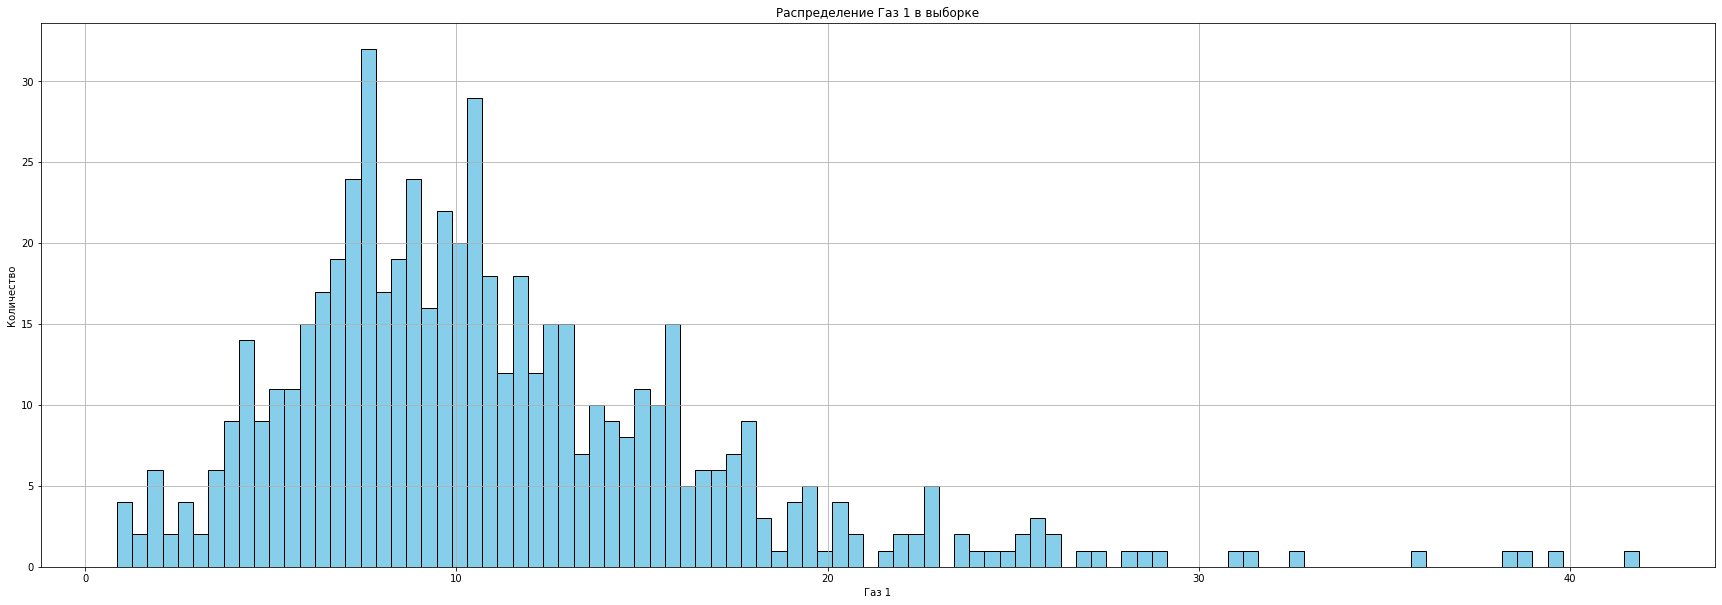

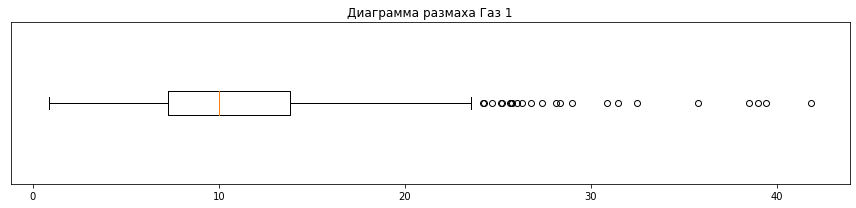

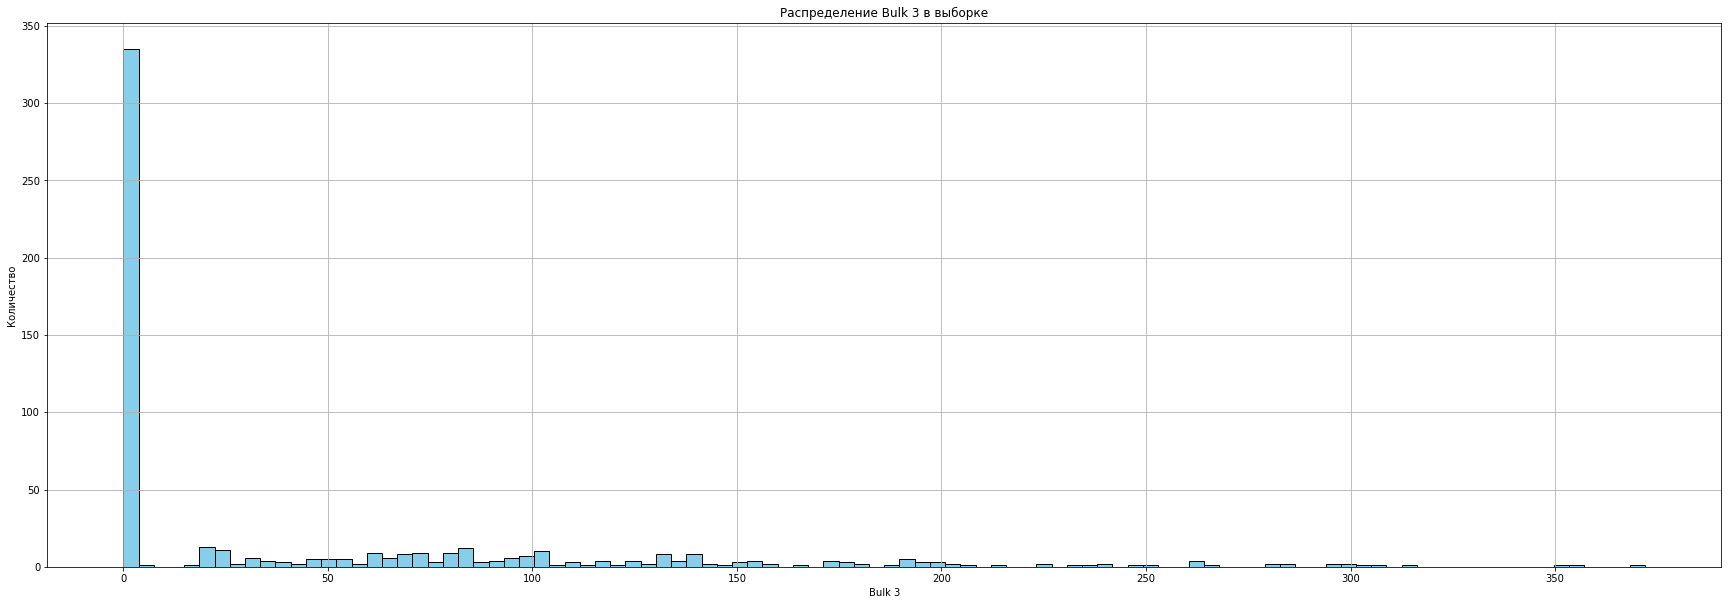

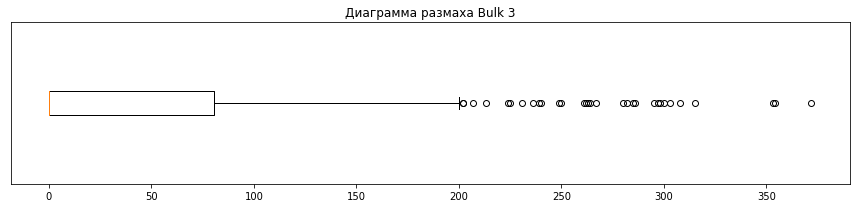

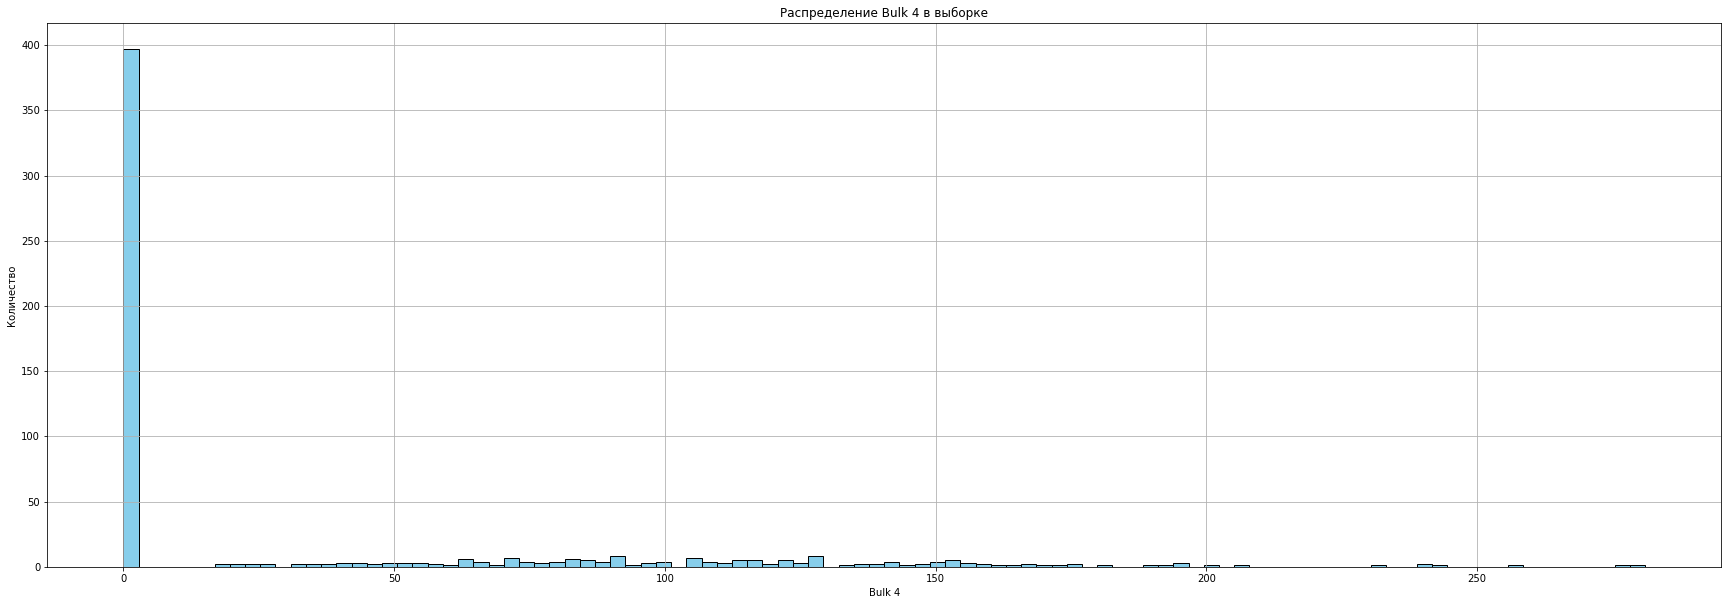

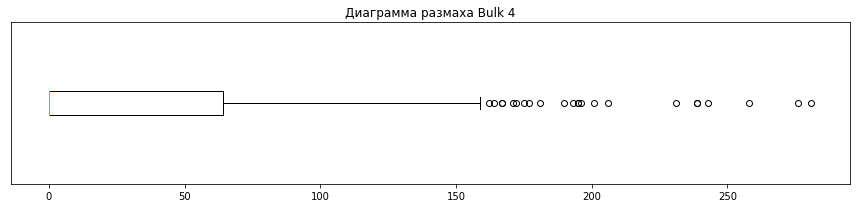

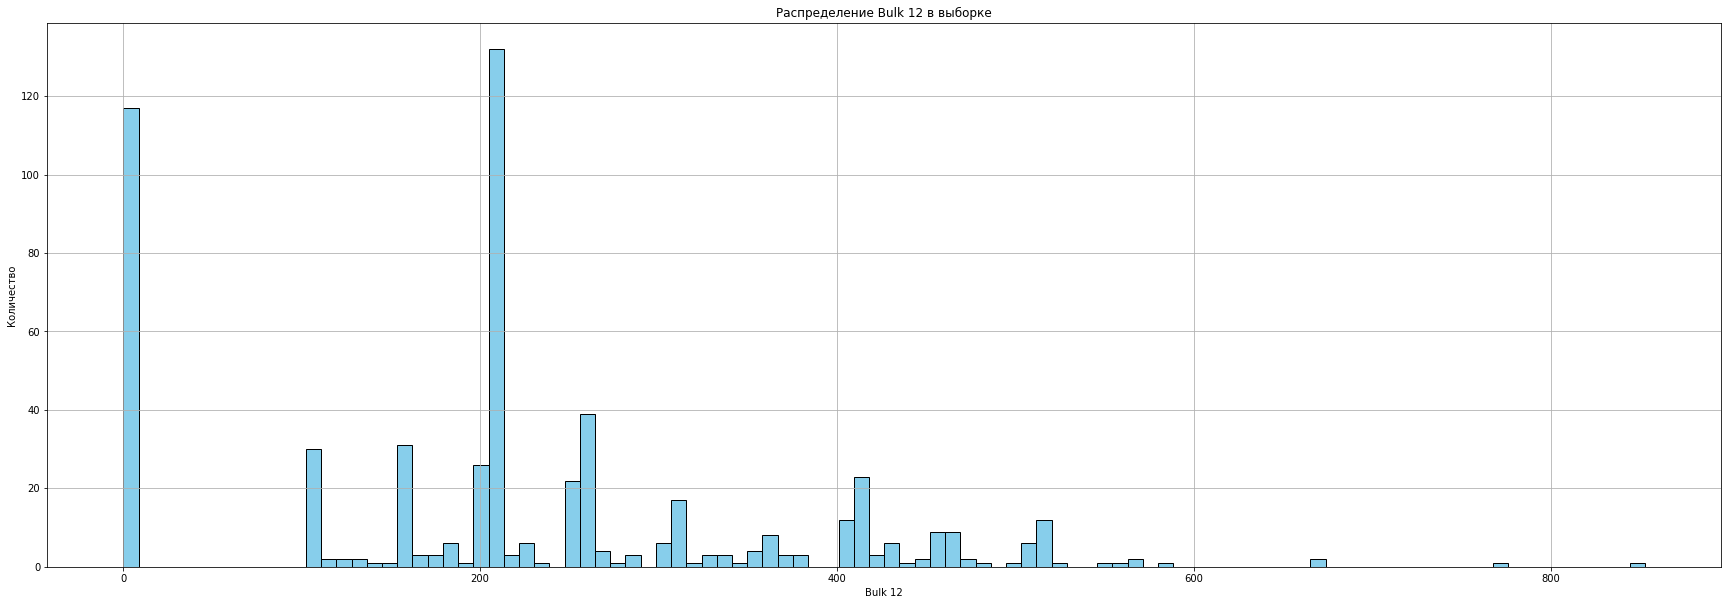

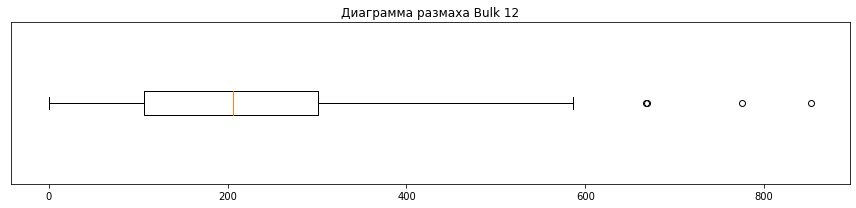

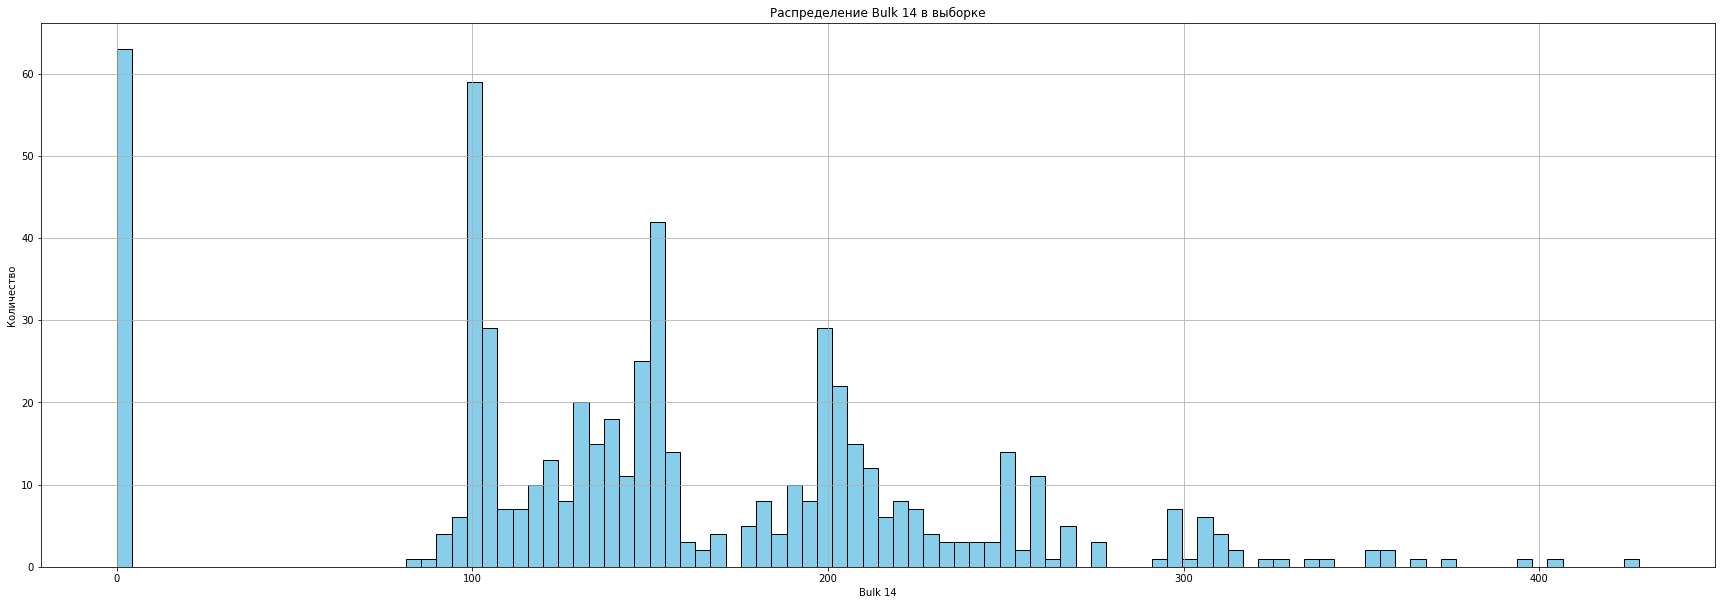

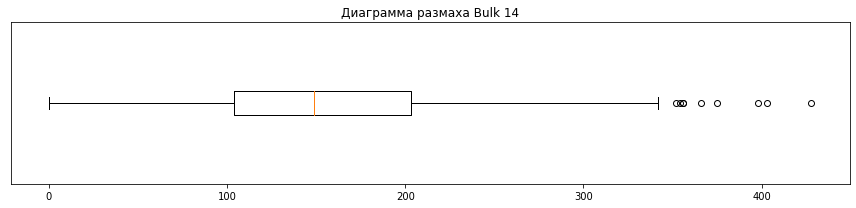

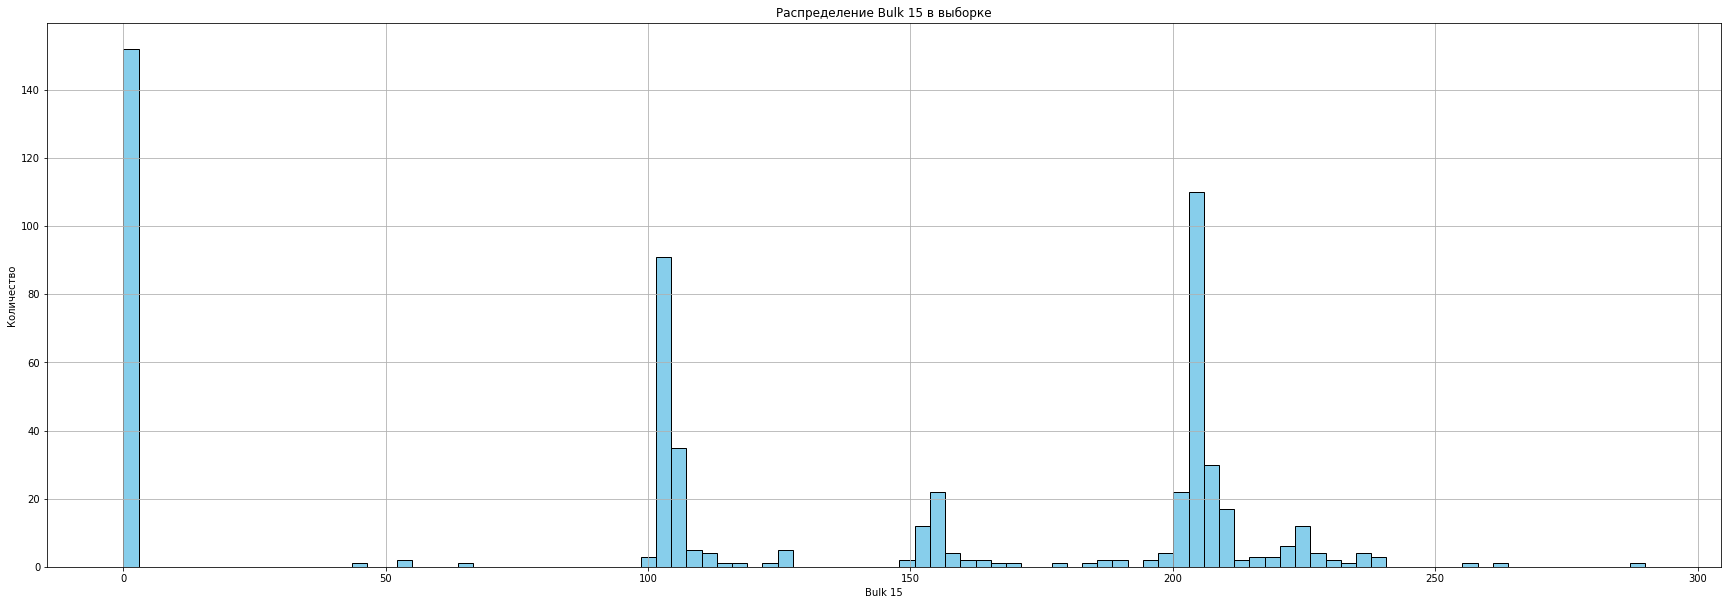

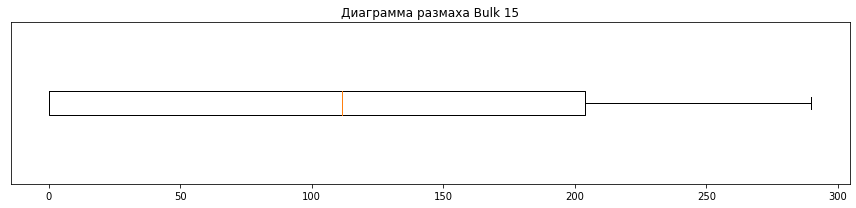

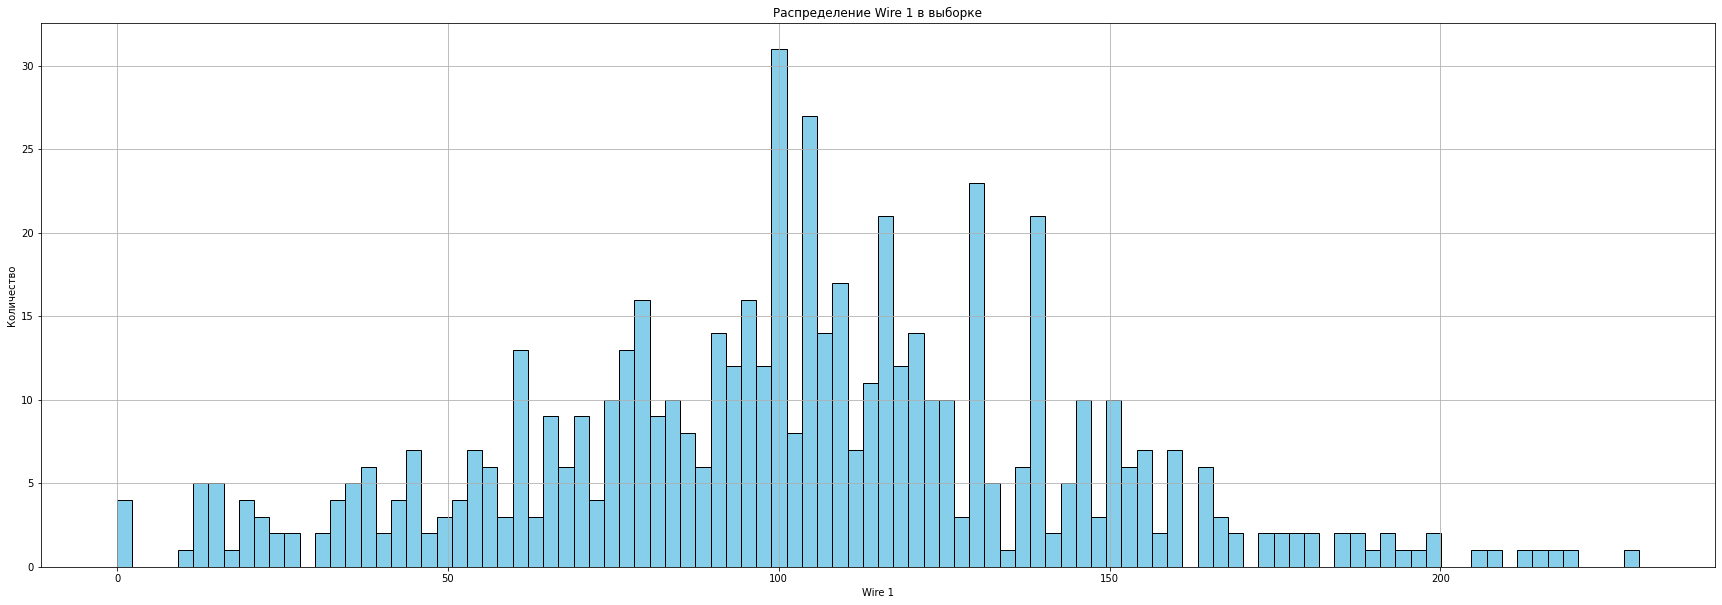

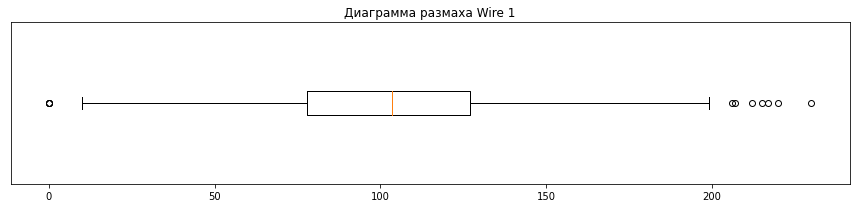

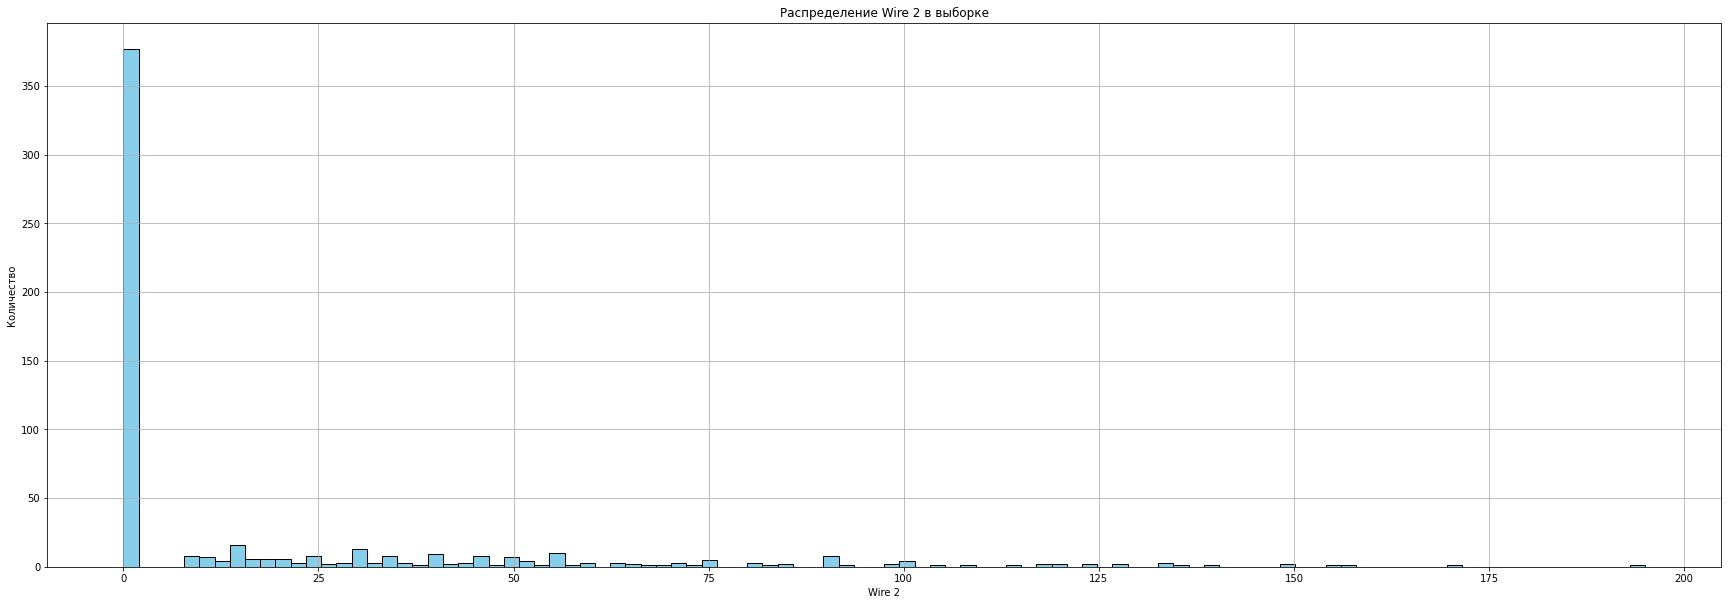

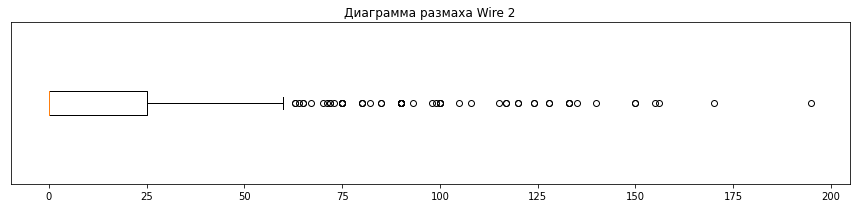

In [268]:
columns_to_plot = [
    'first_Температура', 'Работа', 
    'Полная мощность',
    'Время между замерами (сек)',
    'Время нагрева дугой (сек)',
    'Суммарная активная мощность',
    'Суммарная реактивная мощность',
    'Газ 1', 'Bulk 3','Bulk 4','Bulk 12','Bulk 14','Bulk 15', 'Wire 1', 'Wire 2' ]


for column in columns_to_plot:
    plt.figure(figsize=(30, 10))
    plt.hist(X_test[column], bins=100, color='skyblue', edgecolor='black')
    plt.title(f'Распределение {column} в выборке')
    plt.xlabel(column)
    plt.ylabel('Количество')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 3))
    plt.boxplot(X_test[column], vert=False)
    plt.title(f'Диаграмма размаха {column}')
    plt.yticks([])
    plt.gca().invert_yaxis()  # Чтобы ось Y была сверху вниз

    plt.tight_layout()
    plt.show()

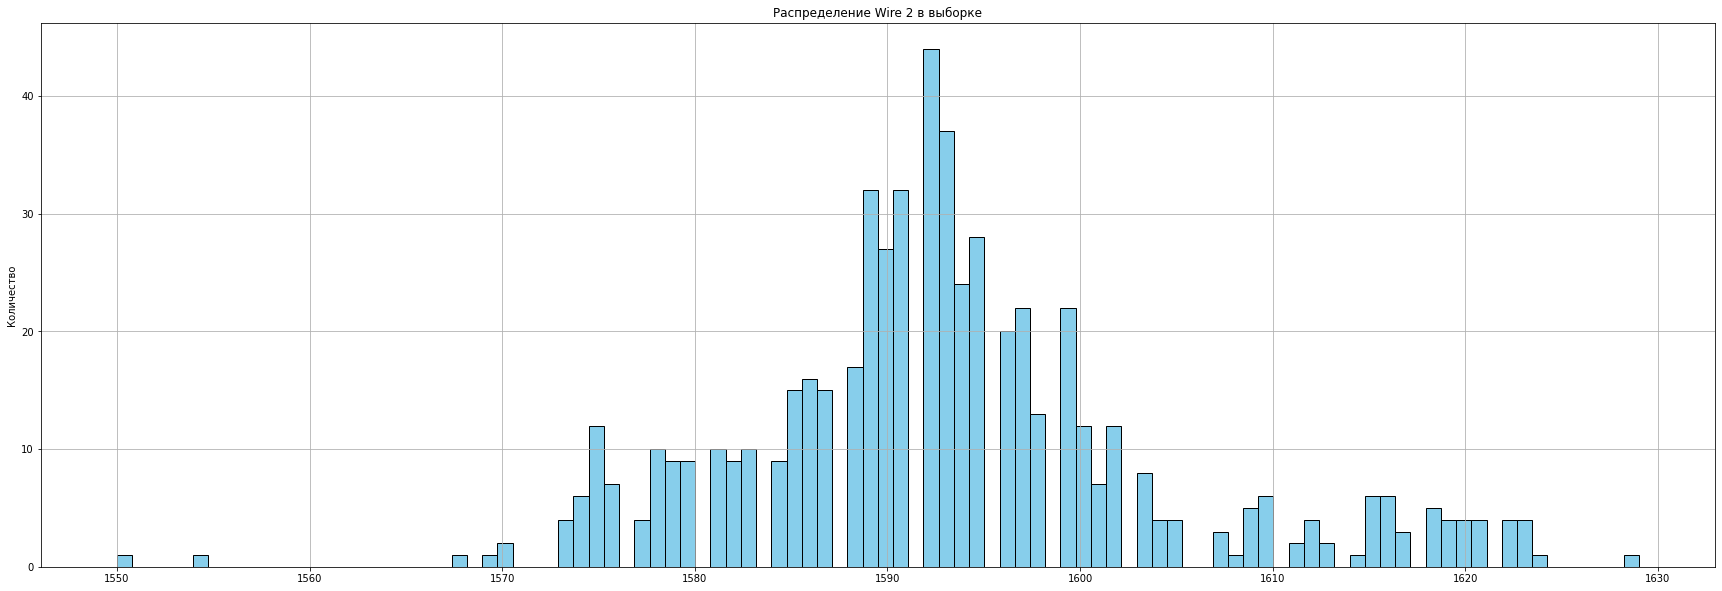

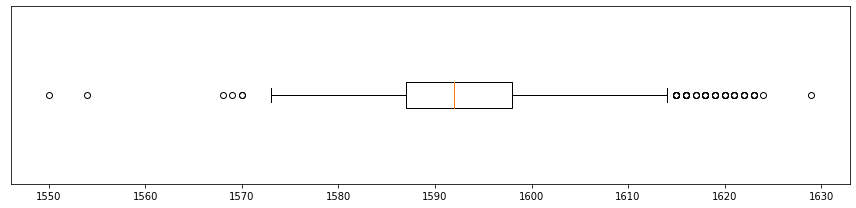

In [269]:
plt.figure(figsize=(30, 10))
plt.hist(y_test, bins=100, color='skyblue', edgecolor='black')
plt.title(f'Распределение {column} в выборке')
plt.ylabel('Количество')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 3))
plt.boxplot(y_test, vert=False)
plt.yticks([])
plt.gca().invert_yaxis()  # Чтобы ось Y была сверху вниз

plt.tight_layout()
plt.show()

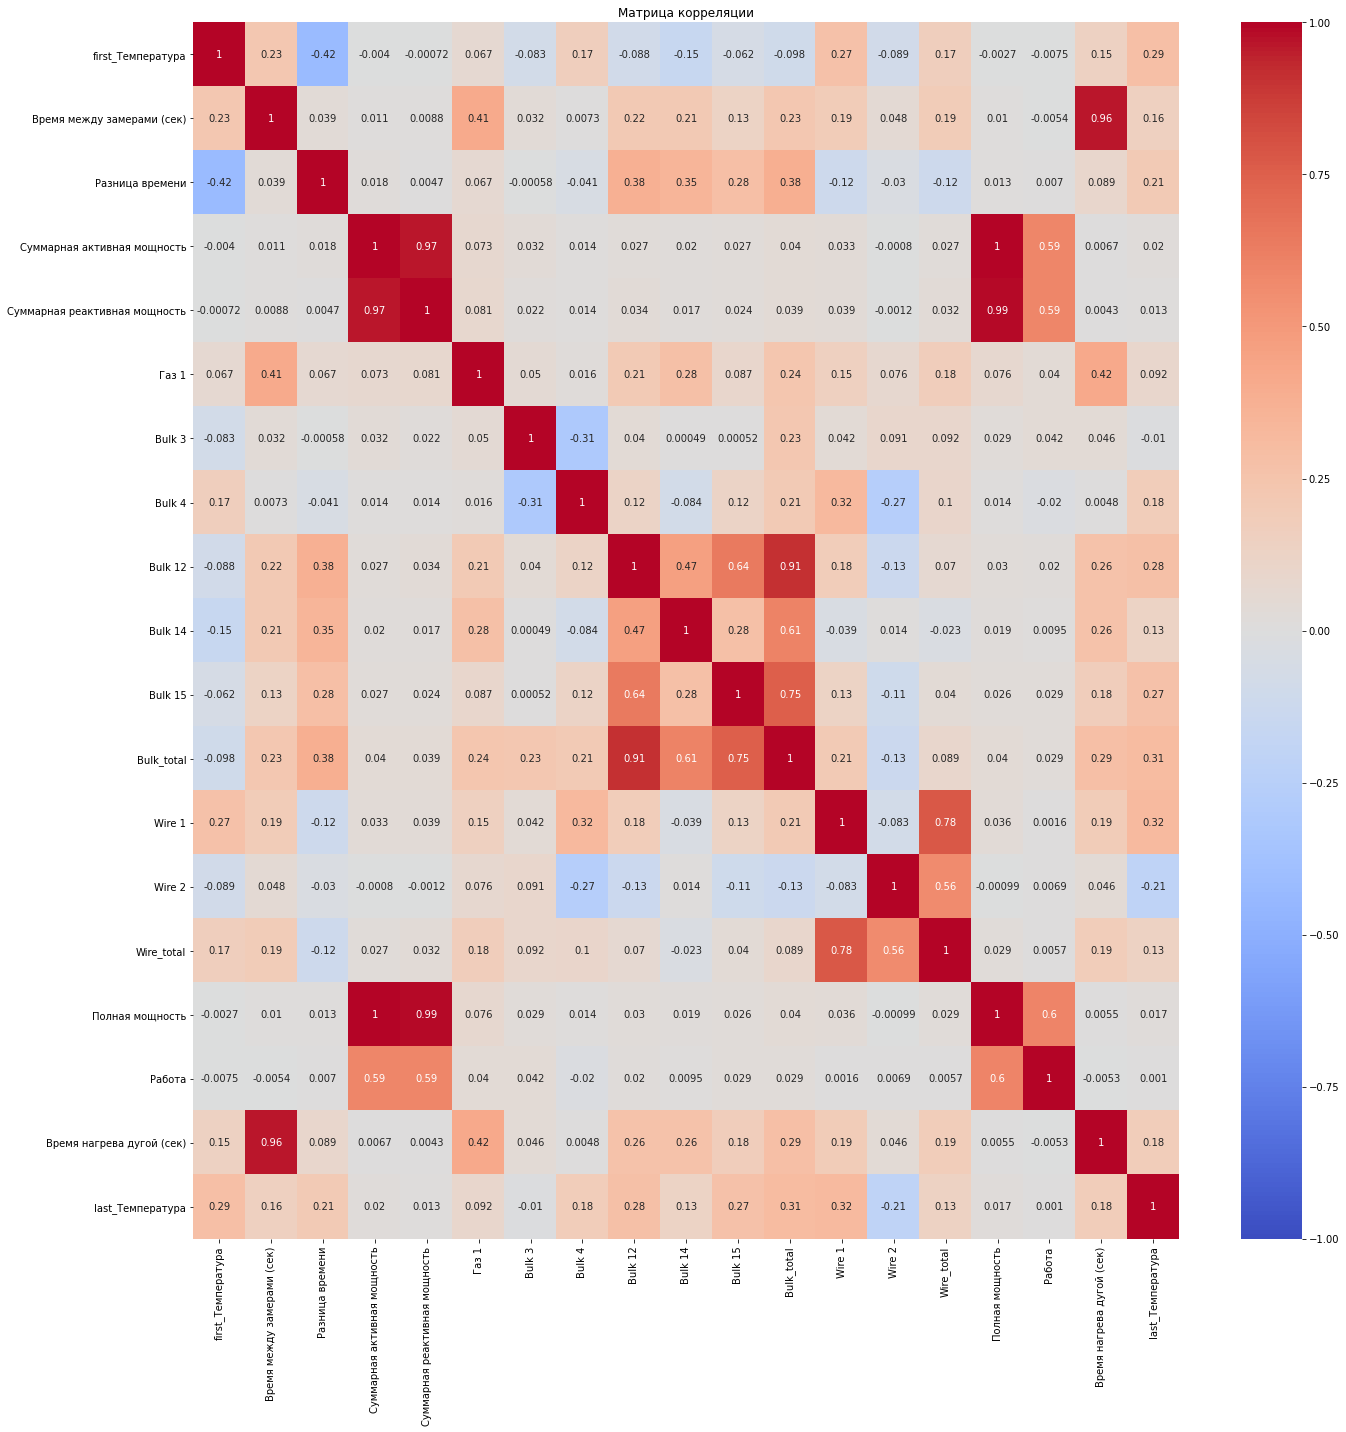

In [270]:
plt.figure(figsize=(20, 20))
sns.heatmap(train_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Матрица корреляции')
plt.tight_layout()
plt.show()


In [271]:
X_train = train_df.drop(y_train.name,axis=1)
y_train = train_df[y_train.name]

In [272]:
X_train.head()

,first_Температура,Время между замерами (сек),Начало нагрева дугой,Конец нагрева дугой,Разница времени,Суммарная активная мощность,Суммарная реактивная мощность,Газ 1,Bulk 3,Bulk 4,Bulk 12,Bulk 14,Bulk 15,Bulk_total,Wire 1,Wire 2,Wire_total,Полная мощность,Работа,Время нагрева дугой (сек)
137,1600.0,2843.0,2019-05-09 15:16:40,2019-05-09 15:55:08,183.250000,0.61,0.45,6.57,0,0,0,159,0,159,20,0,20,0.758024,75.802375,2308.0
1804,1596.0,2886.0,2019-07-19 17:18:45,2019-07-19 18:00:10,184.400000,0.67,0.51,19.12,304,0,206,99,104,713,15,35,50,0.842021,105.926289,2485.0
1056,1566.0,1359.0,2019-06-16 04:10:22,2019-06-16 04:31:03,229.500000,0.81,0.54,5.82,221,0,204,102,102,629,114,0,114,0.973499,151.541320,1241.0
1222,1579.0,1750.0,2019-06-21 23:13:12,2019-06-21 23:39:45,143.166667,0.64,0.45,8.29,50,0,0,0,0,50,71,11,82,0.782368,124.865965,1593.0
1285,1571.0,1321.0,2019-06-24 14:47:40,2019-06-24 15:07:43,154.000000,0.49,0.37,4.12,0,0,279,179,145,603,35,0,35,0.614003,99.714129,1203.0


In [273]:
X_test.shape

(582, 20)

### Удаление признаков

In [274]:
columns_to_drop = ['Начало нагрева дугой', 'Конец нагрева дугой','Время между замерами (сек)']
X_test = X_test.drop(columns=columns_to_drop)
X_train = X_train.drop(columns=columns_to_drop)

In [275]:
X_train.head()

,first_Температура,Разница времени,Суммарная активная мощность,Суммарная реактивная мощность,Газ 1,Bulk 3,Bulk 4,Bulk 12,Bulk 14,Bulk 15,Bulk_total,Wire 1,Wire 2,Wire_total,Полная мощность,Работа,Время нагрева дугой (сек)
137,1600.0,183.250000,0.61,0.45,6.57,0,0,0,159,0,159,20,0,20,0.758024,75.802375,2308.0
1804,1596.0,184.400000,0.67,0.51,19.12,304,0,206,99,104,713,15,35,50,0.842021,105.926289,2485.0
1056,1566.0,229.500000,0.81,0.54,5.82,221,0,204,102,102,629,114,0,114,0.973499,151.541320,1241.0
1222,1579.0,143.166667,0.64,0.45,8.29,50,0,0,0,0,50,71,11,82,0.782368,124.865965,1593.0
1285,1571.0,154.000000,0.49,0.37,4.12,0,0,279,179,145,603,35,0,35,0.614003,99.714129,1203.0


In [276]:
X_test.head()

,first_Температура,Разница времени,Суммарная активная мощность,Суммарная реактивная мощность,Газ 1,Bulk 3,Bulk 4,Bulk 12,Bulk 14,Bulk 15,Bulk_total,Wire 1,Wire 2,Wire_total,Полная мощность,Работа,Время нагрева дугой (сек)
1856,1573.0,162.50,0.70,0.55,7.23,0,99,206,100,207,612,97,0,97,0.890225,217.214825,1137.0
1910,1567.0,216.00,0.59,0.41,5.90,0,0,174,104,226,504,68,0,68,0.718471,132.485978,957.0
482,1568.0,228.75,0.61,0.42,15.56,0,0,263,199,156,618,105,30,135,0.740608,118.497257,1748.0
441,1620.0,165.50,0.75,0.54,8.15,0,118,346,267,205,936,98,0,98,0.924175,112.441329,2433.0
1248,1574.0,178.00,0.94,0.74,10.83,0,153,0,0,0,153,83,0,83,1.196328,229.934187,1255.0


### Выводы

В результате предобработки данных были выполнены требования заказчика и удалены все малые мощности, а также отрицательные значения реактивной мощности и все остальные требования.<br>
Данные были преобразованы в единый датасет с новыми признаками:Работа, начальная и конечная температуры,средння масса подачи материаллов, средняя масса подаваемой проволки, время между замерами температуры.<br>
Датасет был разделен на обучающую и тестовую выборки с указанным random_state, а также тренировачная выборка была очищена от выбросов

## Обучение модели

In [305]:
# Определение моделей
rf_model = RandomForestRegressor(random_state=91224)
gb_model = GradientBoostingRegressor(random_state=91224,verbose=0)
cb_model = CatBoostRegressor(random_state=91224,verbose=0)

### Подготовка

In [306]:
# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [307]:
# Кросс-валидация
cv_scores_rf = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_scores_gb = cross_val_score(gb_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_scores_cb = cross_val_score(cb_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')



In [308]:
print("\nРезультаты кросс-валидации:")
print(f"Random Forest: {-cv_scores_rf.mean():.4f} ± {cv_scores_rf.std():.4f}")
print(f"Gradient Boosting: {-cv_scores_gb.mean():.4f} ± {cv_scores_gb.std():.4f}")
print(f"CatBoosting: {-cv_scores_cb.mean():.4f} ± {cv_scores_cb.std():.4f}")


Результаты кросс-валидации:
Random Forest: 6.7483 ± 0.2669
Gradient Boosting: 6.6504 ± 0.2075
CatBoosting: 6.7647 ± 0.2029


In [314]:
# Подбор гиперпараметров
param_grid_rf = {
    'n_estimators': [100,200, 300],
    'max_depth': [20,30],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1,2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

param_grid_gb = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}
param_grid_cb = {
    'learning_rate': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3],
    'depth': [2, 3, 4, 5, 6, 7, 8],
    'l2_leaf_reg': [3, 4, 5, 6, 7, 8, 9, 10],
    'border_count': [64, 128, 256, 512, 1024],
    'random_strength': [1, 2, 3, 4, 5],
    'min_data_in_leaf': [20, 30, 40, 50, 60],
    'max_leaves': [16, 32, 64, 128, 256],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'colsample_bylevel': [0.5, 0.7, 0.9, 1.0],
    'iterations': [100, 200, 300, 400, 500],
}

In [315]:
random_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid_rf, cv=5, scoring='neg_mean_absolute_error', random_state=91224, n_iter=40)
random_search_gb = RandomizedSearchCV(estimator=gb_model, param_distributions=param_grid_gb, cv=5, scoring='neg_mean_absolute_error', random_state=91224, n_iter=40)
random_search_rf.fit(X_train_scaled, y_train)
random_search_gb.fit(X_train_scaled, y_train)


RandomizedSearchCV(cv=5,
                   estimator=GradientBoostingRegressor(random_state=91224),
                   n_iter=40,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [None, 3, 5, 7],
                                        'min_samples_leaf': [1, 5, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=91224, scoring='neg_mean_absolute_error')

In [316]:
random_search_cb = RandomizedSearchCV(estimator=cb_model, param_distributions=param_grid_cb, cv=5, scoring='neg_mean_absolute_error', random_state=91224, n_iter=40)
random_search_cb.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostRegressor object at 0x7ffb16665df0>,
                   n_iter=40,
                   param_distributions={'border_count': [64, 128, 256, 512,
                                                         1024],
                                        'colsample_bylevel': [0.5, 0.7, 0.9,
                                                              1.0],
                                        'depth': [2, 3, 4, 5, 6, 7, 8],
                                        'iterations': [100, 200, 300, 400, 500],
                                        'l2_leaf_reg': [3, 4, 5, 6, 7, 8, 9,
                                                        10],
                                        'learning_rate': [0.001, 0.003, 0.01,
                                                          0.03, 0.1, 0.3],
                                        'max_leaves': [16, 32, 64, 128, 256],
                                        'min_data

### Выбор лучшей модели и тестирование

In [317]:
print("\nЛучшие гиперпараметры:")
print(f"Random Forest: {random_search_rf.best_params_}")
print(f"Gradient Boosting: {random_search_gb.best_params_}")
print(f"CatBoosting: {random_search_cb.best_params_}")
print("\nРезультаты подбора гиперпараметров:")
print(f"Random Forest: {-random_search_rf.best_score_: .4f}")
print(f"Gradient Boosting: {-random_search_gb.best_score_: .4f}")
print(f"CatBoosting: {-random_search_cb.best_score_: .4f}")


Лучшие гиперпараметры:
Random Forest: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': True}
Gradient Boosting: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.05}
CatBoosting: {'subsample': 0.7, 'random_strength': 2, 'min_data_in_leaf': 20, 'max_leaves': 256, 'learning_rate': 0.01, 'l2_leaf_reg': 3, 'iterations': 300, 'depth': 8, 'colsample_bylevel': 0.9, 'border_count': 512}

Результаты подбора гиперпараметров:
Random Forest:  6.7338
Gradient Boosting:  6.6431
CatBoosting:  6.9042


In [318]:
# Обучение лучшей модели
best_model = random_search_rf.best_estimator_ if -random_search_rf.best_score_ > -random_search_gb.best_score_ else random_search_gb.best_estimator_


# Предсказание на тестовой выборке
y_pred = best_model.predict(X_test_scaled)

In [319]:
# Оценка качества модели
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nMAE на тестовой выборке: {mae:.4f}")
print(f"R2 на тестовой выборке: {r2:.4f}")



MAE на тестовой выборке: 6.8340
R2 на тестовой выборке: 0.3548


In [320]:
#random_search_cb.best_estimator_.fit(X_train_scaled,y_train)
y_pred = random_search_cb.best_estimator_.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
print(f"\nMAE Cat Boost на тестовой выборке: {mae:.4f}")
r2 = r2_score(y_test, y_pred)
print(f"R2 CatBoost на тестовой выборке: {r2:.4f}")


MAE Cat Boost на тестовой выборке: 6.9125
R2 CatBoost на тестовой выборке: 0.3209


### Дамми-тест

In [321]:
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train_scaled, y_train)
y_dummy_pred = dummy_model.predict(X_test_scaled)
mae_dummy = mean_absolute_error(y_test, y_dummy_pred)

print(f"\nMAE константной модели: {mae_dummy:.4f}")


MAE константной модели: 8.0526


### Исследование важности признаков 

In [322]:
# Важность признаков
feature_importances = best_model.feature_importances_
feature_names = X_train.columns
sorted_features = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)
print("\nВажность признаков:")
for feature, importance in sorted_features[:16]:
    print(f"{feature}: {importance:.4f}")


Важность признаков:
first_Температура: 0.1658
Разница времени: 0.1190
Время нагрева дугой (сек): 0.1150
Wire 1: 0.1062
Bulk_total: 0.1007
Bulk 15: 0.0540
Газ 1: 0.0507
Wire 2: 0.0486
Bulk 14: 0.0479
Wire_total: 0.0407
Bulk 12: 0.0344
Работа: 0.0321
Bulk 3: 0.0197
Полная мощность: 0.0182
Bulk 4: 0.0173
Суммарная реактивная мощность: 0.0156


### Выводы

В результате лучшей моделью оказалась random_forest_regressor. Данная модель справилась лучше, чем dummy_regressor. Наиболее важными признаками являются начальная температура, средняя масса подачи материала, работа

## Итоговый вывод

в результате первоначального ознакомления со входными данными были найдены пропуски и выбросы в различных датасетах. В дальнейшем их следует обработать.<br>
В результате предобработки данных были выполнены требования заказчика и удалены все малые мощности, а также отрицательные значения реактивной мощности и все остальные требования.<br>
Данные были преобразованы в единый датасет с новыми признаками:Работа, начальная и конечная температуры,средння масса подачи материаллов, средняя масса подаваемой проволки, время между замерами температуры.<br>
Датасет был разделен на обучающую и тестовую выборки с указанным random_state, а также тренировачная выборка была очищена от выбросов.<br>
В результате лучшей моделью оказалась CatBoosting. Данная модель справилась лучше, чем dummy_regressor. Наиболее важными признаками являются начальная температура, средняя масса подачи материала, работа

CatBoosting: {'verbose': 1, 'subsample': 0.5, 'random_strength': 5, 'min_data_in_leaf': 40, 'max_leaves': 32, 'learning_rate': 0.03, 'l2_leaf_reg': 7, 'iterations': 300, 'depth': 5, 'colsample_bylevel': 0.9, 'border_count': 128}
<br>
RANDOM_STATE = 91224
MAE на тесте 6.7626